##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 単語埋め込み (Word embeddings)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このチュートリアルでは、単語埋め込みを紹介します。このチュートリアルには、小さいデータセットを使って単語埋め込みを最初から学習させ、その埋め込みベクトルを [Embedding Projector](http://projector.tensorflow.org) （下図参照）を使って可視化するためのプログラムがすべて含まれています。

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## テキストを数値で表す

機械学習モデルは、ベクトル（数値の配列）を入力として受け取ります。テキストを扱う際、最初に決めなければならないのは、文字列を機械学習モデルに入力する前に、数値に変換する（あるいはテキストを「ベクトル化」する）ための戦略です。このセクションでは、これを行う3つの戦略を見てみます。

### ワンホット・エンコーディング

最初のアイデアとして、ボキャブラリの中の単語それぞれを「ワンホット」エンコードするというのがあります。 "The cat sat on the mat" という文を考えてみましょう。この文に含まれるボキャブラリ（ユニークな単語）は、 (cat, mat, on, sat, the) です。それぞれの単語を表現するため、ボキャブラリの長さに等しいゼロベクトルを作り、その単語に対応するインデックスの場所に 1 を立てます。これを下図で示します。 

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

文をエンコードしたベクトルを作成するには、その後、それぞれの単語のワンホット・ベクトルをつなげればよいのです。

Key point: この手法は非効率です。ワンホット・エンコードされたベクトルは疎（つまり、ほとんどのインデックスではゼロ）です。ボキャブラリに 10,000 の単語があると考えてみましょう。単語をすべてワンホット・エンコードするということは、要素の 99.99% がゼロであるベクトルを作ることになります。

### それぞれの単語をユニークな数値としてエンコードする

2つ目のアプローチとして、それぞれの単語をユニークな数値でエンコードするというのがあります。上記の例をとれば、"cat" に 1、"mat" に 2、というふうに番号を割り当てることができます。そうすれば、 "The cat sat on the mat" という文は、 [5, 1, 4, 3, 5, 2] という密なベクトルで表すことができます。この手法は効率的です。疎なベクトルの代わりに、密な（すべての要素が入っている）ベクトルが得られます。

しかしながら、このアプローチには 2つの欠点があります。

* 整数エンコーディングは勝手に決めたものです（単語間のいかなる関係性も含んでいません）。

* 整数エンコーディングはモデルにとっては解釈しにくいものです。たとえば、線形分類器はそれぞれの特徴量について単一の重みしか学習しません。したがって、2つの単語が似かよっていることと、それらのエンコーディングが似かよっていることの間には、なんの関係もありません。この特徴と重みの組み合わせには意味がありません。

### 単語埋め込み

単語埋め込みを使うと、似たような単語が似たようにエンコードされる、効率的で密な表現が得られます。重要なのは、このエンコーディングを手動で行う必要がないということです。埋め込みは浮動小数点数の密なベクトルです（そのベクトルの長さはあなたが指定するパラメータです）。埋め込みベクトルの値は指定するものではなく、学習されるパラメータです（モデルが密結合レイヤーの重みを学習するように、訓練をとおしてモデルが学習する重みです）。一般的には、（小さいデータセットの場合の）8次元の埋め込みベクトルから、大きなデータセットを扱う 1024次元のものまで見られます。高次元の埋め込みは単語間の細かな関係を取得できますが、学習にはよりたくさんのデータが必要です。

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

上図は単語埋め込みを図示したものです。それぞれの単語が 4次元の浮動小数点数のベクトルで表されています。埋め込みは「参照テーブル」と考えることもできます。重みが学習された後では、テーブルを参照して、それぞれの単語を対応する密ベクトルにエンコードできます。

## 設定

In [2]:
!pip install tf-nightly
import tensorflow as tf

  Using cached tf_nightly-2.12.0.dev20221214-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (556.4 MB)


  Using cached jax-0.4.1-py3-none-any.whl


  Using cached tf_estimator_nightly-2.12.0.dev2022121409-py2.py3-none-any.whl (439 kB)


  Using cached tb_nightly-2.12.0a20221214-py3-none-any.whl (5.7 MB)


  Using cached keras_nightly-2.12.0.dev2022121408-py2.py3-none-any.whl (1.7 MB)


2022-12-15 00:03:31.456191: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Embedding レイヤーを使う

Keras では単語埋め込みを使うのも簡単です。[Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) レイヤーを見てみましょう。

Embedding レイヤーは、（特定の単語を示す）整数のインデックスに（その埋め込みである）密なベクトルを対応させる参照テーブルとして理解することができます。埋め込みの次元数（あるいはその幅）は、取り組んでいる問題に適した値を実験して求めるパラメータです。これは、Dense レイヤーの中のニューロンの数を実験で求めるのとまったくおなじです。

In [4]:
embedding_layer = layers.Embedding(1000, 5)

Embedding レイヤーを作成するとき、埋め込みの重みは（ほかのレイヤーとおなじように）ランダムに初期化されます。訓練を通じて、これらの重みはバックプロパゲーションによって徐々に調整されます。いったん訓練が行われると、学習された単語埋め込みは、（モデルを訓練した特定の問題のために学習された結果）単語の間の類似性をおおまかにコード化しています。

Embedding レイヤーに整数を渡すと、結果はそれぞれの整数が埋め込みテーブルのベクトルに置き換えられます。

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.02754073,  0.00108051,  0.00939176,  0.03160578, -0.03954845],
       [ 0.04228118, -0.02339267, -0.04349839,  0.03668585, -0.04151051],
       [-0.01336784, -0.02095198, -0.03206657,  0.0201977 ,  0.03490832]],
      dtype=float32)

テキストあるいはシーケンスの問題では、入力として、Embedding レイヤーは shape が `(samples, sequence_length)` の2次元整数テンソルを取ります。ここで、各エントリは整数のシーケンスです。このレイヤーは、可変長のシーケンスを埋め込みベクトルにすることができます。上記のバッチでは、 `(32, 10)` （長さ10のシーケンス32個のバッチ）や、 `(64, 15)` （長さ15のシーケンス64個のバッチ）を埋め込みレイヤーに投入可能です。

返されたテンソルは入力より 1つ軸が多くなっており、埋め込みベクトルはその最後の新しい軸に沿って並べられます。`(2, 3)` の入力バッチを渡すと、出力は `(2, 3, N)` となります。

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

シーケンスのバッチを入力されると、Embedding レイヤーは shape が `(samples, sequence_length, embedding_dimensionality)` の3次元浮動小数点数テンソルを返します。この可変長のシーケンスを、固定長の表現に変換するには、さまざまな標準的なアプローチが存在します。Dense レイヤーに渡す前に、RNNやアテンション、プーリングレイヤーを使うことができます。ここでは、一番単純なのでプーリングを使用します。[RNN
 を使ったテキスト分類](https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/text_classification_rnn.ipynb) は次のステップとしてよいチュートリアルでしょう。

## 埋め込みを最初から学習する

IMDB の映画レビューの感情分析器を訓練しようと思います。そのプロセスを通じて、埋め込みを最初から学習します。ここでは、前処理済みのデータセットを使用します。

テキストデータセットを最初からロードする方法については、[テキスト読み込みのチュートリアル](../load_data/text.ipynb)を参照してください。

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

エンコーダー（`tfds.features.text.SubwordTextEncoder`）を取得し、すこしボキャブラリを見てみましょう。

ボキャブラリ中の "\_" は空白を表しています。ボキャブラリの中にどんなふうに（"\_"）で終わる単語全体と、長い単語を構成する単語の一部が含まれているかに注目してください。

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

映画のレビューはそれぞれ長さが異なっているはずです。`padded_batch` メソッドを使ってレビューの長さを標準化します。

In [9]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

Note: **TensorFlow 2.2** から、padded_shapes は必須ではなくなりました。デフォルトではすべての軸をバッチ中で最も長いものに合わせてパディングします。

In [11]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

インポートした状態では、レビューのテキストは整数エンコードされています（それぞれの整数がボキャブラリ中の特定の単語あるいは部分単語を表しています）。

あとの方のゼロに注目してください。これは、バッチが一番長いサンプルに合わせてパディングされた結果です。

In [12]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  62,   18,    4, ...,    0,    0,    0],
       [7963,   69, 1214, ...,    0,    0,    0],
       [  12,  788, 1918, ...,    0,    0,    0],
       ...,
       [  12,  742,   14, ...,    0,    0,    0],
       [ 173,    9,    4, ...,    0,    0,    0],
       [2947, 7692, 7961, ..., 2470, 2946, 7975]])

### 単純なモデルの構築

[Keras Sequential API](../../guide/keras) を使ってモデルを定義することにします。今回の場合、モデルは「連続した Bag of Words」スタイルのモデルです。

* 次のレイヤーは Embedding レイヤーです。このレイヤーは整数エンコードされた語彙を受け取り、それぞれの単語のインデックスに対応する埋め込みベクトルをみつけて取り出します。これらのベクトルはモデルの訓練により学習されます。このベクトルは出力配列に次元を追加します。その結果次元は `(batch, sequence, embedding)` となります。

* 次に、GlobalAveragePooling1D レイヤーが、それぞれのサンプルについて、シーケンスの次元で平均を取り、固定長の出力ベクトルを返します。これにより、モデルは可変長の入力を最も簡単な方法で扱えるようになります。

* この固定長のベクトルは、16個の隠れユニットを持つ全結合（Dense）レイヤーに接続されます。

* 最後のレイヤーは、1個の出力ノードを持つ Dense レイヤーです。シグモイド活性化関数を使うことで、値は 0 と 1 の間の値を取り、レビューがポジティブ（好意的）であるかどうかの確率（または確信度）を表します。

Caution: このモデルはマスキングを使用していません。このため、ゼロパディングが入力の一部として扱われ、結果としてパディングの長さが出力に影響を与える可能性があります。これを修正するには[マスキングとパディングのガイド](../../guide/keras/masking_and_padding)を参照してください。

In [13]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, None, 16)          130960    


 global_average_pooling1d (G  (None, 16)               0         


 lobalAveragePooling1D)                                          


 dense (Dense)               (None, 16)                272       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 131,249


Trainable params: 131,249


Non-trainable params: 0


_________________________________________________________________


### モデルのコンパイルと訓練

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 1:30:58 - loss: 0.6928 - accuracy: 0.7000

   2/2500 [..............................] - ETA: 8:16 - loss: 0.6931 - accuracy: 0.6000   

   3/2500 [..............................] - ETA: 8:06 - loss: 0.6928 - accuracy: 0.6000

   4/2500 [..............................] - ETA: 8:12 - loss: 0.6927 - accuracy: 0.6000

   5/2500 [..............................] - ETA: 8:12 - loss: 0.6925 - accuracy: 0.6000

   6/2500 [..............................] - ETA: 8:07 - loss: 0.6928 - accuracy: 0.5667

   7/2500 [..............................] - ETA: 8:08 - loss: 0.6932 - accuracy: 0.5429

   8/2500 [..............................] - ETA: 8:05 - loss: 0.6933 - accuracy: 0.5250

   9/2500 [..............................] - ETA: 8:04 - loss: 0.6929 - accuracy: 0.5444

  10/2500 [..............................] - ETA: 8:02 - loss: 0.6928 - accuracy: 0.5500

  11/2500 [..............................] - ETA: 8:02 - loss: 0.6928 - accuracy: 0.5455

  12/2500 [..............................] - ETA: 8:02 - loss: 0.6927 - accuracy: 0.5500

  13/2500 [..............................] - ETA: 8:01 - loss: 0.6926 - accuracy: 0.5538

  14/2500 [..............................] - ETA: 7:58 - loss: 0.6932 - accuracy: 0.5214

  15/2500 [..............................] - ETA: 7:58 - loss: 0.6928 - accuracy: 0.5400

  16/2500 [..............................] - ETA: 7:56 - loss: 0.6927 - accuracy: 0.5437

  17/2500 [..............................] - ETA: 7:54 - loss: 0.6928 - accuracy: 0.5412

  18/2500 [..............................] - ETA: 7:53 - loss: 0.6926 - accuracy: 0.5444

  19/2500 [..............................] - ETA: 7:52 - loss: 0.6930 - accuracy: 0.5263

  20/2500 [..............................] - ETA: 7:50 - loss: 0.6931 - accuracy: 0.5250

  21/2500 [..............................] - ETA: 7:49 - loss: 0.6929 - accuracy: 0.5333

  22/2500 [..............................] - ETA: 7:48 - loss: 0.6928 - accuracy: 0.5364

  23/2500 [..............................] - ETA: 7:47 - loss: 0.6929 - accuracy: 0.5304

  24/2500 [..............................] - ETA: 7:46 - loss: 0.6927 - accuracy: 0.5375

  25/2500 [..............................] - ETA: 7:46 - loss: 0.6928 - accuracy: 0.5360

  26/2500 [..............................] - ETA: 7:46 - loss: 0.6927 - accuracy: 0.5385

  27/2500 [..............................] - ETA: 7:45 - loss: 0.6929 - accuracy: 0.5296

  28/2500 [..............................] - ETA: 7:45 - loss: 0.6930 - accuracy: 0.5250

  29/2500 [..............................] - ETA: 7:44 - loss: 0.6932 - accuracy: 0.5172

  30/2500 [..............................] - ETA: 7:43 - loss: 0.6933 - accuracy: 0.5133

  31/2500 [..............................] - ETA: 7:43 - loss: 0.6934 - accuracy: 0.5097

  32/2500 [..............................] - ETA: 7:42 - loss: 0.6933 - accuracy: 0.5125

  33/2500 [..............................] - ETA: 7:42 - loss: 0.6935 - accuracy: 0.5030

  34/2500 [..............................] - ETA: 7:41 - loss: 0.6937 - accuracy: 0.4941

  35/2500 [..............................] - ETA: 7:41 - loss: 0.6937 - accuracy: 0.4914

  36/2500 [..............................] - ETA: 7:40 - loss: 0.6938 - accuracy: 0.4861

  37/2500 [..............................] - ETA: 7:39 - loss: 0.6937 - accuracy: 0.4919

  38/2500 [..............................] - ETA: 7:39 - loss: 0.6937 - accuracy: 0.4895

  39/2500 [..............................] - ETA: 7:38 - loss: 0.6938 - accuracy: 0.4872

  40/2500 [..............................] - ETA: 7:37 - loss: 0.6937 - accuracy: 0.4875

  41/2500 [..............................] - ETA: 7:36 - loss: 0.6938 - accuracy: 0.4829

  42/2500 [..............................] - ETA: 7:36 - loss: 0.6937 - accuracy: 0.4881

  43/2500 [..............................] - ETA: 7:36 - loss: 0.6937 - accuracy: 0.4860

  44/2500 [..............................] - ETA: 7:35 - loss: 0.6937 - accuracy: 0.4886

  45/2500 [..............................] - ETA: 7:35 - loss: 0.6936 - accuracy: 0.4956

  46/2500 [..............................] - ETA: 7:34 - loss: 0.6936 - accuracy: 0.4957

  47/2500 [..............................] - ETA: 7:34 - loss: 0.6936 - accuracy: 0.4915

  48/2500 [..............................] - ETA: 7:33 - loss: 0.6936 - accuracy: 0.4938

  49/2500 [..............................] - ETA: 7:33 - loss: 0.6936 - accuracy: 0.4918

  50/2500 [..............................] - ETA: 7:33 - loss: 0.6936 - accuracy: 0.4900

  51/2500 [..............................] - ETA: 7:32 - loss: 0.6936 - accuracy: 0.4922

  52/2500 [..............................] - ETA: 7:32 - loss: 0.6936 - accuracy: 0.4942

  54/2500 [..............................] - ETA: 7:23 - loss: 0.6936 - accuracy: 0.4907

  55/2500 [..............................] - ETA: 7:23 - loss: 0.6936 - accuracy: 0.4855

  56/2500 [..............................] - ETA: 7:23 - loss: 0.6936 - accuracy: 0.4839

  57/2500 [..............................] - ETA: 7:23 - loss: 0.6936 - accuracy: 0.4807

  59/2500 [..............................] - ETA: 7:15 - loss: 0.6935 - accuracy: 0.4915

  60/2500 [..............................] - ETA: 7:15 - loss: 0.6935 - accuracy: 0.4917

  61/2500 [..............................] - ETA: 7:15 - loss: 0.6935 - accuracy: 0.4902

  62/2500 [..............................] - ETA: 7:15 - loss: 0.6935 - accuracy: 0.4919

  64/2500 [..............................] - ETA: 7:08 - loss: 0.6935 - accuracy: 0.4922

  65/2500 [..............................] - ETA: 7:09 - loss: 0.6935 - accuracy: 0.4908

  66/2500 [..............................] - ETA: 7:09 - loss: 0.6935 - accuracy: 0.4879

  67/2500 [..............................] - ETA: 7:09 - loss: 0.6935 - accuracy: 0.4866

  68/2500 [..............................] - ETA: 7:09 - loss: 0.6935 - accuracy: 0.4868

  70/2500 [..............................] - ETA: 7:03 - loss: 0.6935 - accuracy: 0.4900

  71/2500 [..............................] - ETA: 7:02 - loss: 0.6935 - accuracy: 0.4887

  72/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4861

  73/2500 [..............................] - ETA: 7:03 - loss: 0.6934 - accuracy: 0.4863

  74/2500 [..............................] - ETA: 7:03 - loss: 0.6934 - accuracy: 0.4851

  75/2500 [..............................] - ETA: 7:03 - loss: 0.6934 - accuracy: 0.4840

  76/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4855

  77/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4896

  78/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4910

  79/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4911

  80/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4925

  81/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4914

  82/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4915

  83/2500 [..............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4928

  84/2500 [>.............................] - ETA: 7:02 - loss: 0.6934 - accuracy: 0.4929

  85/2500 [>.............................] - ETA: 7:02 - loss: 0.6933 - accuracy: 0.4906

  86/2500 [>.............................] - ETA: 7:02 - loss: 0.6933 - accuracy: 0.4907

  87/2500 [>.............................] - ETA: 7:02 - loss: 0.6933 - accuracy: 0.4931

  88/2500 [>.............................] - ETA: 7:02 - loss: 0.6933 - accuracy: 0.4932

  89/2500 [>.............................] - ETA: 7:03 - loss: 0.6933 - accuracy: 0.4921

  90/2500 [>.............................] - ETA: 7:03 - loss: 0.6933 - accuracy: 0.4956

  91/2500 [>.............................] - ETA: 7:03 - loss: 0.6933 - accuracy: 0.4956

  93/2500 [>.............................] - ETA: 6:58 - loss: 0.6933 - accuracy: 0.4989

  94/2500 [>.............................] - ETA: 6:59 - loss: 0.6933 - accuracy: 0.4989

  95/2500 [>.............................] - ETA: 6:59 - loss: 0.6933 - accuracy: 0.4968

  97/2500 [>.............................] - ETA: 6:55 - loss: 0.6933 - accuracy: 0.4948

  98/2500 [>.............................] - ETA: 6:55 - loss: 0.6933 - accuracy: 0.4949

  99/2500 [>.............................] - ETA: 6:55 - loss: 0.6933 - accuracy: 0.4970

 100/2500 [>.............................] - ETA: 6:55 - loss: 0.6933 - accuracy: 0.4980

 101/2500 [>.............................] - ETA: 6:55 - loss: 0.6933 - accuracy: 0.4970

 103/2500 [>.............................] - ETA: 6:51 - loss: 0.6932 - accuracy: 0.4971

 104/2500 [>.............................] - ETA: 6:51 - loss: 0.6932 - accuracy: 0.4971

 107/2500 [>.............................] - ETA: 6:44 - loss: 0.6932 - accuracy: 0.4953

 108/2500 [>.............................] - ETA: 6:44 - loss: 0.6932 - accuracy: 0.4944

 109/2500 [>.............................] - ETA: 6:44 - loss: 0.6932 - accuracy: 0.4945

 110/2500 [>.............................] - ETA: 6:44 - loss: 0.6932 - accuracy: 0.4945

 111/2500 [>.............................] - ETA: 6:44 - loss: 0.6932 - accuracy: 0.4973

 112/2500 [>.............................] - ETA: 6:44 - loss: 0.6932 - accuracy: 0.4973

 113/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.4991

 114/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.4991

 115/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5009

 116/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5017

 117/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5009

 118/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5008

 119/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5025

 120/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5008

 121/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.5008

 122/2500 [>.............................] - ETA: 6:45 - loss: 0.6932 - accuracy: 0.4992

 124/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4984

 125/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4984

 126/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4960

 127/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4961

 128/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4945

 129/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4938

 130/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4946

 131/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4939

 132/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4962

 133/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4955

 134/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4948

 135/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4948

 136/2500 [>.............................] - ETA: 6:42 - loss: 0.6932 - accuracy: 0.4956

 137/2500 [>.............................] - ETA: 6:43 - loss: 0.6932 - accuracy: 0.4971

 138/2500 [>.............................] - ETA: 6:43 - loss: 0.6931 - accuracy: 0.4964

 141/2500 [>.............................] - ETA: 6:37 - loss: 0.6931 - accuracy: 0.4950

 143/2500 [>.............................] - ETA: 6:34 - loss: 0.6931 - accuracy: 0.4930

 144/2500 [>.............................] - ETA: 6:34 - loss: 0.6931 - accuracy: 0.4944

 145/2500 [>.............................] - ETA: 6:34 - loss: 0.6931 - accuracy: 0.4945

 147/2500 [>.............................] - ETA: 6:31 - loss: 0.6931 - accuracy: 0.4966

 148/2500 [>.............................] - ETA: 6:31 - loss: 0.6931 - accuracy: 0.4959

 149/2500 [>.............................] - ETA: 6:31 - loss: 0.6931 - accuracy: 0.4966

 150/2500 [>.............................] - ETA: 6:31 - loss: 0.6931 - accuracy: 0.4967

 152/2500 [>.............................] - ETA: 6:29 - loss: 0.6930 - accuracy: 0.4941

 153/2500 [>.............................] - ETA: 6:29 - loss: 0.6930 - accuracy: 0.4935

 154/2500 [>.............................] - ETA: 6:29 - loss: 0.6930 - accuracy: 0.4929

 155/2500 [>.............................] - ETA: 6:29 - loss: 0.6930 - accuracy: 0.4948

 156/2500 [>.............................] - ETA: 6:29 - loss: 0.6930 - accuracy: 0.4955

 159/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4962

 160/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4969

 161/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4975

 162/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4981

 163/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4975

 164/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4994

 165/2500 [>.............................] - ETA: 6:24 - loss: 0.6930 - accuracy: 0.4982

 168/2500 [=>............................] - ETA: 6:19 - loss: 0.6930 - accuracy: 0.5000

 169/2500 [=>............................] - ETA: 6:20 - loss: 0.6930 - accuracy: 0.5006

 170/2500 [=>............................] - ETA: 6:20 - loss: 0.6930 - accuracy: 0.5000

 171/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.5006

 172/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.4988

 173/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.5000

 174/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.5000

 175/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.5000

 176/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.5006

 177/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.4994

 178/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.4994

 179/2500 [=>............................] - ETA: 6:20 - loss: 0.6929 - accuracy: 0.4983

 181/2500 [=>............................] - ETA: 6:18 - loss: 0.6929 - accuracy: 0.4967

 182/2500 [=>............................] - ETA: 6:18 - loss: 0.6929 - accuracy: 0.4973

 184/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4962

 185/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4968

 186/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4968

 187/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4968

 188/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4968

 189/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4968

 190/2500 [=>............................] - ETA: 6:16 - loss: 0.6929 - accuracy: 0.4979

 191/2500 [=>............................] - ETA: 6:17 - loss: 0.6929 - accuracy: 0.4969

 192/2500 [=>............................] - ETA: 6:17 - loss: 0.6929 - accuracy: 0.4958

 193/2500 [=>............................] - ETA: 6:17 - loss: 0.6929 - accuracy: 0.4959

 197/2500 [=>............................] - ETA: 6:11 - loss: 0.6929 - accuracy: 0.4964

 198/2500 [=>............................] - ETA: 6:11 - loss: 0.6928 - accuracy: 0.4970

 199/2500 [=>............................] - ETA: 6:11 - loss: 0.6928 - accuracy: 0.4965

 201/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4970

 202/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4970

 203/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4995

 204/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4995

 205/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4990

 206/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4990

 207/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4976

 208/2500 [=>............................] - ETA: 6:09 - loss: 0.6928 - accuracy: 0.4976

 209/2500 [=>............................] - ETA: 6:10 - loss: 0.6928 - accuracy: 0.4971

 210/2500 [=>............................] - ETA: 6:10 - loss: 0.6928 - accuracy: 0.4971

 211/2500 [=>............................] - ETA: 6:10 - loss: 0.6927 - accuracy: 0.4967

 213/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4967

 214/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4972

 215/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4963

 216/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4963

 217/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4972

 218/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4959

 219/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4959

 220/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4959

 221/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4959

 222/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4968

 223/2500 [=>............................] - ETA: 6:08 - loss: 0.6927 - accuracy: 0.4964

 224/2500 [=>............................] - ETA: 6:08 - loss: 0.6926 - accuracy: 0.4955

 225/2500 [=>............................] - ETA: 6:08 - loss: 0.6926 - accuracy: 0.4964

 226/2500 [=>............................] - ETA: 6:08 - loss: 0.6926 - accuracy: 0.4969

 227/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4965

 228/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4956

 229/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4948

 230/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4935

 231/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4931

 232/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4931

 233/2500 [=>............................] - ETA: 6:09 - loss: 0.6925 - accuracy: 0.4931

 234/2500 [=>............................] - ETA: 6:09 - loss: 0.6926 - accuracy: 0.4936

 238/2500 [=>............................] - ETA: 6:04 - loss: 0.6926 - accuracy: 0.4954

 240/2500 [=>............................] - ETA: 6:02 - loss: 0.6926 - accuracy: 0.4967

 241/2500 [=>............................] - ETA: 6:02 - loss: 0.6926 - accuracy: 0.4975

 242/2500 [=>............................] - ETA: 6:03 - loss: 0.6926 - accuracy: 0.4971

 243/2500 [=>............................] - ETA: 6:03 - loss: 0.6926 - accuracy: 0.4959

 244/2500 [=>............................] - ETA: 6:03 - loss: 0.6925 - accuracy: 0.4955

 245/2500 [=>............................] - ETA: 6:03 - loss: 0.6925 - accuracy: 0.4955

 246/2500 [=>............................] - ETA: 6:03 - loss: 0.6925 - accuracy: 0.4955

 247/2500 [=>............................] - ETA: 6:03 - loss: 0.6925 - accuracy: 0.4951

 248/2500 [=>............................] - ETA: 6:03 - loss: 0.6925 - accuracy: 0.4964

 250/2500 [==>...........................] - ETA: 6:02 - loss: 0.6925 - accuracy: 0.4968

 252/2500 [==>...........................] - ETA: 6:00 - loss: 0.6925 - accuracy: 0.4964

 254/2500 [==>...........................] - ETA: 5:59 - loss: 0.6925 - accuracy: 0.4945

 255/2500 [==>...........................] - ETA: 5:59 - loss: 0.6925 - accuracy: 0.4941

 256/2500 [==>...........................] - ETA: 5:59 - loss: 0.6924 - accuracy: 0.4934

 258/2500 [==>...........................] - ETA: 5:57 - loss: 0.6924 - accuracy: 0.4911

 259/2500 [==>...........................] - ETA: 5:57 - loss: 0.6924 - accuracy: 0.4911

 260/2500 [==>...........................] - ETA: 5:58 - loss: 0.6924 - accuracy: 0.4908

 261/2500 [==>...........................] - ETA: 5:58 - loss: 0.6924 - accuracy: 0.4916

 262/2500 [==>...........................] - ETA: 5:58 - loss: 0.6923 - accuracy: 0.4912

 263/2500 [==>...........................] - ETA: 5:58 - loss: 0.6924 - accuracy: 0.4920

 264/2500 [==>...........................] - ETA: 5:58 - loss: 0.6923 - accuracy: 0.4920

 265/2500 [==>...........................] - ETA: 5:58 - loss: 0.6923 - accuracy: 0.4925

 267/2500 [==>...........................] - ETA: 5:57 - loss: 0.6924 - accuracy: 0.4933

 269/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4922

 270/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4930

 271/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4934

 272/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4941

 273/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4941

 274/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4942

 275/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4942

 276/2500 [==>...........................] - ETA: 5:55 - loss: 0.6923 - accuracy: 0.4953

 280/2500 [==>...........................] - ETA: 5:51 - loss: 0.6923 - accuracy: 0.4946

 281/2500 [==>...........................] - ETA: 5:51 - loss: 0.6922 - accuracy: 0.4943

 282/2500 [==>...........................] - ETA: 5:51 - loss: 0.6922 - accuracy: 0.4943

 283/2500 [==>...........................] - ETA: 5:51 - loss: 0.6922 - accuracy: 0.4940

 284/2500 [==>...........................] - ETA: 5:51 - loss: 0.6922 - accuracy: 0.4944

 285/2500 [==>...........................] - ETA: 5:51 - loss: 0.6922 - accuracy: 0.4947

 287/2500 [==>...........................] - ETA: 5:50 - loss: 0.6922 - accuracy: 0.4948

 288/2500 [==>...........................] - ETA: 5:50 - loss: 0.6922 - accuracy: 0.4944

 289/2500 [==>...........................] - ETA: 5:50 - loss: 0.6921 - accuracy: 0.4941

 290/2500 [==>...........................] - ETA: 5:50 - loss: 0.6921 - accuracy: 0.4938

 291/2500 [==>...........................] - ETA: 5:50 - loss: 0.6921 - accuracy: 0.4948

 292/2500 [==>...........................] - ETA: 5:50 - loss: 0.6921 - accuracy: 0.4959

 293/2500 [==>...........................] - ETA: 5:50 - loss: 0.6921 - accuracy: 0.4959

 294/2500 [==>...........................] - ETA: 5:50 - loss: 0.6921 - accuracy: 0.4966

 296/2500 [==>...........................] - ETA: 5:49 - loss: 0.6921 - accuracy: 0.4973

 298/2500 [==>...........................] - ETA: 5:48 - loss: 0.6920 - accuracy: 0.4973

 299/2500 [==>...........................] - ETA: 5:48 - loss: 0.6920 - accuracy: 0.4977

 300/2500 [==>...........................] - ETA: 5:48 - loss: 0.6920 - accuracy: 0.4980

 301/2500 [==>...........................] - ETA: 5:48 - loss: 0.6920 - accuracy: 0.4983

 302/2500 [==>...........................] - ETA: 5:48 - loss: 0.6920 - accuracy: 0.4987

 304/2500 [==>...........................] - ETA: 5:47 - loss: 0.6920 - accuracy: 0.4987

 305/2500 [==>...........................] - ETA: 5:47 - loss: 0.6919 - accuracy: 0.4997

 306/2500 [==>...........................] - ETA: 5:47 - loss: 0.6919 - accuracy: 0.4997

 307/2500 [==>...........................] - ETA: 5:47 - loss: 0.6919 - accuracy: 0.4987

 308/2500 [==>...........................] - ETA: 5:47 - loss: 0.6919 - accuracy: 0.4997

 309/2500 [==>...........................] - ETA: 5:47 - loss: 0.6918 - accuracy: 0.4997

 310/2500 [==>...........................] - ETA: 5:47 - loss: 0.6918 - accuracy: 0.5000

 311/2500 [==>...........................] - ETA: 5:47 - loss: 0.6918 - accuracy: 0.4997

 313/2500 [==>...........................] - ETA: 5:45 - loss: 0.6918 - accuracy: 0.4994

 314/2500 [==>...........................] - ETA: 5:45 - loss: 0.6918 - accuracy: 0.4994

 315/2500 [==>...........................] - ETA: 5:45 - loss: 0.6918 - accuracy: 0.5000

 317/2500 [==>...........................] - ETA: 5:44 - loss: 0.6918 - accuracy: 0.4997

 321/2500 [==>...........................] - ETA: 5:41 - loss: 0.6918 - accuracy: 0.4997

 323/2500 [==>...........................] - ETA: 5:39 - loss: 0.6917 - accuracy: 0.4997

 324/2500 [==>...........................] - ETA: 5:39 - loss: 0.6917 - accuracy: 0.4997

 326/2500 [==>...........................] - ETA: 5:38 - loss: 0.6916 - accuracy: 0.5006

 328/2500 [==>...........................] - ETA: 5:37 - loss: 0.6917 - accuracy: 0.4988

 330/2500 [==>...........................] - ETA: 5:36 - loss: 0.6917 - accuracy: 0.4991

 331/2500 [==>...........................] - ETA: 5:36 - loss: 0.6916 - accuracy: 0.4994

 332/2500 [==>...........................] - ETA: 5:36 - loss: 0.6916 - accuracy: 0.4991

 333/2500 [==>...........................] - ETA: 5:36 - loss: 0.6916 - accuracy: 0.4991

 335/2500 [===>..........................] - ETA: 5:35 - loss: 0.6916 - accuracy: 0.4979

 337/2500 [===>..........................] - ETA: 5:34 - loss: 0.6916 - accuracy: 0.4976

 340/2500 [===>..........................] - ETA: 5:31 - loss: 0.6916 - accuracy: 0.4962

 341/2500 [===>..........................] - ETA: 5:31 - loss: 0.6915 - accuracy: 0.4959

 342/2500 [===>..........................] - ETA: 5:31 - loss: 0.6915 - accuracy: 0.4959

 343/2500 [===>..........................] - ETA: 5:31 - loss: 0.6915 - accuracy: 0.4956

 346/2500 [===>..........................] - ETA: 5:29 - loss: 0.6915 - accuracy: 0.4962

 349/2500 [===>..........................] - ETA: 5:27 - loss: 0.6915 - accuracy: 0.4960

 350/2500 [===>..........................] - ETA: 5:27 - loss: 0.6915 - accuracy: 0.4966

 351/2500 [===>..........................] - ETA: 5:27 - loss: 0.6915 - accuracy: 0.4966

 352/2500 [===>..........................] - ETA: 5:27 - loss: 0.6915 - accuracy: 0.4963

 353/2500 [===>..........................] - ETA: 5:27 - loss: 0.6915 - accuracy: 0.4963

 354/2500 [===>..........................] - ETA: 5:27 - loss: 0.6915 - accuracy: 0.4963

 357/2500 [===>..........................] - ETA: 5:25 - loss: 0.6914 - accuracy: 0.4952

 358/2500 [===>..........................] - ETA: 5:25 - loss: 0.6913 - accuracy: 0.4947

 359/2500 [===>..........................] - ETA: 5:25 - loss: 0.6913 - accuracy: 0.4944

 360/2500 [===>..........................] - ETA: 5:25 - loss: 0.6913 - accuracy: 0.4947

 361/2500 [===>..........................] - ETA: 5:25 - loss: 0.6913 - accuracy: 0.4945

 362/2500 [===>..........................] - ETA: 5:25 - loss: 0.6913 - accuracy: 0.4942

 363/2500 [===>..........................] - ETA: 5:25 - loss: 0.6912 - accuracy: 0.4942

 364/2500 [===>..........................] - ETA: 5:25 - loss: 0.6912 - accuracy: 0.4940

 369/2500 [===>..........................] - ETA: 5:21 - loss: 0.6909 - accuracy: 0.4916

 371/2500 [===>..........................] - ETA: 5:20 - loss: 0.6909 - accuracy: 0.4922

 372/2500 [===>..........................] - ETA: 5:20 - loss: 0.6909 - accuracy: 0.4922

 373/2500 [===>..........................] - ETA: 5:20 - loss: 0.6909 - accuracy: 0.4920

 374/2500 [===>..........................] - ETA: 5:20 - loss: 0.6909 - accuracy: 0.4920

 375/2500 [===>..........................] - ETA: 5:20 - loss: 0.6908 - accuracy: 0.4917

 376/2500 [===>..........................] - ETA: 5:20 - loss: 0.6908 - accuracy: 0.4918

 377/2500 [===>..........................] - ETA: 5:20 - loss: 0.6908 - accuracy: 0.4915

 379/2500 [===>..........................] - ETA: 5:19 - loss: 0.6907 - accuracy: 0.4913

 382/2500 [===>..........................] - ETA: 5:17 - loss: 0.6907 - accuracy: 0.4914

 383/2500 [===>..........................] - ETA: 5:17 - loss: 0.6908 - accuracy: 0.4919

 384/2500 [===>..........................] - ETA: 5:17 - loss: 0.6907 - accuracy: 0.4914

 386/2500 [===>..........................] - ETA: 5:16 - loss: 0.6906 - accuracy: 0.4907

 387/2500 [===>..........................] - ETA: 5:16 - loss: 0.6905 - accuracy: 0.4902

 388/2500 [===>..........................] - ETA: 5:16 - loss: 0.6903 - accuracy: 0.4892

 389/2500 [===>..........................] - ETA: 5:16 - loss: 0.6903 - accuracy: 0.4892

 391/2500 [===>..........................] - ETA: 5:15 - loss: 0.6904 - accuracy: 0.4898

 394/2500 [===>..........................] - ETA: 5:14 - loss: 0.6901 - accuracy: 0.4881

 395/2500 [===>..........................] - ETA: 5:14 - loss: 0.6900 - accuracy: 0.4873

 396/2500 [===>..........................] - ETA: 5:14 - loss: 0.6900 - accuracy: 0.4874

 397/2500 [===>..........................] - ETA: 5:14 - loss: 0.6898 - accuracy: 0.4866

 399/2500 [===>..........................] - ETA: 5:13 - loss: 0.6898 - accuracy: 0.4867

 401/2500 [===>..........................] - ETA: 5:12 - loss: 0.6900 - accuracy: 0.4875

 402/2500 [===>..........................] - ETA: 5:12 - loss: 0.6900 - accuracy: 0.4873

 403/2500 [===>..........................] - ETA: 5:12 - loss: 0.6900 - accuracy: 0.4876

 406/2500 [===>..........................] - ETA: 5:10 - loss: 0.6898 - accuracy: 0.4869

 407/2500 [===>..........................] - ETA: 5:10 - loss: 0.6897 - accuracy: 0.4867

 408/2500 [===>..........................] - ETA: 5:10 - loss: 0.6896 - accuracy: 0.4865

 409/2500 [===>..........................] - ETA: 5:10 - loss: 0.6896 - accuracy: 0.4863

 410/2500 [===>..........................] - ETA: 5:10 - loss: 0.6898 - accuracy: 0.4873

 411/2500 [===>..........................] - ETA: 5:10 - loss: 0.6898 - accuracy: 0.4876

 414/2500 [===>..........................] - ETA: 5:08 - loss: 0.6896 - accuracy: 0.4870

 415/2500 [===>..........................] - ETA: 5:08 - loss: 0.6896 - accuracy: 0.4867

 417/2500 [====>.........................] - ETA: 5:08 - loss: 0.6898 - accuracy: 0.4878

 418/2500 [====>.........................] - ETA: 5:08 - loss: 0.6899 - accuracy: 0.4883

 419/2500 [====>.........................] - ETA: 5:08 - loss: 0.6898 - accuracy: 0.4881

 421/2500 [====>.........................] - ETA: 5:07 - loss: 0.6897 - accuracy: 0.4876

 422/2500 [====>.........................] - ETA: 5:07 - loss: 0.6897 - accuracy: 0.4877

 424/2500 [====>.........................] - ETA: 5:06 - loss: 0.6896 - accuracy: 0.4877

 426/2500 [====>.........................] - ETA: 5:05 - loss: 0.6896 - accuracy: 0.4880

 428/2500 [====>.........................] - ETA: 5:04 - loss: 0.6896 - accuracy: 0.4886

 429/2500 [====>.........................] - ETA: 5:04 - loss: 0.6896 - accuracy: 0.4888

 430/2500 [====>.........................] - ETA: 5:04 - loss: 0.6897 - accuracy: 0.4893

 431/2500 [====>.........................] - ETA: 5:04 - loss: 0.6897 - accuracy: 0.4896

 432/2500 [====>.........................] - ETA: 5:04 - loss: 0.6896 - accuracy: 0.4894

 433/2500 [====>.........................] - ETA: 5:04 - loss: 0.6896 - accuracy: 0.4891

 437/2500 [====>.........................] - ETA: 5:02 - loss: 0.6895 - accuracy: 0.4888

 438/2500 [====>.........................] - ETA: 5:02 - loss: 0.6895 - accuracy: 0.4888

 440/2500 [====>.........................] - ETA: 5:01 - loss: 0.6894 - accuracy: 0.4900

 441/2500 [====>.........................] - ETA: 5:01 - loss: 0.6894 - accuracy: 0.4900

 446/2500 [====>.........................] - ETA: 4:58 - loss: 0.6892 - accuracy: 0.4906

 448/2500 [====>.........................] - ETA: 4:57 - loss: 0.6892 - accuracy: 0.4897

 449/2500 [====>.........................] - ETA: 4:57 - loss: 0.6892 - accuracy: 0.4900

 450/2500 [====>.........................] - ETA: 4:57 - loss: 0.6892 - accuracy: 0.4902

 451/2500 [====>.........................] - ETA: 4:57 - loss: 0.6891 - accuracy: 0.4902

 453/2500 [====>.........................] - ETA: 4:56 - loss: 0.6890 - accuracy: 0.4905

 454/2500 [====>.........................] - ETA: 4:56 - loss: 0.6891 - accuracy: 0.4899

 455/2500 [====>.........................] - ETA: 4:56 - loss: 0.6890 - accuracy: 0.4905

 457/2500 [====>.........................] - ETA: 4:56 - loss: 0.6888 - accuracy: 0.4910

 458/2500 [====>.........................] - ETA: 4:56 - loss: 0.6889 - accuracy: 0.4908

 459/2500 [====>.........................] - ETA: 4:56 - loss: 0.6888 - accuracy: 0.4908

 461/2500 [====>.........................] - ETA: 4:55 - loss: 0.6886 - accuracy: 0.4915

 463/2500 [====>.........................] - ETA: 4:54 - loss: 0.6887 - accuracy: 0.4918

 464/2500 [====>.........................] - ETA: 4:54 - loss: 0.6886 - accuracy: 0.4918

 466/2500 [====>.........................] - ETA: 4:53 - loss: 0.6886 - accuracy: 0.4914

 468/2500 [====>.........................] - ETA: 4:53 - loss: 0.6885 - accuracy: 0.4921

 470/2500 [====>.........................] - ETA: 4:52 - loss: 0.6885 - accuracy: 0.4917

 471/2500 [====>.........................] - ETA: 4:52 - loss: 0.6885 - accuracy: 0.4921

 472/2500 [====>.........................] - ETA: 4:52 - loss: 0.6884 - accuracy: 0.4926

 474/2500 [====>.........................] - ETA: 4:51 - loss: 0.6883 - accuracy: 0.4924

 475/2500 [====>.........................] - ETA: 4:51 - loss: 0.6883 - accuracy: 0.4928

 479/2500 [====>.........................] - ETA: 4:49 - loss: 0.6882 - accuracy: 0.4929

 481/2500 [====>.........................] - ETA: 4:48 - loss: 0.6882 - accuracy: 0.4927

 482/2500 [====>.........................] - ETA: 4:48 - loss: 0.6882 - accuracy: 0.4927

 483/2500 [====>.........................] - ETA: 4:48 - loss: 0.6882 - accuracy: 0.4925

 484/2500 [====>.........................] - ETA: 4:48 - loss: 0.6882 - accuracy: 0.4926

 485/2500 [====>.........................] - ETA: 4:48 - loss: 0.6882 - accuracy: 0.4926

 489/2500 [====>.........................] - ETA: 4:46 - loss: 0.6880 - accuracy: 0.4926

 490/2500 [====>.........................] - ETA: 4:46 - loss: 0.6880 - accuracy: 0.4929

 492/2500 [====>.........................] - ETA: 4:46 - loss: 0.6879 - accuracy: 0.4931

 493/2500 [====>.........................] - ETA: 4:46 - loss: 0.6879 - accuracy: 0.4935

 497/2500 [====>.........................] - ETA: 4:44 - loss: 0.6879 - accuracy: 0.4934

 499/2500 [====>.........................] - ETA: 4:43 - loss: 0.6878 - accuracy: 0.4938

 500/2500 [=====>........................] - ETA: 4:43 - loss: 0.6878 - accuracy: 0.4936

 501/2500 [=====>........................] - ETA: 4:43 - loss: 0.6878 - accuracy: 0.4928

 502/2500 [=====>........................] - ETA: 4:43 - loss: 0.6878 - accuracy: 0.4928

 505/2500 [=====>........................] - ETA: 4:42 - loss: 0.6877 - accuracy: 0.4935

 506/2500 [=====>........................] - ETA: 4:42 - loss: 0.6876 - accuracy: 0.4941

 507/2500 [=====>........................] - ETA: 4:42 - loss: 0.6876 - accuracy: 0.4939

 508/2500 [=====>........................] - ETA: 4:42 - loss: 0.6876 - accuracy: 0.4941

 511/2500 [=====>........................] - ETA: 4:41 - loss: 0.6875 - accuracy: 0.4949

 512/2500 [=====>........................] - ETA: 4:41 - loss: 0.6875 - accuracy: 0.4949

 513/2500 [=====>........................] - ETA: 4:41 - loss: 0.6875 - accuracy: 0.4943

 514/2500 [=====>........................] - ETA: 4:41 - loss: 0.6875 - accuracy: 0.4940

 515/2500 [=====>........................] - ETA: 4:41 - loss: 0.6874 - accuracy: 0.4944

 516/2500 [=====>........................] - ETA: 4:41 - loss: 0.6873 - accuracy: 0.4948

 517/2500 [=====>........................] - ETA: 4:41 - loss: 0.6873 - accuracy: 0.4946

 520/2500 [=====>........................] - ETA: 4:39 - loss: 0.6872 - accuracy: 0.4944

 521/2500 [=====>........................] - ETA: 4:40 - loss: 0.6872 - accuracy: 0.4950

 522/2500 [=====>........................] - ETA: 4:40 - loss: 0.6872 - accuracy: 0.4946

 524/2500 [=====>........................] - ETA: 4:39 - loss: 0.6871 - accuracy: 0.4943

 526/2500 [=====>........................] - ETA: 4:38 - loss: 0.6871 - accuracy: 0.4947

 527/2500 [=====>........................] - ETA: 4:38 - loss: 0.6870 - accuracy: 0.4954

 528/2500 [=====>........................] - ETA: 4:38 - loss: 0.6870 - accuracy: 0.4956

 530/2500 [=====>........................] - ETA: 4:38 - loss: 0.6869 - accuracy: 0.4958

 531/2500 [=====>........................] - ETA: 4:38 - loss: 0.6869 - accuracy: 0.4957

 533/2500 [=====>........................] - ETA: 4:37 - loss: 0.6868 - accuracy: 0.4962

 536/2500 [=====>........................] - ETA: 4:36 - loss: 0.6867 - accuracy: 0.4965

 537/2500 [=====>........................] - ETA: 4:36 - loss: 0.6867 - accuracy: 0.4959

 539/2500 [=====>........................] - ETA: 4:35 - loss: 0.6866 - accuracy: 0.4959

 540/2500 [=====>........................] - ETA: 4:35 - loss: 0.6865 - accuracy: 0.4967

 543/2500 [=====>........................] - ETA: 4:34 - loss: 0.6863 - accuracy: 0.4972

 544/2500 [=====>........................] - ETA: 4:34 - loss: 0.6862 - accuracy: 0.4976

 545/2500 [=====>........................] - ETA: 4:34 - loss: 0.6862 - accuracy: 0.4974

 546/2500 [=====>........................] - ETA: 4:34 - loss: 0.6862 - accuracy: 0.4973

 547/2500 [=====>........................] - ETA: 4:34 - loss: 0.6862 - accuracy: 0.4969

 550/2500 [=====>........................] - ETA: 4:33 - loss: 0.6861 - accuracy: 0.4971

 552/2500 [=====>........................] - ETA: 4:32 - loss: 0.6859 - accuracy: 0.4969

 553/2500 [=====>........................] - ETA: 4:32 - loss: 0.6859 - accuracy: 0.4966

 555/2500 [=====>........................] - ETA: 4:32 - loss: 0.6859 - accuracy: 0.4962

 559/2500 [=====>........................] - ETA: 4:30 - loss: 0.6857 - accuracy: 0.4971

 561/2500 [=====>........................] - ETA: 4:29 - loss: 0.6856 - accuracy: 0.4968

 562/2500 [=====>........................] - ETA: 4:29 - loss: 0.6855 - accuracy: 0.4968

 563/2500 [=====>........................] - ETA: 4:29 - loss: 0.6855 - accuracy: 0.4968

 564/2500 [=====>........................] - ETA: 4:29 - loss: 0.6854 - accuracy: 0.4972

 570/2500 [=====>........................] - ETA: 4:26 - loss: 0.6852 - accuracy: 0.4979

 571/2500 [=====>........................] - ETA: 4:26 - loss: 0.6851 - accuracy: 0.4981

 574/2500 [=====>........................] - ETA: 4:25 - loss: 0.6849 - accuracy: 0.4977

 575/2500 [=====>........................] - ETA: 4:25 - loss: 0.6849 - accuracy: 0.4976

 576/2500 [=====>........................] - ETA: 4:25 - loss: 0.6849 - accuracy: 0.4976

 577/2500 [=====>........................] - ETA: 4:25 - loss: 0.6848 - accuracy: 0.4976

 582/2500 [=====>........................] - ETA: 4:23 - loss: 0.6844 - accuracy: 0.4979

 583/2500 [=====>........................] - ETA: 4:23 - loss: 0.6843 - accuracy: 0.4979

 584/2500 [======>.......................] - ETA: 4:23 - loss: 0.6843 - accuracy: 0.4981

 585/2500 [======>.......................] - ETA: 4:23 - loss: 0.6842 - accuracy: 0.4979

 586/2500 [======>.......................] - ETA: 4:23 - loss: 0.6841 - accuracy: 0.4983

 588/2500 [======>.......................] - ETA: 4:23 - loss: 0.6841 - accuracy: 0.4980

 589/2500 [======>.......................] - ETA: 4:23 - loss: 0.6840 - accuracy: 0.4980

 590/2500 [======>.......................] - ETA: 4:23 - loss: 0.6840 - accuracy: 0.4978

 593/2500 [======>.......................] - ETA: 4:22 - loss: 0.6838 - accuracy: 0.4978

 595/2500 [======>.......................] - ETA: 4:21 - loss: 0.6837 - accuracy: 0.4976

 596/2500 [======>.......................] - ETA: 4:21 - loss: 0.6837 - accuracy: 0.4980

 597/2500 [======>.......................] - ETA: 4:21 - loss: 0.6836 - accuracy: 0.4975

 601/2500 [======>.......................] - ETA: 4:19 - loss: 0.6833 - accuracy: 0.4980

 602/2500 [======>.......................] - ETA: 4:19 - loss: 0.6833 - accuracy: 0.4980

 604/2500 [======>.......................] - ETA: 4:19 - loss: 0.6831 - accuracy: 0.4977

 606/2500 [======>.......................] - ETA: 4:18 - loss: 0.6831 - accuracy: 0.4977

 607/2500 [======>.......................] - ETA: 4:18 - loss: 0.6830 - accuracy: 0.4980

 608/2500 [======>.......................] - ETA: 4:18 - loss: 0.6829 - accuracy: 0.4979

 610/2500 [======>.......................] - ETA: 4:18 - loss: 0.6829 - accuracy: 0.4982

 611/2500 [======>.......................] - ETA: 4:18 - loss: 0.6828 - accuracy: 0.4980

 613/2500 [======>.......................] - ETA: 4:17 - loss: 0.6827 - accuracy: 0.4980

 616/2500 [======>.......................] - ETA: 4:16 - loss: 0.6826 - accuracy: 0.4969

 618/2500 [======>.......................] - ETA: 4:16 - loss: 0.6824 - accuracy: 0.4966

 619/2500 [======>.......................] - ETA: 4:16 - loss: 0.6824 - accuracy: 0.4966

 620/2500 [======>.......................] - ETA: 4:16 - loss: 0.6823 - accuracy: 0.4960

 622/2500 [======>.......................] - ETA: 4:15 - loss: 0.6820 - accuracy: 0.4952

 623/2500 [======>.......................] - ETA: 4:15 - loss: 0.6820 - accuracy: 0.4957

 626/2500 [======>.......................] - ETA: 4:14 - loss: 0.6818 - accuracy: 0.4955

 629/2500 [======>.......................] - ETA: 4:13 - loss: 0.6817 - accuracy: 0.4962

 631/2500 [======>.......................] - ETA: 4:13 - loss: 0.6816 - accuracy: 0.4964

 632/2500 [======>.......................] - ETA: 4:13 - loss: 0.6817 - accuracy: 0.4965

 637/2500 [======>.......................] - ETA: 4:11 - loss: 0.6812 - accuracy: 0.4967

 639/2500 [======>.......................] - ETA: 4:10 - loss: 0.6811 - accuracy: 0.4964

 640/2500 [======>.......................] - ETA: 4:10 - loss: 0.6811 - accuracy: 0.4964

 642/2500 [======>.......................] - ETA: 4:10 - loss: 0.6810 - accuracy: 0.4966

 647/2500 [======>.......................] - ETA: 4:08 - loss: 0.6807 - accuracy: 0.4966

 648/2500 [======>.......................] - ETA: 4:08 - loss: 0.6806 - accuracy: 0.4965

 653/2500 [======>.......................] - ETA: 4:06 - loss: 0.6802 - accuracy: 0.4971

 654/2500 [======>.......................] - ETA: 4:06 - loss: 0.6802 - accuracy: 0.4972

 655/2500 [======>.......................] - ETA: 4:06 - loss: 0.6801 - accuracy: 0.4973

 661/2500 [======>.......................] - ETA: 4:03 - loss: 0.6797 - accuracy: 0.4973

 662/2500 [======>.......................] - ETA: 4:03 - loss: 0.6796 - accuracy: 0.4976

 666/2500 [======>.......................] - ETA: 4:02 - loss: 0.6794 - accuracy: 0.4980

 670/2500 [=======>......................] - ETA: 4:00 - loss: 0.6791 - accuracy: 0.4985

 672/2500 [=======>......................] - ETA: 4:00 - loss: 0.6792 - accuracy: 0.4976

 677/2500 [=======>......................] - ETA: 3:58 - loss: 0.6790 - accuracy: 0.4981

 679/2500 [=======>......................] - ETA: 3:58 - loss: 0.6788 - accuracy: 0.4982

 680/2500 [=======>......................] - ETA: 3:58 - loss: 0.6787 - accuracy: 0.4982

 683/2500 [=======>......................] - ETA: 3:57 - loss: 0.6784 - accuracy: 0.4987

 684/2500 [=======>......................] - ETA: 3:57 - loss: 0.6783 - accuracy: 0.4990

 685/2500 [=======>......................] - ETA: 3:57 - loss: 0.6782 - accuracy: 0.4993

 686/2500 [=======>......................] - ETA: 3:57 - loss: 0.6781 - accuracy: 0.4993

 687/2500 [=======>......................] - ETA: 3:57 - loss: 0.6781 - accuracy: 0.4991

 688/2500 [=======>......................] - ETA: 3:57 - loss: 0.6780 - accuracy: 0.4991

 689/2500 [=======>......................] - ETA: 3:57 - loss: 0.6780 - accuracy: 0.4993

 690/2500 [=======>......................] - ETA: 3:57 - loss: 0.6780 - accuracy: 0.4988

 692/2500 [=======>......................] - ETA: 3:56 - loss: 0.6779 - accuracy: 0.4987

 693/2500 [=======>......................] - ETA: 3:56 - loss: 0.6778 - accuracy: 0.4987

 694/2500 [=======>......................] - ETA: 3:56 - loss: 0.6778 - accuracy: 0.4988

 695/2500 [=======>......................] - ETA: 3:56 - loss: 0.6777 - accuracy: 0.4991

 699/2500 [=======>......................] - ETA: 3:55 - loss: 0.6774 - accuracy: 0.4997

 701/2500 [=======>......................] - ETA: 3:54 - loss: 0.6771 - accuracy: 0.5003

 704/2500 [=======>......................] - ETA: 3:53 - loss: 0.6770 - accuracy: 0.5006

 705/2500 [=======>......................] - ETA: 3:53 - loss: 0.6770 - accuracy: 0.5003

 706/2500 [=======>......................] - ETA: 3:53 - loss: 0.6768 - accuracy: 0.5006

 709/2500 [=======>......................] - ETA: 3:53 - loss: 0.6767 - accuracy: 0.5010

 712/2500 [=======>......................] - ETA: 3:52 - loss: 0.6766 - accuracy: 0.5008

 714/2500 [=======>......................] - ETA: 3:51 - loss: 0.6766 - accuracy: 0.5008

 717/2500 [=======>......................] - ETA: 3:50 - loss: 0.6765 - accuracy: 0.5006

 718/2500 [=======>......................] - ETA: 3:50 - loss: 0.6764 - accuracy: 0.5006

 722/2500 [=======>......................] - ETA: 3:49 - loss: 0.6762 - accuracy: 0.5011

 724/2500 [=======>......................] - ETA: 3:49 - loss: 0.6760 - accuracy: 0.5014

 726/2500 [=======>......................] - ETA: 3:48 - loss: 0.6759 - accuracy: 0.5019

 728/2500 [=======>......................] - ETA: 3:48 - loss: 0.6758 - accuracy: 0.5025

 732/2500 [=======>......................] - ETA: 3:47 - loss: 0.6757 - accuracy: 0.5023

 734/2500 [=======>......................] - ETA: 3:46 - loss: 0.6756 - accuracy: 0.5025

 736/2500 [=======>......................] - ETA: 3:46 - loss: 0.6753 - accuracy: 0.5026

 737/2500 [=======>......................] - ETA: 3:46 - loss: 0.6753 - accuracy: 0.5026

 744/2500 [=======>......................] - ETA: 3:43 - loss: 0.6747 - accuracy: 0.5035

 749/2500 [=======>......................] - ETA: 3:42 - loss: 0.6746 - accuracy: 0.5031

 750/2500 [========>.....................] - ETA: 3:42 - loss: 0.6745 - accuracy: 0.5032

 753/2500 [========>.....................] - ETA: 3:41 - loss: 0.6745 - accuracy: 0.5033

 754/2500 [========>.....................] - ETA: 3:41 - loss: 0.6745 - accuracy: 0.5032

 755/2500 [========>.....................] - ETA: 3:41 - loss: 0.6744 - accuracy: 0.5030

 756/2500 [========>.....................] - ETA: 3:41 - loss: 0.6744 - accuracy: 0.5032

 757/2500 [========>.....................] - ETA: 3:41 - loss: 0.6744 - accuracy: 0.5033

 761/2500 [========>.....................] - ETA: 3:40 - loss: 0.6740 - accuracy: 0.5033

 762/2500 [========>.....................] - ETA: 3:40 - loss: 0.6740 - accuracy: 0.5035

 763/2500 [========>.....................] - ETA: 3:40 - loss: 0.6740 - accuracy: 0.5035

 764/2500 [========>.....................] - ETA: 3:40 - loss: 0.6739 - accuracy: 0.5039

 765/2500 [========>.....................] - ETA: 3:40 - loss: 0.6738 - accuracy: 0.5042

 767/2500 [========>.....................] - ETA: 3:39 - loss: 0.6735 - accuracy: 0.5044

 768/2500 [========>.....................] - ETA: 3:39 - loss: 0.6734 - accuracy: 0.5044

 769/2500 [========>.....................] - ETA: 3:39 - loss: 0.6733 - accuracy: 0.5047

 770/2500 [========>.....................] - ETA: 3:39 - loss: 0.6731 - accuracy: 0.5051

 771/2500 [========>.....................] - ETA: 3:39 - loss: 0.6730 - accuracy: 0.5053

 772/2500 [========>.....................] - ETA: 3:39 - loss: 0.6730 - accuracy: 0.5057

 775/2500 [========>.....................] - ETA: 3:39 - loss: 0.6727 - accuracy: 0.5059

 781/2500 [========>.....................] - ETA: 3:37 - loss: 0.6723 - accuracy: 0.5069

 782/2500 [========>.....................] - ETA: 3:37 - loss: 0.6721 - accuracy: 0.5070

 787/2500 [========>.....................] - ETA: 3:35 - loss: 0.6719 - accuracy: 0.5071

 791/2500 [========>.....................] - ETA: 3:34 - loss: 0.6718 - accuracy: 0.5068

 793/2500 [========>.....................] - ETA: 3:34 - loss: 0.6717 - accuracy: 0.5068

 794/2500 [========>.....................] - ETA: 3:34 - loss: 0.6716 - accuracy: 0.5067

 796/2500 [========>.....................] - ETA: 3:33 - loss: 0.6715 - accuracy: 0.5070

 798/2500 [========>.....................] - ETA: 3:33 - loss: 0.6714 - accuracy: 0.5071

 799/2500 [========>.....................] - ETA: 3:33 - loss: 0.6715 - accuracy: 0.5075

 804/2500 [========>.....................] - ETA: 3:31 - loss: 0.6711 - accuracy: 0.5076

 809/2500 [========>.....................] - ETA: 3:30 - loss: 0.6706 - accuracy: 0.5079

 810/2500 [========>.....................] - ETA: 3:30 - loss: 0.6706 - accuracy: 0.5081

 812/2500 [========>.....................] - ETA: 3:30 - loss: 0.6704 - accuracy: 0.5080

 813/2500 [========>.....................] - ETA: 3:30 - loss: 0.6702 - accuracy: 0.5081

 814/2500 [========>.....................] - ETA: 3:30 - loss: 0.6701 - accuracy: 0.5084

 816/2500 [========>.....................] - ETA: 3:29 - loss: 0.6700 - accuracy: 0.5085

 824/2500 [========>.....................] - ETA: 3:27 - loss: 0.6693 - accuracy: 0.5107

 828/2500 [========>.....................] - ETA: 3:25 - loss: 0.6688 - accuracy: 0.5115

 833/2500 [========>.....................] - ETA: 3:24 - loss: 0.6684 - accuracy: 0.5125

 834/2500 [=========>....................] - ETA: 3:24 - loss: 0.6683 - accuracy: 0.5126

 835/2500 [=========>....................] - ETA: 3:24 - loss: 0.6682 - accuracy: 0.5128

 838/2500 [=========>....................] - ETA: 3:23 - loss: 0.6682 - accuracy: 0.5128

 845/2500 [=========>....................] - ETA: 3:21 - loss: 0.6674 - accuracy: 0.5138

 848/2500 [=========>....................] - ETA: 3:20 - loss: 0.6670 - accuracy: 0.5144

 849/2500 [=========>....................] - ETA: 3:20 - loss: 0.6668 - accuracy: 0.5146

 850/2500 [=========>....................] - ETA: 3:20 - loss: 0.6667 - accuracy: 0.5147

 851/2500 [=========>....................] - ETA: 3:20 - loss: 0.6665 - accuracy: 0.5148

 852/2500 [=========>....................] - ETA: 3:20 - loss: 0.6665 - accuracy: 0.5146

 853/2500 [=========>....................] - ETA: 3:20 - loss: 0.6665 - accuracy: 0.5144

 856/2500 [=========>....................] - ETA: 3:20 - loss: 0.6660 - accuracy: 0.5148

 860/2500 [=========>....................] - ETA: 3:19 - loss: 0.6654 - accuracy: 0.5157

 867/2500 [=========>....................] - ETA: 3:17 - loss: 0.6649 - accuracy: 0.5164

 868/2500 [=========>....................] - ETA: 3:17 - loss: 0.6647 - accuracy: 0.5166

 869/2500 [=========>....................] - ETA: 3:17 - loss: 0.6645 - accuracy: 0.5168

 874/2500 [=========>....................] - ETA: 3:15 - loss: 0.6641 - accuracy: 0.5170

 881/2500 [=========>....................] - ETA: 3:13 - loss: 0.6639 - accuracy: 0.5169

 883/2500 [=========>....................] - ETA: 3:13 - loss: 0.6636 - accuracy: 0.5172

 892/2500 [=========>....................] - ETA: 3:10 - loss: 0.6625 - accuracy: 0.5185

 895/2500 [=========>....................] - ETA: 3:10 - loss: 0.6623 - accuracy: 0.5185

 900/2500 [=========>....................] - ETA: 3:08 - loss: 0.6617 - accuracy: 0.5193

 902/2500 [=========>....................] - ETA: 3:08 - loss: 0.6617 - accuracy: 0.5194

 903/2500 [=========>....................] - ETA: 3:08 - loss: 0.6616 - accuracy: 0.5195

 909/2500 [=========>....................] - ETA: 3:06 - loss: 0.6609 - accuracy: 0.5207

 916/2500 [=========>....................] - ETA: 3:05 - loss: 0.6603 - accuracy: 0.5218

 917/2500 [==========>...................] - ETA: 3:05 - loss: 0.6602 - accuracy: 0.5219

 918/2500 [==========>...................] - ETA: 3:05 - loss: 0.6599 - accuracy: 0.5223

 923/2500 [==========>...................] - ETA: 3:03 - loss: 0.6594 - accuracy: 0.5224

 932/2500 [==========>...................] - ETA: 3:01 - loss: 0.6584 - accuracy: 0.5229

 933/2500 [==========>...................] - ETA: 3:01 - loss: 0.6584 - accuracy: 0.5230

 934/2500 [==========>...................] - ETA: 3:01 - loss: 0.6582 - accuracy: 0.5232

 935/2500 [==========>...................] - ETA: 3:01 - loss: 0.6582 - accuracy: 0.5236

 939/2500 [==========>...................] - ETA: 3:00 - loss: 0.6578 - accuracy: 0.5240

 940/2500 [==========>...................] - ETA: 3:00 - loss: 0.6575 - accuracy: 0.5244

 942/2500 [==========>...................] - ETA: 3:00 - loss: 0.6572 - accuracy: 0.5251

 943/2500 [==========>...................] - ETA: 3:00 - loss: 0.6571 - accuracy: 0.5253

 944/2500 [==========>...................] - ETA: 3:00 - loss: 0.6569 - accuracy: 0.5258

 945/2500 [==========>...................] - ETA: 3:00 - loss: 0.6568 - accuracy: 0.5260

 947/2500 [==========>...................] - ETA: 2:59 - loss: 0.6563 - accuracy: 0.5268

 949/2500 [==========>...................] - ETA: 2:59 - loss: 0.6558 - accuracy: 0.5277

 950/2500 [==========>...................] - ETA: 2:59 - loss: 0.6556 - accuracy: 0.5282

 954/2500 [==========>...................] - ETA: 2:58 - loss: 0.6551 - accuracy: 0.5292

 958/2500 [==========>...................] - ETA: 2:57 - loss: 0.6547 - accuracy: 0.5303

 961/2500 [==========>...................] - ETA: 2:57 - loss: 0.6545 - accuracy: 0.5310

 970/2500 [==========>...................] - ETA: 2:54 - loss: 0.6536 - accuracy: 0.5331

 972/2500 [==========>...................] - ETA: 2:54 - loss: 0.6534 - accuracy: 0.5338

 978/2500 [==========>...................] - ETA: 2:53 - loss: 0.6526 - accuracy: 0.5351

 979/2500 [==========>...................] - ETA: 2:53 - loss: 0.6525 - accuracy: 0.5350

 980/2500 [==========>...................] - ETA: 2:53 - loss: 0.6524 - accuracy: 0.5352

 983/2500 [==========>...................] - ETA: 2:52 - loss: 0.6522 - accuracy: 0.5354

 993/2500 [==========>...................] - ETA: 2:49 - loss: 0.6510 - accuracy: 0.5361

 995/2500 [==========>...................] - ETA: 2:49 - loss: 0.6506 - accuracy: 0.5364

 999/2500 [==========>...................] - ETA: 2:48 - loss: 0.6501 - accuracy: 0.5366

1000/2500 [===========>..................] - ETA: 2:48 - loss: 0.6499 - accuracy: 0.5368

1008/2500 [===========>..................] - ETA: 2:46 - loss: 0.6491 - accuracy: 0.5383

1010/2500 [===========>..................] - ETA: 2:46 - loss: 0.6489 - accuracy: 0.5386

1011/2500 [===========>..................] - ETA: 2:46 - loss: 0.6489 - accuracy: 0.5386

1017/2500 [===========>..................] - ETA: 2:45 - loss: 0.6483 - accuracy: 0.5404

1018/2500 [===========>..................] - ETA: 2:45 - loss: 0.6482 - accuracy: 0.5407

1021/2500 [===========>..................] - ETA: 2:44 - loss: 0.6477 - accuracy: 0.5412

1022/2500 [===========>..................] - ETA: 2:44 - loss: 0.6475 - accuracy: 0.5415

1024/2500 [===========>..................] - ETA: 2:44 - loss: 0.6473 - accuracy: 0.5416

1026/2500 [===========>..................] - ETA: 2:44 - loss: 0.6471 - accuracy: 0.5420

1032/2500 [===========>..................] - ETA: 2:42 - loss: 0.6461 - accuracy: 0.5428

1036/2500 [===========>..................] - ETA: 2:41 - loss: 0.6456 - accuracy: 0.5431

1040/2500 [===========>..................] - ETA: 2:41 - loss: 0.6449 - accuracy: 0.5437

1045/2500 [===========>..................] - ETA: 2:40 - loss: 0.6440 - accuracy: 0.5449

1051/2500 [===========>..................] - ETA: 2:38 - loss: 0.6434 - accuracy: 0.5464

1052/2500 [===========>..................] - ETA: 2:38 - loss: 0.6433 - accuracy: 0.5466

1053/2500 [===========>..................] - ETA: 2:38 - loss: 0.6432 - accuracy: 0.5465

1054/2500 [===========>..................] - ETA: 2:38 - loss: 0.6430 - accuracy: 0.5469

1061/2500 [===========>..................] - ETA: 2:37 - loss: 0.6421 - accuracy: 0.5475

1065/2500 [===========>..................] - ETA: 2:36 - loss: 0.6415 - accuracy: 0.5476

1070/2500 [===========>..................] - ETA: 2:35 - loss: 0.6411 - accuracy: 0.5482

1073/2500 [===========>..................] - ETA: 2:34 - loss: 0.6405 - accuracy: 0.5486

1078/2500 [===========>..................] - ETA: 2:33 - loss: 0.6399 - accuracy: 0.5500

1079/2500 [===========>..................] - ETA: 2:33 - loss: 0.6397 - accuracy: 0.5503

1091/2500 [============>.................] - ETA: 2:31 - loss: 0.6387 - accuracy: 0.5522

1096/2500 [============>.................] - ETA: 2:30 - loss: 0.6384 - accuracy: 0.5528

1098/2500 [============>.................] - ETA: 2:29 - loss: 0.6381 - accuracy: 0.5533

1101/2500 [============>.................] - ETA: 2:29 - loss: 0.6377 - accuracy: 0.5540

1102/2500 [============>.................] - ETA: 2:29 - loss: 0.6376 - accuracy: 0.5543

1111/2500 [============>.................] - ETA: 2:27 - loss: 0.6365 - accuracy: 0.5554

1116/2500 [============>.................] - ETA: 2:26 - loss: 0.6361 - accuracy: 0.5559

1121/2500 [============>.................] - ETA: 2:25 - loss: 0.6354 - accuracy: 0.5566

1122/2500 [============>.................] - ETA: 2:25 - loss: 0.6351 - accuracy: 0.5567

1128/2500 [============>.................] - ETA: 2:24 - loss: 0.6342 - accuracy: 0.5586

1129/2500 [============>.................] - ETA: 2:24 - loss: 0.6340 - accuracy: 0.5589

1131/2500 [============>.................] - ETA: 2:24 - loss: 0.6340 - accuracy: 0.5591

1132/2500 [============>.................] - ETA: 2:24 - loss: 0.6338 - accuracy: 0.5593

1133/2500 [============>.................] - ETA: 2:24 - loss: 0.6336 - accuracy: 0.5596

1134/2500 [============>.................] - ETA: 2:24 - loss: 0.6334 - accuracy: 0.5599

1137/2500 [============>.................] - ETA: 2:23 - loss: 0.6331 - accuracy: 0.5604

1140/2500 [============>.................] - ETA: 2:23 - loss: 0.6326 - accuracy: 0.5610

1141/2500 [============>.................] - ETA: 2:23 - loss: 0.6326 - accuracy: 0.5611

1151/2500 [============>.................] - ETA: 2:21 - loss: 0.6310 - accuracy: 0.5623

1156/2500 [============>.................] - ETA: 2:20 - loss: 0.6303 - accuracy: 0.5631

1157/2500 [============>.................] - ETA: 2:20 - loss: 0.6301 - accuracy: 0.5634

1164/2500 [============>.................] - ETA: 2:18 - loss: 0.6291 - accuracy: 0.5652

1165/2500 [============>.................] - ETA: 2:18 - loss: 0.6290 - accuracy: 0.5652

1167/2500 [=============>................] - ETA: 2:18 - loss: 0.6285 - accuracy: 0.5656

1175/2500 [=============>................] - ETA: 2:17 - loss: 0.6277 - accuracy: 0.5660

1183/2500 [=============>................] - ETA: 2:15 - loss: 0.6270 - accuracy: 0.5669

1185/2500 [=============>................] - ETA: 2:15 - loss: 0.6267 - accuracy: 0.5677

1187/2500 [=============>................] - ETA: 2:15 - loss: 0.6267 - accuracy: 0.5679

1188/2500 [=============>................] - ETA: 2:15 - loss: 0.6264 - accuracy: 0.5682

1191/2500 [=============>................] - ETA: 2:14 - loss: 0.6260 - accuracy: 0.5688

1192/2500 [=============>................] - ETA: 2:14 - loss: 0.6257 - accuracy: 0.5691

1198/2500 [=============>................] - ETA: 2:13 - loss: 0.6249 - accuracy: 0.5694

1199/2500 [=============>................] - ETA: 2:13 - loss: 0.6248 - accuracy: 0.5696

1200/2500 [=============>................] - ETA: 2:13 - loss: 0.6245 - accuracy: 0.5698

1203/2500 [=============>................] - ETA: 2:13 - loss: 0.6242 - accuracy: 0.5698

1207/2500 [=============>................] - ETA: 2:12 - loss: 0.6236 - accuracy: 0.5707

1208/2500 [=============>................] - ETA: 2:12 - loss: 0.6234 - accuracy: 0.5709

1211/2500 [=============>................] - ETA: 2:11 - loss: 0.6232 - accuracy: 0.5713

1216/2500 [=============>................] - ETA: 2:11 - loss: 0.6229 - accuracy: 0.5719

1218/2500 [=============>................] - ETA: 2:10 - loss: 0.6224 - accuracy: 0.5722

1221/2500 [=============>................] - ETA: 2:10 - loss: 0.6221 - accuracy: 0.5725

1227/2500 [=============>................] - ETA: 2:09 - loss: 0.6215 - accuracy: 0.5738

1230/2500 [=============>................] - ETA: 2:08 - loss: 0.6213 - accuracy: 0.5739

1232/2500 [=============>................] - ETA: 2:08 - loss: 0.6210 - accuracy: 0.5744

1233/2500 [=============>................] - ETA: 2:08 - loss: 0.6210 - accuracy: 0.5744

1236/2500 [=============>................] - ETA: 2:08 - loss: 0.6209 - accuracy: 0.5744

1238/2500 [=============>................] - ETA: 2:08 - loss: 0.6205 - accuracy: 0.5749

1240/2500 [=============>................] - ETA: 2:07 - loss: 0.6203 - accuracy: 0.5752

1241/2500 [=============>................] - ETA: 2:07 - loss: 0.6202 - accuracy: 0.5753

1245/2500 [=============>................] - ETA: 2:07 - loss: 0.6198 - accuracy: 0.5755

1246/2500 [=============>................] - ETA: 2:07 - loss: 0.6197 - accuracy: 0.5757

1248/2500 [=============>................] - ETA: 2:07 - loss: 0.6194 - accuracy: 0.5760

1249/2500 [=============>................] - ETA: 2:06 - loss: 0.6194 - accuracy: 0.5761

1250/2500 [==============>...............] - ETA: 2:06 - loss: 0.6193 - accuracy: 0.5763

1251/2500 [==============>...............] - ETA: 2:06 - loss: 0.6193 - accuracy: 0.5762

1254/2500 [==============>...............] - ETA: 2:06 - loss: 0.6187 - accuracy: 0.5766

1261/2500 [==============>...............] - ETA: 2:05 - loss: 0.6181 - accuracy: 0.5770

1263/2500 [==============>...............] - ETA: 2:05 - loss: 0.6178 - accuracy: 0.5773

1265/2500 [==============>...............] - ETA: 2:04 - loss: 0.6176 - accuracy: 0.5775

1280/2500 [==============>...............] - ETA: 2:01 - loss: 0.6157 - accuracy: 0.5802

1283/2500 [==============>...............] - ETA: 2:01 - loss: 0.6155 - accuracy: 0.5805

1284/2500 [==============>...............] - ETA: 2:01 - loss: 0.6153 - accuracy: 0.5806

1295/2500 [==============>...............] - ETA: 1:59 - loss: 0.6139 - accuracy: 0.5826

1297/2500 [==============>...............] - ETA: 1:59 - loss: 0.6137 - accuracy: 0.5828

1302/2500 [==============>...............] - ETA: 1:58 - loss: 0.6131 - accuracy: 0.5833

1304/2500 [==============>...............] - ETA: 1:58 - loss: 0.6129 - accuracy: 0.5834

1306/2500 [==============>...............] - ETA: 1:58 - loss: 0.6127 - accuracy: 0.5838

1309/2500 [==============>...............] - ETA: 1:57 - loss: 0.6128 - accuracy: 0.5837

1311/2500 [==============>...............] - ETA: 1:57 - loss: 0.6126 - accuracy: 0.5840

1326/2500 [==============>...............] - ETA: 1:54 - loss: 0.6108 - accuracy: 0.5868

1331/2500 [==============>...............] - ETA: 1:54 - loss: 0.6103 - accuracy: 0.5872

1333/2500 [==============>...............] - ETA: 1:54 - loss: 0.6099 - accuracy: 0.5874

1336/2500 [===============>..............] - ETA: 1:53 - loss: 0.6096 - accuracy: 0.5879

1337/2500 [===============>..............] - ETA: 1:53 - loss: 0.6095 - accuracy: 0.5881

1338/2500 [===============>..............] - ETA: 1:53 - loss: 0.6094 - accuracy: 0.5883

1340/2500 [===============>..............] - ETA: 1:53 - loss: 0.6092 - accuracy: 0.5886

1343/2500 [===============>..............] - ETA: 1:52 - loss: 0.6088 - accuracy: 0.5891

1346/2500 [===============>..............] - ETA: 1:52 - loss: 0.6085 - accuracy: 0.5894

1350/2500 [===============>..............] - ETA: 1:51 - loss: 0.6083 - accuracy: 0.5896

1351/2500 [===============>..............] - ETA: 1:51 - loss: 0.6081 - accuracy: 0.5899

1353/2500 [===============>..............] - ETA: 1:51 - loss: 0.6075 - accuracy: 0.5904

1354/2500 [===============>..............] - ETA: 1:51 - loss: 0.6074 - accuracy: 0.5904

1356/2500 [===============>..............] - ETA: 1:51 - loss: 0.6072 - accuracy: 0.5905

1357/2500 [===============>..............] - ETA: 1:51 - loss: 0.6071 - accuracy: 0.5905

1358/2500 [===============>..............] - ETA: 1:51 - loss: 0.6069 - accuracy: 0.5906

1359/2500 [===============>..............] - ETA: 1:51 - loss: 0.6068 - accuracy: 0.5907

1363/2500 [===============>..............] - ETA: 1:50 - loss: 0.6064 - accuracy: 0.5910

1366/2500 [===============>..............] - ETA: 1:50 - loss: 0.6061 - accuracy: 0.5916

1374/2500 [===============>..............] - ETA: 1:49 - loss: 0.6054 - accuracy: 0.5931

1375/2500 [===============>..............] - ETA: 1:49 - loss: 0.6052 - accuracy: 0.5933

1381/2500 [===============>..............] - ETA: 1:48 - loss: 0.6045 - accuracy: 0.5941

1387/2500 [===============>..............] - ETA: 1:47 - loss: 0.6036 - accuracy: 0.5950

1390/2500 [===============>..............] - ETA: 1:47 - loss: 0.6034 - accuracy: 0.5953

1392/2500 [===============>..............] - ETA: 1:46 - loss: 0.6029 - accuracy: 0.5957

1396/2500 [===============>..............] - ETA: 1:46 - loss: 0.6027 - accuracy: 0.5962

1406/2500 [===============>..............] - ETA: 1:44 - loss: 0.6014 - accuracy: 0.5972

1410/2500 [===============>..............] - ETA: 1:44 - loss: 0.6010 - accuracy: 0.5975

1411/2500 [===============>..............] - ETA: 1:44 - loss: 0.6009 - accuracy: 0.5976

1415/2500 [===============>..............] - ETA: 1:43 - loss: 0.6003 - accuracy: 0.5982

1419/2500 [================>.............] - ETA: 1:43 - loss: 0.5999 - accuracy: 0.5986

1421/2500 [================>.............] - ETA: 1:42 - loss: 0.5996 - accuracy: 0.5987

1425/2500 [================>.............] - ETA: 1:42 - loss: 0.5990 - accuracy: 0.5994

1426/2500 [================>.............] - ETA: 1:42 - loss: 0.5991 - accuracy: 0.5993

1435/2500 [================>.............] - ETA: 1:41 - loss: 0.5980 - accuracy: 0.6011

1445/2500 [================>.............] - ETA: 1:39 - loss: 0.5965 - accuracy: 0.6030

1449/2500 [================>.............] - ETA: 1:39 - loss: 0.5959 - accuracy: 0.6035

1457/2500 [================>.............] - ETA: 1:37 - loss: 0.5948 - accuracy: 0.6046

1459/2500 [================>.............] - ETA: 1:37 - loss: 0.5944 - accuracy: 0.6049

1471/2500 [================>.............] - ETA: 1:35 - loss: 0.5929 - accuracy: 0.6062

1475/2500 [================>.............] - ETA: 1:35 - loss: 0.5923 - accuracy: 0.6067

1476/2500 [================>.............] - ETA: 1:35 - loss: 0.5922 - accuracy: 0.6068

1477/2500 [================>.............] - ETA: 1:35 - loss: 0.5921 - accuracy: 0.6069

1488/2500 [================>.............] - ETA: 1:33 - loss: 0.5906 - accuracy: 0.6085

1491/2500 [================>.............] - ETA: 1:33 - loss: 0.5899 - accuracy: 0.6090

1494/2500 [================>.............] - ETA: 1:33 - loss: 0.5898 - accuracy: 0.6092

1495/2500 [================>.............] - ETA: 1:33 - loss: 0.5896 - accuracy: 0.6093

1503/2500 [=================>............] - ETA: 1:31 - loss: 0.5884 - accuracy: 0.6101

1506/2500 [=================>............] - ETA: 1:31 - loss: 0.5881 - accuracy: 0.6103

1511/2500 [=================>............] - ETA: 1:30 - loss: 0.5874 - accuracy: 0.6111

1516/2500 [=================>............] - ETA: 1:30 - loss: 0.5865 - accuracy: 0.6121

1520/2500 [=================>............] - ETA: 1:29 - loss: 0.5861 - accuracy: 0.6128

1521/2500 [=================>............] - ETA: 1:29 - loss: 0.5860 - accuracy: 0.6130

1523/2500 [=================>............] - ETA: 1:29 - loss: 0.5857 - accuracy: 0.6133

1527/2500 [=================>............] - ETA: 1:29 - loss: 0.5853 - accuracy: 0.6136

1529/2500 [=================>............] - ETA: 1:28 - loss: 0.5852 - accuracy: 0.6136

1531/2500 [=================>............] - ETA: 1:28 - loss: 0.5851 - accuracy: 0.6138

1546/2500 [=================>............] - ETA: 1:26 - loss: 0.5837 - accuracy: 0.6158

1551/2500 [=================>............] - ETA: 1:26 - loss: 0.5833 - accuracy: 0.6161

1553/2500 [=================>............] - ETA: 1:25 - loss: 0.5829 - accuracy: 0.6164

1555/2500 [=================>............] - ETA: 1:25 - loss: 0.5827 - accuracy: 0.6164

1564/2500 [=================>............] - ETA: 1:24 - loss: 0.5818 - accuracy: 0.6178

1567/2500 [=================>............] - ETA: 1:24 - loss: 0.5814 - accuracy: 0.6183

1574/2500 [=================>............] - ETA: 1:23 - loss: 0.5805 - accuracy: 0.6193

1576/2500 [=================>............] - ETA: 1:23 - loss: 0.5804 - accuracy: 0.6195

1577/2500 [=================>............] - ETA: 1:23 - loss: 0.5802 - accuracy: 0.6197

1580/2500 [=================>............] - ETA: 1:22 - loss: 0.5798 - accuracy: 0.6201

1588/2500 [==================>...........] - ETA: 1:21 - loss: 0.5788 - accuracy: 0.6209

1594/2500 [==================>...........] - ETA: 1:20 - loss: 0.5781 - accuracy: 0.6215

1598/2500 [==================>...........] - ETA: 1:20 - loss: 0.5778 - accuracy: 0.6218

1605/2500 [==================>...........] - ETA: 1:19 - loss: 0.5770 - accuracy: 0.6227

1607/2500 [==================>...........] - ETA: 1:19 - loss: 0.5769 - accuracy: 0.6230

1613/2500 [==================>...........] - ETA: 1:18 - loss: 0.5768 - accuracy: 0.6236

1628/2500 [==================>...........] - ETA: 1:16 - loss: 0.5752 - accuracy: 0.6255

1630/2500 [==================>...........] - ETA: 1:16 - loss: 0.5752 - accuracy: 0.6256

1633/2500 [==================>...........] - ETA: 1:16 - loss: 0.5749 - accuracy: 0.6260

1634/2500 [==================>...........] - ETA: 1:16 - loss: 0.5749 - accuracy: 0.6261

1645/2500 [==================>...........] - ETA: 1:14 - loss: 0.5735 - accuracy: 0.6276

1646/2500 [==================>...........] - ETA: 1:14 - loss: 0.5734 - accuracy: 0.6276

1648/2500 [==================>...........] - ETA: 1:14 - loss: 0.5733 - accuracy: 0.6279

1654/2500 [==================>...........] - ETA: 1:13 - loss: 0.5730 - accuracy: 0.6284

1657/2500 [==================>...........] - ETA: 1:13 - loss: 0.5728 - accuracy: 0.6287

1658/2500 [==================>...........] - ETA: 1:13 - loss: 0.5727 - accuracy: 0.6288

1660/2500 [==================>...........] - ETA: 1:13 - loss: 0.5726 - accuracy: 0.6289

1662/2500 [==================>...........] - ETA: 1:13 - loss: 0.5723 - accuracy: 0.6291

1665/2500 [==================>...........] - ETA: 1:12 - loss: 0.5721 - accuracy: 0.6294

1666/2500 [==================>...........] - ETA: 1:12 - loss: 0.5720 - accuracy: 0.6296

1669/2500 [===================>..........] - ETA: 1:12 - loss: 0.5714 - accuracy: 0.6300

1670/2500 [===================>..........] - ETA: 1:12 - loss: 0.5714 - accuracy: 0.6301

1683/2500 [===================>..........] - ETA: 1:10 - loss: 0.5700 - accuracy: 0.6319

1684/2500 [===================>..........] - ETA: 1:10 - loss: 0.5699 - accuracy: 0.6319

1685/2500 [===================>..........] - ETA: 1:10 - loss: 0.5698 - accuracy: 0.6320

1688/2500 [===================>..........] - ETA: 1:10 - loss: 0.5696 - accuracy: 0.6322

1689/2500 [===================>..........] - ETA: 1:10 - loss: 0.5695 - accuracy: 0.6322

1691/2500 [===================>..........] - ETA: 1:10 - loss: 0.5694 - accuracy: 0.6323

1693/2500 [===================>..........] - ETA: 1:10 - loss: 0.5692 - accuracy: 0.6326

1695/2500 [===================>..........] - ETA: 1:10 - loss: 0.5689 - accuracy: 0.6329

1697/2500 [===================>..........] - ETA: 1:09 - loss: 0.5687 - accuracy: 0.6331

1700/2500 [===================>..........] - ETA: 1:09 - loss: 0.5683 - accuracy: 0.6335

1701/2500 [===================>..........] - ETA: 1:09 - loss: 0.5682 - accuracy: 0.6335

1704/2500 [===================>..........] - ETA: 1:09 - loss: 0.5678 - accuracy: 0.6339

1707/2500 [===================>..........] - ETA: 1:08 - loss: 0.5673 - accuracy: 0.6344

1715/2500 [===================>..........] - ETA: 1:08 - loss: 0.5661 - accuracy: 0.6355

1718/2500 [===================>..........] - ETA: 1:07 - loss: 0.5658 - accuracy: 0.6356

1725/2500 [===================>..........] - ETA: 1:06 - loss: 0.5652 - accuracy: 0.6364

1733/2500 [===================>..........] - ETA: 1:06 - loss: 0.5645 - accuracy: 0.6370

1748/2500 [===================>..........] - ETA: 1:04 - loss: 0.5632 - accuracy: 0.6384

1750/2500 [====================>.........] - ETA: 1:04 - loss: 0.5631 - accuracy: 0.6386

1756/2500 [====================>.........] - ETA: 1:03 - loss: 0.5623 - accuracy: 0.6394

1757/2500 [====================>.........] - ETA: 1:03 - loss: 0.5623 - accuracy: 0.6394

1760/2500 [====================>.........] - ETA: 1:03 - loss: 0.5622 - accuracy: 0.6396

1774/2500 [====================>.........] - ETA: 1:01 - loss: 0.5607 - accuracy: 0.6410

1775/2500 [====================>.........] - ETA: 1:01 - loss: 0.5607 - accuracy: 0.6410

1786/2500 [====================>.........] - ETA: 1:00 - loss: 0.5597 - accuracy: 0.6420

1790/2500 [====================>.........] - ETA: 59s - loss: 0.5592 - accuracy: 0.6426 

1791/2500 [====================>.........] - ETA: 59s - loss: 0.5591 - accuracy: 0.6427

1796/2500 [====================>.........] - ETA: 59s - loss: 0.5583 - accuracy: 0.6434

1799/2500 [====================>.........] - ETA: 59s - loss: 0.5580 - accuracy: 0.6438

1800/2500 [====================>.........] - ETA: 58s - loss: 0.5578 - accuracy: 0.6439

1802/2500 [====================>.........] - ETA: 58s - loss: 0.5575 - accuracy: 0.6442

1805/2500 [====================>.........] - ETA: 58s - loss: 0.5570 - accuracy: 0.6446

1806/2500 [====================>.........] - ETA: 58s - loss: 0.5570 - accuracy: 0.6447

1813/2500 [====================>.........] - ETA: 57s - loss: 0.5564 - accuracy: 0.6452

1818/2500 [====================>.........] - ETA: 57s - loss: 0.5559 - accuracy: 0.6456

1819/2500 [====================>.........] - ETA: 57s - loss: 0.5557 - accuracy: 0.6457

1835/2500 [=====================>........] - ETA: 55s - loss: 0.5543 - accuracy: 0.6476

1851/2500 [=====================>........] - ETA: 53s - loss: 0.5528 - accuracy: 0.6491

1852/2500 [=====================>........] - ETA: 53s - loss: 0.5527 - accuracy: 0.6491

1857/2500 [=====================>........] - ETA: 53s - loss: 0.5520 - accuracy: 0.6498

1858/2500 [=====================>........] - ETA: 52s - loss: 0.5518 - accuracy: 0.6499

1860/2500 [=====================>........] - ETA: 52s - loss: 0.5517 - accuracy: 0.6502

1865/2500 [=====================>........] - ETA: 52s - loss: 0.5514 - accuracy: 0.6505

1880/2500 [=====================>........] - ETA: 50s - loss: 0.5504 - accuracy: 0.6518

1888/2500 [=====================>........] - ETA: 49s - loss: 0.5499 - accuracy: 0.6523

1889/2500 [=====================>........] - ETA: 49s - loss: 0.5498 - accuracy: 0.6525

1890/2500 [=====================>........] - ETA: 49s - loss: 0.5497 - accuracy: 0.6525

1898/2500 [=====================>........] - ETA: 49s - loss: 0.5492 - accuracy: 0.6529

1903/2500 [=====================>........] - ETA: 48s - loss: 0.5487 - accuracy: 0.6536

1905/2500 [=====================>........] - ETA: 48s - loss: 0.5484 - accuracy: 0.6539

1908/2500 [=====================>........] - ETA: 48s - loss: 0.5481 - accuracy: 0.6543

1923/2500 [======================>.......] - ETA: 46s - loss: 0.5474 - accuracy: 0.6555

1924/2500 [======================>.......] - ETA: 46s - loss: 0.5474 - accuracy: 0.6555

1931/2500 [======================>.......] - ETA: 45s - loss: 0.5466 - accuracy: 0.6562

1938/2500 [======================>.......] - ETA: 45s - loss: 0.5462 - accuracy: 0.6567

1942/2500 [======================>.......] - ETA: 44s - loss: 0.5457 - accuracy: 0.6571

1948/2500 [======================>.......] - ETA: 44s - loss: 0.5452 - accuracy: 0.6575

1956/2500 [======================>.......] - ETA: 43s - loss: 0.5444 - accuracy: 0.6584

1959/2500 [======================>.......] - ETA: 43s - loss: 0.5443 - accuracy: 0.6588

1968/2500 [======================>.......] - ETA: 42s - loss: 0.5434 - accuracy: 0.6597

1969/2500 [======================>.......] - ETA: 42s - loss: 0.5432 - accuracy: 0.6599

1970/2500 [======================>.......] - ETA: 42s - loss: 0.5430 - accuracy: 0.6600

1975/2500 [======================>.......] - ETA: 41s - loss: 0.5425 - accuracy: 0.6606

1982/2500 [======================>.......] - ETA: 41s - loss: 0.5418 - accuracy: 0.6610

1997/2500 [======================>.......] - ETA: 39s - loss: 0.5404 - accuracy: 0.6623

1998/2500 [======================>.......] - ETA: 39s - loss: 0.5403 - accuracy: 0.6625

2003/2500 [=======================>......] - ETA: 39s - loss: 0.5399 - accuracy: 0.6631

2006/2500 [=======================>......] - ETA: 38s - loss: 0.5394 - accuracy: 0.6635

2018/2500 [=======================>......] - ETA: 37s - loss: 0.5382 - accuracy: 0.6645

2022/2500 [=======================>......] - ETA: 37s - loss: 0.5379 - accuracy: 0.6648

2036/2500 [=======================>......] - ETA: 36s - loss: 0.5369 - accuracy: 0.6661

2044/2500 [=======================>......] - ETA: 35s - loss: 0.5362 - accuracy: 0.6669

2045/2500 [=======================>......] - ETA: 35s - loss: 0.5362 - accuracy: 0.6670

2046/2500 [=======================>......] - ETA: 35s - loss: 0.5363 - accuracy: 0.6670

2047/2500 [=======================>......] - ETA: 35s - loss: 0.5364 - accuracy: 0.6670

2051/2500 [=======================>......] - ETA: 34s - loss: 0.5361 - accuracy: 0.6673

2055/2500 [=======================>......] - ETA: 34s - loss: 0.5358 - accuracy: 0.6676

2060/2500 [=======================>......] - ETA: 34s - loss: 0.5355 - accuracy: 0.6677

2072/2500 [=======================>......] - ETA: 33s - loss: 0.5346 - accuracy: 0.6689

2081/2500 [=======================>......] - ETA: 32s - loss: 0.5340 - accuracy: 0.6697

2085/2500 [========================>.....] - ETA: 31s - loss: 0.5335 - accuracy: 0.6701

2091/2500 [========================>.....] - ETA: 31s - loss: 0.5330 - accuracy: 0.6703

2105/2500 [========================>.....] - ETA: 30s - loss: 0.5319 - accuracy: 0.6715

2110/2500 [========================>.....] - ETA: 29s - loss: 0.5315 - accuracy: 0.6720

2122/2500 [========================>.....] - ETA: 28s - loss: 0.5302 - accuracy: 0.6735

2132/2500 [========================>.....] - ETA: 27s - loss: 0.5294 - accuracy: 0.6742

2148/2500 [========================>.....] - ETA: 26s - loss: 0.5287 - accuracy: 0.6749

2158/2500 [========================>.....] - ETA: 25s - loss: 0.5278 - accuracy: 0.6758

2174/2500 [=========================>....] - ETA: 24s - loss: 0.5270 - accuracy: 0.6770

2187/2500 [=========================>....] - ETA: 23s - loss: 0.5259 - accuracy: 0.6781

2203/2500 [=========================>....] - ETA: 21s - loss: 0.5245 - accuracy: 0.6792

2206/2500 [=========================>....] - ETA: 21s - loss: 0.5242 - accuracy: 0.6794

2213/2500 [=========================>....] - ETA: 21s - loss: 0.5236 - accuracy: 0.6798

2220/2500 [=========================>....] - ETA: 20s - loss: 0.5233 - accuracy: 0.6806

2228/2500 [=========================>....] - ETA: 19s - loss: 0.5226 - accuracy: 0.6812

2231/2500 [=========================>....] - ETA: 19s - loss: 0.5224 - accuracy: 0.6814

2236/2500 [=========================>....] - ETA: 19s - loss: 0.5223 - accuracy: 0.6813

2246/2500 [=========================>....] - ETA: 18s - loss: 0.5217 - accuracy: 0.6822

2247/2500 [=========================>....] - ETA: 18s - loss: 0.5216 - accuracy: 0.6823

2248/2500 [=========================>....] - ETA: 18s - loss: 0.5216 - accuracy: 0.6824

2259/2500 [==========================>...] - ETA: 17s - loss: 0.5207 - accuracy: 0.6830

2263/2500 [==========================>...] - ETA: 17s - loss: 0.5203 - accuracy: 0.6833

2266/2500 [==========================>...] - ETA: 16s - loss: 0.5203 - accuracy: 0.6832

2279/2500 [==========================>...] - ETA: 15s - loss: 0.5194 - accuracy: 0.6841

2281/2500 [==========================>...] - ETA: 15s - loss: 0.5192 - accuracy: 0.6843

2289/2500 [==========================>...] - ETA: 15s - loss: 0.5184 - accuracy: 0.6849

2290/2500 [==========================>...] - ETA: 15s - loss: 0.5183 - accuracy: 0.6849

2299/2500 [==========================>...] - ETA: 14s - loss: 0.5174 - accuracy: 0.6856

2303/2500 [==========================>...] - ETA: 14s - loss: 0.5175 - accuracy: 0.6858

2305/2500 [==========================>...] - ETA: 14s - loss: 0.5173 - accuracy: 0.6859

2320/2500 [==========================>...] - ETA: 12s - loss: 0.5164 - accuracy: 0.6870

2336/2500 [===========================>..] - ETA: 11s - loss: 0.5149 - accuracy: 0.6880

2345/2500 [===========================>..] - ETA: 10s - loss: 0.5142 - accuracy: 0.6887

2346/2500 [===========================>..] - ETA: 10s - loss: 0.5141 - accuracy: 0.6888

2347/2500 [===========================>..] - ETA: 10s - loss: 0.5139 - accuracy: 0.6890

2358/2500 [===========================>..] - ETA: 10s - loss: 0.5133 - accuracy: 0.6898

2370/2500 [===========================>..] - ETA: 9s - loss: 0.5124 - accuracy: 0.6906 

2377/2500 [===========================>..] - ETA: 8s - loss: 0.5120 - accuracy: 0.6908

2383/2500 [===========================>..] - ETA: 8s - loss: 0.5116 - accuracy: 0.6911

2384/2500 [===========================>..] - ETA: 8s - loss: 0.5116 - accuracy: 0.6911

2391/2500 [===========================>..] - ETA: 7s - loss: 0.5110 - accuracy: 0.6918

2399/2500 [===========================>..] - ETA: 7s - loss: 0.5104 - accuracy: 0.6925

2410/2500 [===========================>..] - ETA: 6s - loss: 0.5097 - accuracy: 0.6932

2416/2500 [===========================>..] - ETA: 5s - loss: 0.5093 - accuracy: 0.6935

2417/2500 [============================>.] - ETA: 5s - loss: 0.5093 - accuracy: 0.6935

2427/2500 [============================>.] - ETA: 5s - loss: 0.5084 - accuracy: 0.6944

2437/2500 [============================>.] - ETA: 4s - loss: 0.5080 - accuracy: 0.6950

2447/2500 [============================>.] - ETA: 3s - loss: 0.5070 - accuracy: 0.6957

2450/2500 [============================>.] - ETA: 3s - loss: 0.5069 - accuracy: 0.6959

2465/2500 [============================>.] - ETA: 2s - loss: 0.5059 - accuracy: 0.6968

2467/2500 [============================>.] - ETA: 2s - loss: 0.5059 - accuracy: 0.6970

2473/2500 [============================>.] - ETA: 1s - loss: 0.5056 - accuracy: 0.6973

2480/2500 [============================>.] - ETA: 1s - loss: 0.5048 - accuracy: 0.6979

2482/2500 [============================>.] - ETA: 1s - loss: 0.5046 - accuracy: 0.6980

2486/2500 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.6979

2489/2500 [============================>.] - ETA: 0s - loss: 0.5044 - accuracy: 0.6981

2490/2500 [============================>.] - ETA: 0s - loss: 0.5043 - accuracy: 0.6982

2494/2500 [============================>.] - ETA: 0s - loss: 0.5042 - accuracy: 0.6984

2500/2500 [==============================] - 173s 68ms/step - loss: 0.5038 - accuracy: 0.6989 - val_loss: 0.4413 - val_accuracy: 0.8500


Epoch 2/10


   1/2500 [..............................] - ETA: 14:05 - loss: 0.7419 - accuracy: 0.8000

   6/2500 [..............................] - ETA: 1:33 - loss: 0.3887 - accuracy: 0.8333 

   8/2500 [..............................] - ETA: 2:09 - loss: 0.3767 - accuracy: 0.8500

  14/2500 [..............................] - ETA: 1:45 - loss: 0.3368 - accuracy: 0.8571

  29/2500 [..............................] - ETA: 53s - loss: 0.3061 - accuracy: 0.8621 

  34/2500 [..............................] - ETA: 58s - loss: 0.2965 - accuracy: 0.8647

  35/2500 [..............................] - ETA: 1:09 - loss: 0.2982 - accuracy: 0.8657

  36/2500 [..............................] - ETA: 1:19 - loss: 0.3069 - accuracy: 0.8556

  39/2500 [..............................] - ETA: 1:24 - loss: 0.3155 - accuracy: 0.8462

  50/2500 [..............................] - ETA: 1:15 - loss: 0.3376 - accuracy: 0.8340

  62/2500 [..............................] - ETA: 1:08 - loss: 0.3328 - accuracy: 0.8435

  64/2500 [..............................] - ETA: 1:13 - loss: 0.3357 - accuracy: 0.8438

  69/2500 [..............................] - ETA: 1:14 - loss: 0.3430 - accuracy: 0.8391

  75/2500 [..............................] - ETA: 1:14 - loss: 0.3320 - accuracy: 0.8413

  76/2500 [..............................] - ETA: 1:19 - loss: 0.3329 - accuracy: 0.8421

  83/2500 [..............................] - ETA: 1:17 - loss: 0.3372 - accuracy: 0.8410

  89/2500 [>.............................] - ETA: 1:17 - loss: 0.3353 - accuracy: 0.8438

 104/2500 [>.............................] - ETA: 1:07 - loss: 0.3342 - accuracy: 0.8423

 108/2500 [>.............................] - ETA: 1:08 - loss: 0.3390 - accuracy: 0.8398

 112/2500 [>.............................] - ETA: 1:10 - loss: 0.3426 - accuracy: 0.8393

 127/2500 [>.............................] - ETA: 1:05 - loss: 0.3364 - accuracy: 0.8465

 143/2500 [>.............................] - ETA: 58s - loss: 0.3352 - accuracy: 0.8469 

 145/2500 [>.............................] - ETA: 1:00 - loss: 0.3334 - accuracy: 0.8476

 151/2500 [>.............................] - ETA: 1:00 - loss: 0.3316 - accuracy: 0.8490

 152/2500 [>.............................] - ETA: 1:03 - loss: 0.3309 - accuracy: 0.8493

 157/2500 [>.............................] - ETA: 1:03 - loss: 0.3292 - accuracy: 0.8510

 165/2500 [>.............................] - ETA: 1:03 - loss: 0.3285 - accuracy: 0.8545

 179/2500 [=>............................] - ETA: 1:00 - loss: 0.3276 - accuracy: 0.8547

 185/2500 [=>............................] - ETA: 1:01 - loss: 0.3290 - accuracy: 0.8546

 189/2500 [=>............................] - ETA: 1:01 - loss: 0.3284 - accuracy: 0.8534

 190/2500 [=>............................] - ETA: 1:03 - loss: 0.3304 - accuracy: 0.8526

 206/2500 [=>............................] - ETA: 58s - loss: 0.3307 - accuracy: 0.8529 

 214/2500 [=>............................] - ETA: 58s - loss: 0.3292 - accuracy: 0.8547

 219/2500 [=>............................] - ETA: 59s - loss: 0.3310 - accuracy: 0.8525

 235/2500 [=>............................] - ETA: 55s - loss: 0.3256 - accuracy: 0.8570

 251/2500 [==>...........................] - ETA: 53s - loss: 0.3251 - accuracy: 0.8570

 261/2500 [==>...........................] - ETA: 52s - loss: 0.3228 - accuracy: 0.8590

 266/2500 [==>...........................] - ETA: 53s - loss: 0.3232 - accuracy: 0.8590

 267/2500 [==>...........................] - ETA: 54s - loss: 0.3245 - accuracy: 0.8584

 268/2500 [==>...........................] - ETA: 55s - loss: 0.3256 - accuracy: 0.8578

 282/2500 [==>...........................] - ETA: 54s - loss: 0.3244 - accuracy: 0.8603

 287/2500 [==>...........................] - ETA: 55s - loss: 0.3246 - accuracy: 0.8603

 291/2500 [==>...........................] - ETA: 55s - loss: 0.3229 - accuracy: 0.8619

 295/2500 [==>...........................] - ETA: 56s - loss: 0.3233 - accuracy: 0.8620

 299/2500 [==>...........................] - ETA: 56s - loss: 0.3227 - accuracy: 0.8615

 304/2500 [==>...........................] - ETA: 57s - loss: 0.3199 - accuracy: 0.8635

 319/2500 [==>...........................] - ETA: 55s - loss: 0.3222 - accuracy: 0.8614

 333/2500 [==>...........................] - ETA: 54s - loss: 0.3221 - accuracy: 0.8619

 342/2500 [===>..........................] - ETA: 53s - loss: 0.3220 - accuracy: 0.8602

 345/2500 [===>..........................] - ETA: 54s - loss: 0.3212 - accuracy: 0.8612

 360/2500 [===>..........................] - ETA: 52s - loss: 0.3231 - accuracy: 0.8622

 362/2500 [===>..........................] - ETA: 52s - loss: 0.3225 - accuracy: 0.8630

 371/2500 [===>..........................] - ETA: 52s - loss: 0.3239 - accuracy: 0.8620

 387/2500 [===>..........................] - ETA: 50s - loss: 0.3242 - accuracy: 0.8612

 401/2500 [===>..........................] - ETA: 49s - loss: 0.3234 - accuracy: 0.8608

 402/2500 [===>..........................] - ETA: 50s - loss: 0.3239 - accuracy: 0.8604

 403/2500 [===>..........................] - ETA: 50s - loss: 0.3239 - accuracy: 0.8600

 405/2500 [===>..........................] - ETA: 51s - loss: 0.3236 - accuracy: 0.8602

 407/2500 [===>..........................] - ETA: 52s - loss: 0.3241 - accuracy: 0.8604

 408/2500 [===>..........................] - ETA: 52s - loss: 0.3248 - accuracy: 0.8603

 416/2500 [===>..........................] - ETA: 52s - loss: 0.3248 - accuracy: 0.8599

 417/2500 [====>.........................] - ETA: 53s - loss: 0.3247 - accuracy: 0.8597

 432/2500 [====>.........................] - ETA: 51s - loss: 0.3234 - accuracy: 0.8609

 445/2500 [====>.........................] - ETA: 50s - loss: 0.3228 - accuracy: 0.8600

 452/2500 [====>.........................] - ETA: 50s - loss: 0.3218 - accuracy: 0.8606

 455/2500 [====>.........................] - ETA: 50s - loss: 0.3213 - accuracy: 0.8611

 467/2500 [====>.........................] - ETA: 50s - loss: 0.3213 - accuracy: 0.8621

 482/2500 [====>.........................] - ETA: 48s - loss: 0.3183 - accuracy: 0.8629

 483/2500 [====>.........................] - ETA: 48s - loss: 0.3185 - accuracy: 0.8629

 498/2500 [====>.........................] - ETA: 47s - loss: 0.3196 - accuracy: 0.8624

 514/2500 [=====>........................] - ETA: 46s - loss: 0.3177 - accuracy: 0.8630

 530/2500 [=====>........................] - ETA: 44s - loss: 0.3153 - accuracy: 0.8636

 546/2500 [=====>........................] - ETA: 43s - loss: 0.3176 - accuracy: 0.8639

 562/2500 [=====>........................] - ETA: 41s - loss: 0.3198 - accuracy: 0.8619

 564/2500 [=====>........................] - ETA: 42s - loss: 0.3191 - accuracy: 0.8624

 566/2500 [=====>........................] - ETA: 42s - loss: 0.3187 - accuracy: 0.8627

 572/2500 [=====>........................] - ETA: 42s - loss: 0.3191 - accuracy: 0.8626

 587/2500 [======>.......................] - ETA: 41s - loss: 0.3192 - accuracy: 0.8625

 603/2500 [======>.......................] - ETA: 40s - loss: 0.3177 - accuracy: 0.8645

 618/2500 [======>.......................] - ETA: 40s - loss: 0.3175 - accuracy: 0.8646

 621/2500 [======>.......................] - ETA: 40s - loss: 0.3185 - accuracy: 0.8643

 624/2500 [======>.......................] - ETA: 40s - loss: 0.3181 - accuracy: 0.8643

 626/2500 [======>.......................] - ETA: 41s - loss: 0.3180 - accuracy: 0.8642

 641/2500 [======>.......................] - ETA: 39s - loss: 0.3168 - accuracy: 0.8649

 655/2500 [======>.......................] - ETA: 39s - loss: 0.3173 - accuracy: 0.8646

 665/2500 [======>.......................] - ETA: 39s - loss: 0.3170 - accuracy: 0.8648

 679/2500 [=======>......................] - ETA: 38s - loss: 0.3163 - accuracy: 0.8651

 691/2500 [=======>......................] - ETA: 38s - loss: 0.3152 - accuracy: 0.8654

 706/2500 [=======>......................] - ETA: 37s - loss: 0.3156 - accuracy: 0.8654

 716/2500 [=======>......................] - ETA: 37s - loss: 0.3149 - accuracy: 0.8662

 731/2500 [=======>......................] - ETA: 36s - loss: 0.3151 - accuracy: 0.8654

 734/2500 [=======>......................] - ETA: 36s - loss: 0.3155 - accuracy: 0.8651

 749/2500 [=======>......................] - ETA: 35s - loss: 0.3166 - accuracy: 0.8645

 751/2500 [========>.....................] - ETA: 35s - loss: 0.3168 - accuracy: 0.8644

 766/2500 [========>.....................] - ETA: 34s - loss: 0.3164 - accuracy: 0.8654

 775/2500 [========>.....................] - ETA: 34s - loss: 0.3160 - accuracy: 0.8657

 780/2500 [========>.....................] - ETA: 34s - loss: 0.3154 - accuracy: 0.8658

 790/2500 [========>.....................] - ETA: 34s - loss: 0.3143 - accuracy: 0.8663

 797/2500 [========>.....................] - ETA: 34s - loss: 0.3143 - accuracy: 0.8666

 802/2500 [========>.....................] - ETA: 34s - loss: 0.3145 - accuracy: 0.8668

 817/2500 [========>.....................] - ETA: 33s - loss: 0.3135 - accuracy: 0.8674

 824/2500 [========>.....................] - ETA: 33s - loss: 0.3125 - accuracy: 0.8678

 825/2500 [========>.....................] - ETA: 34s - loss: 0.3126 - accuracy: 0.8678

 834/2500 [=========>....................] - ETA: 33s - loss: 0.3126 - accuracy: 0.8680

 840/2500 [=========>....................] - ETA: 33s - loss: 0.3131 - accuracy: 0.8671

 843/2500 [=========>....................] - ETA: 34s - loss: 0.3133 - accuracy: 0.8673

 846/2500 [=========>....................] - ETA: 34s - loss: 0.3134 - accuracy: 0.8673

 858/2500 [=========>....................] - ETA: 33s - loss: 0.3127 - accuracy: 0.8675

 863/2500 [=========>....................] - ETA: 34s - loss: 0.3122 - accuracy: 0.8674

 879/2500 [=========>....................] - ETA: 33s - loss: 0.3109 - accuracy: 0.8681

 888/2500 [=========>....................] - ETA: 33s - loss: 0.3105 - accuracy: 0.8684

 904/2500 [=========>....................] - ETA: 32s - loss: 0.3099 - accuracy: 0.8690

 920/2500 [==========>...................] - ETA: 31s - loss: 0.3076 - accuracy: 0.8707

 921/2500 [==========>...................] - ETA: 31s - loss: 0.3073 - accuracy: 0.8708

 937/2500 [==========>...................] - ETA: 30s - loss: 0.3069 - accuracy: 0.8712

 945/2500 [==========>...................] - ETA: 30s - loss: 0.3066 - accuracy: 0.8716

 950/2500 [==========>...................] - ETA: 30s - loss: 0.3064 - accuracy: 0.8719

 965/2500 [==========>...................] - ETA: 30s - loss: 0.3056 - accuracy: 0.8724

 980/2500 [==========>...................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8728

 981/2500 [==========>...................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8728

 996/2500 [==========>...................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8729

1002/2500 [===========>..................] - ETA: 29s - loss: 0.3055 - accuracy: 0.8722

1010/2500 [===========>..................] - ETA: 29s - loss: 0.3051 - accuracy: 0.8721

1026/2500 [===========>..................] - ETA: 28s - loss: 0.3050 - accuracy: 0.8723

1039/2500 [===========>..................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8729

1047/2500 [===========>..................] - ETA: 28s - loss: 0.3039 - accuracy: 0.8731

1062/2500 [===========>..................] - ETA: 27s - loss: 0.3030 - accuracy: 0.8732

1073/2500 [===========>..................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8739

1075/2500 [===========>..................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8741

1077/2500 [===========>..................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8742

1092/2500 [============>.................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8738

1094/2500 [============>.................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8738

1100/2500 [============>.................] - ETA: 27s - loss: 0.3017 - accuracy: 0.8739

1102/2500 [============>.................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8740

1118/2500 [============>.................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8742

1123/2500 [============>.................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8744

1129/2500 [============>.................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8746

1144/2500 [============>.................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8744

1146/2500 [============>.................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8743

1156/2500 [============>.................] - ETA: 26s - loss: 0.3000 - accuracy: 0.8742

1171/2500 [=============>................] - ETA: 25s - loss: 0.2986 - accuracy: 0.8751

1187/2500 [=============>................] - ETA: 24s - loss: 0.2987 - accuracy: 0.8752

1203/2500 [=============>................] - ETA: 24s - loss: 0.2986 - accuracy: 0.8753

1219/2500 [=============>................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8756

1233/2500 [=============>................] - ETA: 23s - loss: 0.2982 - accuracy: 0.8756

1239/2500 [=============>................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8755

1254/2500 [==============>...............] - ETA: 23s - loss: 0.2980 - accuracy: 0.8756

1269/2500 [==============>...............] - ETA: 22s - loss: 0.2976 - accuracy: 0.8753

1284/2500 [==============>...............] - ETA: 22s - loss: 0.2967 - accuracy: 0.8758

1300/2500 [==============>...............] - ETA: 21s - loss: 0.2965 - accuracy: 0.8757

1316/2500 [==============>...............] - ETA: 21s - loss: 0.2965 - accuracy: 0.8753

1332/2500 [==============>...............] - ETA: 20s - loss: 0.2954 - accuracy: 0.8760

1336/2500 [===============>..............] - ETA: 20s - loss: 0.2952 - accuracy: 0.8762

1349/2500 [===============>..............] - ETA: 20s - loss: 0.2949 - accuracy: 0.8764

1364/2500 [===============>..............] - ETA: 20s - loss: 0.2950 - accuracy: 0.8763

1365/2500 [===============>..............] - ETA: 20s - loss: 0.2949 - accuracy: 0.8763

1368/2500 [===============>..............] - ETA: 20s - loss: 0.2948 - accuracy: 0.8764

1380/2500 [===============>..............] - ETA: 20s - loss: 0.2943 - accuracy: 0.8766

1389/2500 [===============>..............] - ETA: 19s - loss: 0.2936 - accuracy: 0.8770

1402/2500 [===============>..............] - ETA: 19s - loss: 0.2938 - accuracy: 0.8767

1410/2500 [===============>..............] - ETA: 19s - loss: 0.2935 - accuracy: 0.8767

1419/2500 [================>.............] - ETA: 19s - loss: 0.2935 - accuracy: 0.8765

1427/2500 [================>.............] - ETA: 19s - loss: 0.2929 - accuracy: 0.8767

1443/2500 [================>.............] - ETA: 18s - loss: 0.2926 - accuracy: 0.8771

1444/2500 [================>.............] - ETA: 19s - loss: 0.2926 - accuracy: 0.8771

1457/2500 [================>.............] - ETA: 18s - loss: 0.2917 - accuracy: 0.8778

1460/2500 [================>.............] - ETA: 18s - loss: 0.2913 - accuracy: 0.8779

1475/2500 [================>.............] - ETA: 18s - loss: 0.2909 - accuracy: 0.8780

1490/2500 [================>.............] - ETA: 18s - loss: 0.2912 - accuracy: 0.8780

1506/2500 [=================>............] - ETA: 17s - loss: 0.2917 - accuracy: 0.8778

1522/2500 [=================>............] - ETA: 17s - loss: 0.2912 - accuracy: 0.8779

1531/2500 [=================>............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8778

1544/2500 [=================>............] - ETA: 16s - loss: 0.2913 - accuracy: 0.8780

1548/2500 [=================>............] - ETA: 16s - loss: 0.2911 - accuracy: 0.8782

1564/2500 [=================>............] - ETA: 16s - loss: 0.2908 - accuracy: 0.8781

1568/2500 [=================>............] - ETA: 16s - loss: 0.2908 - accuracy: 0.8781

1572/2500 [=================>............] - ETA: 16s - loss: 0.2909 - accuracy: 0.8780

1587/2500 [==================>...........] - ETA: 16s - loss: 0.2906 - accuracy: 0.8781

1593/2500 [==================>...........] - ETA: 16s - loss: 0.2904 - accuracy: 0.8784

1608/2500 [==================>...........] - ETA: 15s - loss: 0.2903 - accuracy: 0.8783

1624/2500 [==================>...........] - ETA: 15s - loss: 0.2903 - accuracy: 0.8781

1640/2500 [==================>...........] - ETA: 14s - loss: 0.2905 - accuracy: 0.8779

1645/2500 [==================>...........] - ETA: 14s - loss: 0.2901 - accuracy: 0.8782

1660/2500 [==================>...........] - ETA: 14s - loss: 0.2896 - accuracy: 0.8782

1676/2500 [===================>..........] - ETA: 14s - loss: 0.2891 - accuracy: 0.8784

1692/2500 [===================>..........] - ETA: 13s - loss: 0.2899 - accuracy: 0.8783

1708/2500 [===================>..........] - ETA: 13s - loss: 0.2896 - accuracy: 0.8782

1710/2500 [===================>..........] - ETA: 13s - loss: 0.2895 - accuracy: 0.8782

1725/2500 [===================>..........] - ETA: 13s - loss: 0.2895 - accuracy: 0.8784

1726/2500 [===================>..........] - ETA: 13s - loss: 0.2895 - accuracy: 0.8785

1742/2500 [===================>..........] - ETA: 12s - loss: 0.2895 - accuracy: 0.8785

1753/2500 [====================>.........] - ETA: 12s - loss: 0.2891 - accuracy: 0.8787

1766/2500 [====================>.........] - ETA: 12s - loss: 0.2892 - accuracy: 0.8787

1777/2500 [====================>.........] - ETA: 12s - loss: 0.2893 - accuracy: 0.8787

1791/2500 [====================>.........] - ETA: 11s - loss: 0.2887 - accuracy: 0.8789

1806/2500 [====================>.........] - ETA: 11s - loss: 0.2888 - accuracy: 0.8790

1819/2500 [====================>.........] - ETA: 11s - loss: 0.2885 - accuracy: 0.8791

1834/2500 [=====================>........] - ETA: 11s - loss: 0.2887 - accuracy: 0.8788

1835/2500 [=====================>........] - ETA: 11s - loss: 0.2886 - accuracy: 0.8789

1850/2500 [=====================>........] - ETA: 10s - loss: 0.2885 - accuracy: 0.8788

1866/2500 [=====================>........] - ETA: 10s - loss: 0.2879 - accuracy: 0.8792

1881/2500 [=====================>........] - ETA: 10s - loss: 0.2877 - accuracy: 0.8790

1897/2500 [=====================>........] - ETA: 9s - loss: 0.2873 - accuracy: 0.8793 

1898/2500 [=====================>........] - ETA: 9s - loss: 0.2872 - accuracy: 0.8794

1901/2500 [=====================>........] - ETA: 9s - loss: 0.2873 - accuracy: 0.8793

1916/2500 [=====================>........] - ETA: 9s - loss: 0.2870 - accuracy: 0.8794

1931/2500 [======================>.......] - ETA: 9s - loss: 0.2866 - accuracy: 0.8796

1945/2500 [======================>.......] - ETA: 8s - loss: 0.2858 - accuracy: 0.8801

1949/2500 [======================>.......] - ETA: 8s - loss: 0.2860 - accuracy: 0.8800

1964/2500 [======================>.......] - ETA: 8s - loss: 0.2865 - accuracy: 0.8800

1980/2500 [======================>.......] - ETA: 8s - loss: 0.2864 - accuracy: 0.8803

1989/2500 [======================>.......] - ETA: 8s - loss: 0.2864 - accuracy: 0.8803

2001/2500 [=======================>......] - ETA: 8s - loss: 0.2863 - accuracy: 0.8803

2010/2500 [=======================>......] - ETA: 7s - loss: 0.2871 - accuracy: 0.8800

2025/2500 [=======================>......] - ETA: 7s - loss: 0.2870 - accuracy: 0.8802

2026/2500 [=======================>......] - ETA: 7s - loss: 0.2870 - accuracy: 0.8803

2027/2500 [=======================>......] - ETA: 7s - loss: 0.2869 - accuracy: 0.8803

2042/2500 [=======================>......] - ETA: 7s - loss: 0.2870 - accuracy: 0.8800

2047/2500 [=======================>......] - ETA: 7s - loss: 0.2868 - accuracy: 0.8802

2062/2500 [=======================>......] - ETA: 7s - loss: 0.2865 - accuracy: 0.8804

2065/2500 [=======================>......] - ETA: 7s - loss: 0.2865 - accuracy: 0.8803

2077/2500 [=======================>......] - ETA: 6s - loss: 0.2860 - accuracy: 0.8808

2086/2500 [========================>.....] - ETA: 6s - loss: 0.2857 - accuracy: 0.8808

2091/2500 [========================>.....] - ETA: 6s - loss: 0.2857 - accuracy: 0.8807

2099/2500 [========================>.....] - ETA: 6s - loss: 0.2859 - accuracy: 0.8806

2114/2500 [========================>.....] - ETA: 6s - loss: 0.2856 - accuracy: 0.8807

2130/2500 [========================>.....] - ETA: 5s - loss: 0.2855 - accuracy: 0.8808

2141/2500 [========================>.....] - ETA: 5s - loss: 0.2853 - accuracy: 0.8809

2146/2500 [========================>.....] - ETA: 5s - loss: 0.2854 - accuracy: 0.8810

2161/2500 [========================>.....] - ETA: 5s - loss: 0.2859 - accuracy: 0.8810

2177/2500 [=========================>....] - ETA: 5s - loss: 0.2860 - accuracy: 0.8812

2190/2500 [=========================>....] - ETA: 4s - loss: 0.2858 - accuracy: 0.8814

2196/2500 [=========================>....] - ETA: 4s - loss: 0.2861 - accuracy: 0.8813

2203/2500 [=========================>....] - ETA: 4s - loss: 0.2860 - accuracy: 0.8814

2218/2500 [=========================>....] - ETA: 4s - loss: 0.2860 - accuracy: 0.8816

2234/2500 [=========================>....] - ETA: 4s - loss: 0.2858 - accuracy: 0.8817

2250/2500 [==========================>...] - ETA: 3s - loss: 0.2856 - accuracy: 0.8815

2257/2500 [==========================>...] - ETA: 3s - loss: 0.2854 - accuracy: 0.8815

2260/2500 [==========================>...] - ETA: 3s - loss: 0.2854 - accuracy: 0.8816

2276/2500 [==========================>...] - ETA: 3s - loss: 0.2856 - accuracy: 0.8816

2291/2500 [==========================>...] - ETA: 3s - loss: 0.2851 - accuracy: 0.8818

2307/2500 [==========================>...] - ETA: 3s - loss: 0.2845 - accuracy: 0.8823

2323/2500 [==========================>...] - ETA: 2s - loss: 0.2842 - accuracy: 0.8824

2339/2500 [===========================>..] - ETA: 2s - loss: 0.2846 - accuracy: 0.8820

2355/2500 [===========================>..] - ETA: 2s - loss: 0.2843 - accuracy: 0.8822

2357/2500 [===========================>..] - ETA: 2s - loss: 0.2844 - accuracy: 0.8820

2373/2500 [===========================>..] - ETA: 1s - loss: 0.2837 - accuracy: 0.8824

2389/2500 [===========================>..] - ETA: 1s - loss: 0.2838 - accuracy: 0.8822

2391/2500 [===========================>..] - ETA: 1s - loss: 0.2838 - accuracy: 0.8822

2407/2500 [===========================>..] - ETA: 1s - loss: 0.2836 - accuracy: 0.8821

2423/2500 [============================>.] - ETA: 1s - loss: 0.2835 - accuracy: 0.8823

2425/2500 [============================>.] - ETA: 1s - loss: 0.2836 - accuracy: 0.8823

2441/2500 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8824

2458/2500 [============================>.] - ETA: 0s - loss: 0.2832 - accuracy: 0.8824

2475/2500 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8824

2490/2500 [============================>.] - ETA: 0s - loss: 0.2832 - accuracy: 0.8824

2500/2500 [==============================] - 38s 15ms/step - loss: 0.2831 - accuracy: 0.8826 - val_loss: 0.3522 - val_accuracy: 0.8750


Epoch 3/10


   1/2500 [..............................] - ETA: 9:46 - loss: 0.1267 - accuracy: 1.0000

   2/2500 [..............................] - ETA: 7:19 - loss: 0.2194 - accuracy: 0.9500

  17/2500 [..............................] - ETA: 35s - loss: 0.2885 - accuracy: 0.8706 

  33/2500 [..............................] - ETA: 21s - loss: 0.2556 - accuracy: 0.8939

  49/2500 [..............................] - ETA: 25s - loss: 0.2575 - accuracy: 0.8939

  64/2500 [..............................] - ETA: 21s - loss: 0.2548 - accuracy: 0.9000

  77/2500 [..............................] - ETA: 24s - loss: 0.2529 - accuracy: 0.9039

  93/2500 [>.............................] - ETA: 21s - loss: 0.2501 - accuracy: 0.9000

 109/2500 [>.............................] - ETA: 23s - loss: 0.2390 - accuracy: 0.9064

 125/2500 [>.............................] - ETA: 24s - loss: 0.2382 - accuracy: 0.9040

 141/2500 [>.............................] - ETA: 24s - loss: 0.2372 - accuracy: 0.9078

 156/2500 [>.............................] - ETA: 23s - loss: 0.2411 - accuracy: 0.9071

 164/2500 [>.............................] - ETA: 24s - loss: 0.2381 - accuracy: 0.9079

 176/2500 [=>............................] - ETA: 25s - loss: 0.2354 - accuracy: 0.9080

 185/2500 [=>............................] - ETA: 27s - loss: 0.2363 - accuracy: 0.9081

 200/2500 [=>............................] - ETA: 25s - loss: 0.2394 - accuracy: 0.9045

 201/2500 [=>............................] - ETA: 27s - loss: 0.2389 - accuracy: 0.9050

 217/2500 [=>............................] - ETA: 25s - loss: 0.2423 - accuracy: 0.9032

 220/2500 [=>............................] - ETA: 27s - loss: 0.2421 - accuracy: 0.9023

 235/2500 [=>............................] - ETA: 25s - loss: 0.2417 - accuracy: 0.9047

 251/2500 [==>...........................] - ETA: 24s - loss: 0.2417 - accuracy: 0.9084

 257/2500 [==>...........................] - ETA: 25s - loss: 0.2399 - accuracy: 0.9086

 268/2500 [==>...........................] - ETA: 26s - loss: 0.2391 - accuracy: 0.9086

 278/2500 [==>...........................] - ETA: 26s - loss: 0.2415 - accuracy: 0.9083

 293/2500 [==>...........................] - ETA: 25s - loss: 0.2429 - accuracy: 0.9085

 294/2500 [==>...........................] - ETA: 26s - loss: 0.2424 - accuracy: 0.9085

 309/2500 [==>...........................] - ETA: 25s - loss: 0.2439 - accuracy: 0.9097

 325/2500 [==>...........................] - ETA: 24s - loss: 0.2460 - accuracy: 0.9089

 338/2500 [===>..........................] - ETA: 24s - loss: 0.2445 - accuracy: 0.9098

 353/2500 [===>..........................] - ETA: 23s - loss: 0.2442 - accuracy: 0.9088

 361/2500 [===>..........................] - ETA: 24s - loss: 0.2443 - accuracy: 0.9091

 376/2500 [===>..........................] - ETA: 23s - loss: 0.2452 - accuracy: 0.9077

 392/2500 [===>..........................] - ETA: 22s - loss: 0.2453 - accuracy: 0.9087

 408/2500 [===>..........................] - ETA: 21s - loss: 0.2465 - accuracy: 0.9081

 420/2500 [====>.........................] - ETA: 22s - loss: 0.2468 - accuracy: 0.9076

 436/2500 [====>.........................] - ETA: 21s - loss: 0.2479 - accuracy: 0.9067

 452/2500 [====>.........................] - ETA: 20s - loss: 0.2475 - accuracy: 0.9075

 468/2500 [====>.........................] - ETA: 20s - loss: 0.2503 - accuracy: 0.9053

 469/2500 [====>.........................] - ETA: 20s - loss: 0.2501 - accuracy: 0.9055

 484/2500 [====>.........................] - ETA: 20s - loss: 0.2485 - accuracy: 0.9060

 500/2500 [=====>........................] - ETA: 19s - loss: 0.2483 - accuracy: 0.9052

 507/2500 [=====>........................] - ETA: 20s - loss: 0.2475 - accuracy: 0.9059

 522/2500 [=====>........................] - ETA: 19s - loss: 0.2459 - accuracy: 0.9063

 538/2500 [=====>........................] - ETA: 18s - loss: 0.2458 - accuracy: 0.9065

 554/2500 [=====>........................] - ETA: 18s - loss: 0.2443 - accuracy: 0.9070

 570/2500 [=====>........................] - ETA: 17s - loss: 0.2457 - accuracy: 0.9063

 586/2500 [======>.......................] - ETA: 17s - loss: 0.2467 - accuracy: 0.9058

 587/2500 [======>.......................] - ETA: 17s - loss: 0.2472 - accuracy: 0.9058

 592/2500 [======>.......................] - ETA: 18s - loss: 0.2468 - accuracy: 0.9054

 607/2500 [======>.......................] - ETA: 17s - loss: 0.2455 - accuracy: 0.9054

 623/2500 [======>.......................] - ETA: 17s - loss: 0.2437 - accuracy: 0.9059

 639/2500 [======>.......................] - ETA: 17s - loss: 0.2422 - accuracy: 0.9059

 641/2500 [======>.......................] - ETA: 17s - loss: 0.2425 - accuracy: 0.9059

 651/2500 [======>.......................] - ETA: 17s - loss: 0.2429 - accuracy: 0.9057

 666/2500 [======>.......................] - ETA: 17s - loss: 0.2431 - accuracy: 0.9059

 682/2500 [=======>......................] - ETA: 16s - loss: 0.2446 - accuracy: 0.9051

 689/2500 [=======>......................] - ETA: 17s - loss: 0.2440 - accuracy: 0.9052

 705/2500 [=======>......................] - ETA: 16s - loss: 0.2443 - accuracy: 0.9055

 715/2500 [=======>......................] - ETA: 16s - loss: 0.2435 - accuracy: 0.9060

 730/2500 [=======>......................] - ETA: 16s - loss: 0.2432 - accuracy: 0.9064

 746/2500 [=======>......................] - ETA: 16s - loss: 0.2430 - accuracy: 0.9063

 760/2500 [========>.....................] - ETA: 16s - loss: 0.2435 - accuracy: 0.9058

 776/2500 [========>.....................] - ETA: 15s - loss: 0.2433 - accuracy: 0.9050

 792/2500 [========>.....................] - ETA: 15s - loss: 0.2425 - accuracy: 0.9053

 800/2500 [========>.....................] - ETA: 15s - loss: 0.2418 - accuracy: 0.9056

 805/2500 [========>.....................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9056

 814/2500 [========>.....................] - ETA: 16s - loss: 0.2413 - accuracy: 0.9058

 829/2500 [========>.....................] - ETA: 15s - loss: 0.2415 - accuracy: 0.9060

 837/2500 [=========>....................] - ETA: 16s - loss: 0.2417 - accuracy: 0.9062

 852/2500 [=========>....................] - ETA: 15s - loss: 0.2411 - accuracy: 0.9070

 860/2500 [=========>....................] - ETA: 15s - loss: 0.2411 - accuracy: 0.9070

 875/2500 [=========>....................] - ETA: 15s - loss: 0.2403 - accuracy: 0.9073

 891/2500 [=========>....................] - ETA: 15s - loss: 0.2395 - accuracy: 0.9076

 907/2500 [=========>....................] - ETA: 14s - loss: 0.2389 - accuracy: 0.9082

 924/2500 [==========>...................] - ETA: 14s - loss: 0.2377 - accuracy: 0.9088

 939/2500 [==========>...................] - ETA: 14s - loss: 0.2373 - accuracy: 0.9088

 943/2500 [==========>...................] - ETA: 14s - loss: 0.2371 - accuracy: 0.9089

 958/2500 [==========>...................] - ETA: 14s - loss: 0.2374 - accuracy: 0.9088

 962/2500 [==========>...................] - ETA: 14s - loss: 0.2372 - accuracy: 0.9088

 978/2500 [==========>...................] - ETA: 14s - loss: 0.2374 - accuracy: 0.9084

 980/2500 [==========>...................] - ETA: 14s - loss: 0.2380 - accuracy: 0.9082

 987/2500 [==========>...................] - ETA: 14s - loss: 0.2382 - accuracy: 0.9082

1002/2500 [===========>..................] - ETA: 14s - loss: 0.2381 - accuracy: 0.9078

1013/2500 [===========>..................] - ETA: 14s - loss: 0.2377 - accuracy: 0.9083

1028/2500 [===========>..................] - ETA: 14s - loss: 0.2365 - accuracy: 0.9087

1044/2500 [===========>..................] - ETA: 13s - loss: 0.2356 - accuracy: 0.9088

1060/2500 [===========>..................] - ETA: 13s - loss: 0.2363 - accuracy: 0.9091

1076/2500 [===========>..................] - ETA: 13s - loss: 0.2348 - accuracy: 0.9096

1091/2500 [============>.................] - ETA: 13s - loss: 0.2343 - accuracy: 0.9098

1107/2500 [============>.................] - ETA: 12s - loss: 0.2345 - accuracy: 0.9096

1124/2500 [============>.................] - ETA: 12s - loss: 0.2337 - accuracy: 0.9100

1138/2500 [============>.................] - ETA: 12s - loss: 0.2345 - accuracy: 0.9097

1153/2500 [============>.................] - ETA: 12s - loss: 0.2341 - accuracy: 0.9100

1160/2500 [============>.................] - ETA: 12s - loss: 0.2340 - accuracy: 0.9100

1175/2500 [=============>................] - ETA: 12s - loss: 0.2336 - accuracy: 0.9101

1191/2500 [=============>................] - ETA: 11s - loss: 0.2334 - accuracy: 0.9099

1204/2500 [=============>................] - ETA: 11s - loss: 0.2329 - accuracy: 0.9103

1220/2500 [=============>................] - ETA: 11s - loss: 0.2323 - accuracy: 0.9103

1236/2500 [=============>................] - ETA: 11s - loss: 0.2323 - accuracy: 0.9104

1249/2500 [=============>................] - ETA: 11s - loss: 0.2328 - accuracy: 0.9100

1250/2500 [==============>...............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9101

1258/2500 [==============>...............] - ETA: 11s - loss: 0.2324 - accuracy: 0.9102

1273/2500 [==============>...............] - ETA: 11s - loss: 0.2325 - accuracy: 0.9100

1288/2500 [==============>...............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9101

1301/2500 [==============>...............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9098

1317/2500 [==============>...............] - ETA: 11s - loss: 0.2331 - accuracy: 0.9093

1333/2500 [==============>...............] - ETA: 10s - loss: 0.2326 - accuracy: 0.9095

1338/2500 [===============>..............] - ETA: 10s - loss: 0.2329 - accuracy: 0.9093

1353/2500 [===============>..............] - ETA: 10s - loss: 0.2328 - accuracy: 0.9097

1360/2500 [===============>..............] - ETA: 10s - loss: 0.2321 - accuracy: 0.9099

1375/2500 [===============>..............] - ETA: 10s - loss: 0.2313 - accuracy: 0.9103

1391/2500 [===============>..............] - ETA: 10s - loss: 0.2311 - accuracy: 0.9103

1407/2500 [===============>..............] - ETA: 10s - loss: 0.2314 - accuracy: 0.9102

1423/2500 [================>.............] - ETA: 9s - loss: 0.2312 - accuracy: 0.9103 

1439/2500 [================>.............] - ETA: 9s - loss: 0.2310 - accuracy: 0.9103

1441/2500 [================>.............] - ETA: 9s - loss: 0.2308 - accuracy: 0.9103

1445/2500 [================>.............] - ETA: 9s - loss: 0.2309 - accuracy: 0.9104

1460/2500 [================>.............] - ETA: 9s - loss: 0.2306 - accuracy: 0.9105

1476/2500 [================>.............] - ETA: 9s - loss: 0.2305 - accuracy: 0.9106

1489/2500 [================>.............] - ETA: 9s - loss: 0.2305 - accuracy: 0.9106

1504/2500 [=================>............] - ETA: 9s - loss: 0.2304 - accuracy: 0.9108

1506/2500 [=================>............] - ETA: 9s - loss: 0.2305 - accuracy: 0.9108

1521/2500 [=================>............] - ETA: 9s - loss: 0.2308 - accuracy: 0.9105

1537/2500 [=================>............] - ETA: 8s - loss: 0.2310 - accuracy: 0.9105

1553/2500 [=================>............] - ETA: 8s - loss: 0.2307 - accuracy: 0.9109

1555/2500 [=================>............] - ETA: 8s - loss: 0.2308 - accuracy: 0.9108

1570/2500 [=================>............] - ETA: 8s - loss: 0.2302 - accuracy: 0.9111

1580/2500 [=================>............] - ETA: 8s - loss: 0.2301 - accuracy: 0.9111

1595/2500 [==================>...........] - ETA: 8s - loss: 0.2295 - accuracy: 0.9115

1611/2500 [==================>...........] - ETA: 8s - loss: 0.2295 - accuracy: 0.9114

1627/2500 [==================>...........] - ETA: 8s - loss: 0.2288 - accuracy: 0.9112

1640/2500 [==================>...........] - ETA: 8s - loss: 0.2287 - accuracy: 0.9116

1641/2500 [==================>...........] - ETA: 8s - loss: 0.2287 - accuracy: 0.9116

1656/2500 [==================>...........] - ETA: 8s - loss: 0.2287 - accuracy: 0.9115

1667/2500 [===================>..........] - ETA: 7s - loss: 0.2285 - accuracy: 0.9113

1682/2500 [===================>..........] - ETA: 7s - loss: 0.2290 - accuracy: 0.9111

1698/2500 [===================>..........] - ETA: 7s - loss: 0.2294 - accuracy: 0.9113

1714/2500 [===================>..........] - ETA: 7s - loss: 0.2288 - accuracy: 0.9117

1730/2500 [===================>..........] - ETA: 7s - loss: 0.2292 - accuracy: 0.9114

1746/2500 [===================>..........] - ETA: 6s - loss: 0.2291 - accuracy: 0.9114

1762/2500 [====================>.........] - ETA: 6s - loss: 0.2295 - accuracy: 0.9114

1763/2500 [====================>.........] - ETA: 6s - loss: 0.2294 - accuracy: 0.9114

1779/2500 [====================>.........] - ETA: 6s - loss: 0.2294 - accuracy: 0.9115

1781/2500 [====================>.........] - ETA: 6s - loss: 0.2296 - accuracy: 0.9115

1790/2500 [====================>.........] - ETA: 6s - loss: 0.2298 - accuracy: 0.9113

1805/2500 [====================>.........] - ETA: 6s - loss: 0.2303 - accuracy: 0.9111

1821/2500 [====================>.........] - ETA: 6s - loss: 0.2301 - accuracy: 0.9109

1837/2500 [=====================>........] - ETA: 6s - loss: 0.2299 - accuracy: 0.9111

1848/2500 [=====================>........] - ETA: 6s - loss: 0.2298 - accuracy: 0.9109

1850/2500 [=====================>........] - ETA: 6s - loss: 0.2298 - accuracy: 0.9109

1864/2500 [=====================>........] - ETA: 6s - loss: 0.2298 - accuracy: 0.9109

1879/2500 [=====================>........] - ETA: 5s - loss: 0.2301 - accuracy: 0.9107

1895/2500 [=====================>........] - ETA: 5s - loss: 0.2296 - accuracy: 0.9109

1906/2500 [=====================>........] - ETA: 5s - loss: 0.2293 - accuracy: 0.9109

1913/2500 [=====================>........] - ETA: 5s - loss: 0.2296 - accuracy: 0.9106

1928/2500 [======================>.......] - ETA: 5s - loss: 0.2293 - accuracy: 0.9109

1944/2500 [======================>.......] - ETA: 5s - loss: 0.2292 - accuracy: 0.9107

1960/2500 [======================>.......] - ETA: 5s - loss: 0.2295 - accuracy: 0.9108

1976/2500 [======================>.......] - ETA: 4s - loss: 0.2300 - accuracy: 0.9107

1979/2500 [======================>.......] - ETA: 4s - loss: 0.2300 - accuracy: 0.9107

1994/2500 [======================>.......] - ETA: 4s - loss: 0.2301 - accuracy: 0.9105

2010/2500 [=======================>......] - ETA: 4s - loss: 0.2300 - accuracy: 0.9108

2026/2500 [=======================>......] - ETA: 4s - loss: 0.2299 - accuracy: 0.9107

2042/2500 [=======================>......] - ETA: 4s - loss: 0.2303 - accuracy: 0.9106

2058/2500 [=======================>......] - ETA: 4s - loss: 0.2301 - accuracy: 0.9106

2073/2500 [=======================>......] - ETA: 3s - loss: 0.2298 - accuracy: 0.9108

2083/2500 [=======================>......] - ETA: 3s - loss: 0.2295 - accuracy: 0.9110

2098/2500 [========================>.....] - ETA: 3s - loss: 0.2295 - accuracy: 0.9111

2100/2500 [========================>.....] - ETA: 3s - loss: 0.2295 - accuracy: 0.9110

2105/2500 [========================>.....] - ETA: 3s - loss: 0.2299 - accuracy: 0.9109

2108/2500 [========================>.....] - ETA: 3s - loss: 0.2303 - accuracy: 0.9108

2124/2500 [========================>.....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9108

2125/2500 [========================>.....] - ETA: 3s - loss: 0.2304 - accuracy: 0.9109

2140/2500 [========================>.....] - ETA: 3s - loss: 0.2298 - accuracy: 0.9110

2150/2500 [========================>.....] - ETA: 3s - loss: 0.2300 - accuracy: 0.9111

2160/2500 [========================>.....] - ETA: 3s - loss: 0.2301 - accuracy: 0.9110

2176/2500 [=========================>....] - ETA: 3s - loss: 0.2298 - accuracy: 0.9111

2184/2500 [=========================>....] - ETA: 3s - loss: 0.2301 - accuracy: 0.9110

2199/2500 [=========================>....] - ETA: 2s - loss: 0.2304 - accuracy: 0.9110

2215/2500 [=========================>....] - ETA: 2s - loss: 0.2304 - accuracy: 0.9107

2231/2500 [=========================>....] - ETA: 2s - loss: 0.2302 - accuracy: 0.9108

2246/2500 [=========================>....] - ETA: 2s - loss: 0.2304 - accuracy: 0.9106

2262/2500 [==========================>...] - ETA: 2s - loss: 0.2301 - accuracy: 0.9108

2278/2500 [==========================>...] - ETA: 2s - loss: 0.2300 - accuracy: 0.9111

2294/2500 [==========================>...] - ETA: 1s - loss: 0.2300 - accuracy: 0.9109

2310/2500 [==========================>...] - ETA: 1s - loss: 0.2296 - accuracy: 0.9111

2326/2500 [==========================>...] - ETA: 1s - loss: 0.2292 - accuracy: 0.9112

2336/2500 [===========================>..] - ETA: 1s - loss: 0.2290 - accuracy: 0.9113

2351/2500 [===========================>..] - ETA: 1s - loss: 0.2289 - accuracy: 0.9114

2367/2500 [===========================>..] - ETA: 1s - loss: 0.2282 - accuracy: 0.9117

2383/2500 [===========================>..] - ETA: 1s - loss: 0.2279 - accuracy: 0.9119

2399/2500 [===========================>..] - ETA: 0s - loss: 0.2279 - accuracy: 0.9119

2410/2500 [===========================>..] - ETA: 0s - loss: 0.2280 - accuracy: 0.9119

2426/2500 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.9117

2442/2500 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9119

2458/2500 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9120

2474/2500 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9121

2490/2500 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9122

2500/2500 [==============================] - 23s 9ms/step - loss: 0.2271 - accuracy: 0.9120 - val_loss: 0.3536 - val_accuracy: 0.8650


Epoch 4/10


   1/2500 [..............................] - ETA: 9:37 - loss: 0.0509 - accuracy: 1.0000

  16/2500 [..............................] - ETA: 8s - loss: 0.1936 - accuracy: 0.9438  

  32/2500 [..............................] - ETA: 8s - loss: 0.1796 - accuracy: 0.9375

  33/2500 [..............................] - ETA: 21s - loss: 0.1801 - accuracy: 0.9364

  47/2500 [..............................] - ETA: 17s - loss: 0.1967 - accuracy: 0.9277

  62/2500 [..............................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9226

  78/2500 [..............................] - ETA: 13s - loss: 0.2006 - accuracy: 0.9231

  94/2500 [>.............................] - ETA: 12s - loss: 0.1995 - accuracy: 0.9213

 109/2500 [>.............................] - ETA: 11s - loss: 0.1990 - accuracy: 0.9211

 125/2500 [>.............................] - ETA: 11s - loss: 0.2030 - accuracy: 0.9184

 126/2500 [>.............................] - ETA: 14s - loss: 0.2032 - accuracy: 0.9183

 141/2500 [>.............................] - ETA: 13s - loss: 0.2157 - accuracy: 0.9149

 157/2500 [>.............................] - ETA: 12s - loss: 0.2131 - accuracy: 0.9140

 173/2500 [=>............................] - ETA: 12s - loss: 0.2157 - accuracy: 0.9145

 189/2500 [=>............................] - ETA: 11s - loss: 0.2129 - accuracy: 0.9164

 205/2500 [=>............................] - ETA: 11s - loss: 0.2112 - accuracy: 0.9180

 212/2500 [=>............................] - ETA: 13s - loss: 0.2085 - accuracy: 0.9193

 227/2500 [=>............................] - ETA: 12s - loss: 0.2086 - accuracy: 0.9189

 243/2500 [=>............................] - ETA: 12s - loss: 0.2058 - accuracy: 0.9193

 254/2500 [==>...........................] - ETA: 13s - loss: 0.2070 - accuracy: 0.9185

 270/2500 [==>...........................] - ETA: 13s - loss: 0.2084 - accuracy: 0.9174

 286/2500 [==>...........................] - ETA: 12s - loss: 0.2071 - accuracy: 0.9189

 302/2500 [==>...........................] - ETA: 12s - loss: 0.2086 - accuracy: 0.9189

 318/2500 [==>...........................] - ETA: 11s - loss: 0.2074 - accuracy: 0.9198

 334/2500 [===>..........................] - ETA: 11s - loss: 0.2090 - accuracy: 0.9189

 351/2500 [===>..........................] - ETA: 11s - loss: 0.2102 - accuracy: 0.9179

 367/2500 [===>..........................] - ETA: 10s - loss: 0.2106 - accuracy: 0.9191

 383/2500 [===>..........................] - ETA: 10s - loss: 0.2106 - accuracy: 0.9193

 384/2500 [===>..........................] - ETA: 11s - loss: 0.2101 - accuracy: 0.9195

 399/2500 [===>..........................] - ETA: 11s - loss: 0.2094 - accuracy: 0.9206

 415/2500 [===>..........................] - ETA: 11s - loss: 0.2098 - accuracy: 0.9207

 431/2500 [====>.........................] - ETA: 10s - loss: 0.2111 - accuracy: 0.9200

 442/2500 [====>.........................] - ETA: 11s - loss: 0.2090 - accuracy: 0.9204

 458/2500 [====>.........................] - ETA: 11s - loss: 0.2072 - accuracy: 0.9214

 460/2500 [====>.........................] - ETA: 11s - loss: 0.2069 - accuracy: 0.9215

 476/2500 [====>.........................] - ETA: 11s - loss: 0.2042 - accuracy: 0.9225

 492/2500 [====>.........................] - ETA: 11s - loss: 0.2034 - accuracy: 0.9230

 508/2500 [=====>........................] - ETA: 11s - loss: 0.2037 - accuracy: 0.9228

 524/2500 [=====>........................] - ETA: 10s - loss: 0.2037 - accuracy: 0.9237

 525/2500 [=====>........................] - ETA: 11s - loss: 0.2039 - accuracy: 0.9236

 540/2500 [=====>........................] - ETA: 11s - loss: 0.2019 - accuracy: 0.9241

 556/2500 [=====>........................] - ETA: 11s - loss: 0.2034 - accuracy: 0.9237

 573/2500 [=====>........................] - ETA: 10s - loss: 0.2055 - accuracy: 0.9223

 590/2500 [======>.......................] - ETA: 10s - loss: 0.2055 - accuracy: 0.9222

 594/2500 [======>.......................] - ETA: 11s - loss: 0.2051 - accuracy: 0.9221

 609/2500 [======>.......................] - ETA: 10s - loss: 0.2052 - accuracy: 0.9228

 625/2500 [======>.......................] - ETA: 10s - loss: 0.2045 - accuracy: 0.9234

 642/2500 [======>.......................] - ETA: 10s - loss: 0.2051 - accuracy: 0.9231

 658/2500 [======>.......................] - ETA: 10s - loss: 0.2046 - accuracy: 0.9237

 659/2500 [======>.......................] - ETA: 10s - loss: 0.2047 - accuracy: 0.9237

 675/2500 [=======>......................] - ETA: 10s - loss: 0.2053 - accuracy: 0.9233

 691/2500 [=======>......................] - ETA: 10s - loss: 0.2060 - accuracy: 0.9226

 707/2500 [=======>......................] - ETA: 10s - loss: 0.2056 - accuracy: 0.9228

 723/2500 [=======>......................] - ETA: 9s - loss: 0.2041 - accuracy: 0.9232 

 739/2500 [=======>......................] - ETA: 9s - loss: 0.2029 - accuracy: 0.9237

 755/2500 [========>.....................] - ETA: 9s - loss: 0.2035 - accuracy: 0.9233

 771/2500 [========>.....................] - ETA: 9s - loss: 0.2034 - accuracy: 0.9231

 780/2500 [========>.....................] - ETA: 9s - loss: 0.2036 - accuracy: 0.9233

 796/2500 [========>.....................] - ETA: 9s - loss: 0.2043 - accuracy: 0.9226

 813/2500 [========>.....................] - ETA: 9s - loss: 0.2038 - accuracy: 0.9226

 829/2500 [========>.....................] - ETA: 9s - loss: 0.2035 - accuracy: 0.9228

 846/2500 [=========>....................] - ETA: 8s - loss: 0.2049 - accuracy: 0.9225

 852/2500 [=========>....................] - ETA: 9s - loss: 0.2045 - accuracy: 0.9224

 867/2500 [=========>....................] - ETA: 9s - loss: 0.2046 - accuracy: 0.9224

 874/2500 [=========>....................] - ETA: 9s - loss: 0.2054 - accuracy: 0.9221

 884/2500 [=========>....................] - ETA: 9s - loss: 0.2049 - accuracy: 0.9223

 900/2500 [=========>....................] - ETA: 9s - loss: 0.2035 - accuracy: 0.9227

 916/2500 [=========>....................] - ETA: 9s - loss: 0.2025 - accuracy: 0.9230

 924/2500 [==========>...................] - ETA: 9s - loss: 0.2028 - accuracy: 0.9226

 939/2500 [==========>...................] - ETA: 9s - loss: 0.2029 - accuracy: 0.9228

 955/2500 [==========>...................] - ETA: 9s - loss: 0.2010 - accuracy: 0.9238

 971/2500 [==========>...................] - ETA: 8s - loss: 0.2019 - accuracy: 0.9234

 974/2500 [==========>...................] - ETA: 9s - loss: 0.2023 - accuracy: 0.9233

 989/2500 [==========>...................] - ETA: 9s - loss: 0.2025 - accuracy: 0.9230

1005/2500 [===========>..................] - ETA: 8s - loss: 0.2027 - accuracy: 0.9225

1021/2500 [===========>..................] - ETA: 8s - loss: 0.2025 - accuracy: 0.9222

1037/2500 [===========>..................] - ETA: 8s - loss: 0.2016 - accuracy: 0.9227

1053/2500 [===========>..................] - ETA: 8s - loss: 0.2016 - accuracy: 0.9227

1070/2500 [===========>..................] - ETA: 8s - loss: 0.2016 - accuracy: 0.9225

1072/2500 [===========>..................] - ETA: 8s - loss: 0.2013 - accuracy: 0.9227

1087/2500 [============>.................] - ETA: 8s - loss: 0.2010 - accuracy: 0.9227

1103/2500 [============>.................] - ETA: 8s - loss: 0.2019 - accuracy: 0.9222

1119/2500 [============>.................] - ETA: 8s - loss: 0.2011 - accuracy: 0.9228

1135/2500 [============>.................] - ETA: 7s - loss: 0.1999 - accuracy: 0.9232

1144/2500 [============>.................] - ETA: 7s - loss: 0.1997 - accuracy: 0.9233

1160/2500 [============>.................] - ETA: 7s - loss: 0.1994 - accuracy: 0.9234

1177/2500 [=============>................] - ETA: 7s - loss: 0.1995 - accuracy: 0.9234

1193/2500 [=============>................] - ETA: 7s - loss: 0.1993 - accuracy: 0.9236

1209/2500 [=============>................] - ETA: 7s - loss: 0.1991 - accuracy: 0.9237

1225/2500 [=============>................] - ETA: 7s - loss: 0.1990 - accuracy: 0.9235

1241/2500 [=============>................] - ETA: 7s - loss: 0.1995 - accuracy: 0.9237

1257/2500 [==============>...............] - ETA: 7s - loss: 0.2003 - accuracy: 0.9232

1272/2500 [==============>...............] - ETA: 7s - loss: 0.2002 - accuracy: 0.9233

1287/2500 [==============>...............] - ETA: 6s - loss: 0.2003 - accuracy: 0.9232

1294/2500 [==============>...............] - ETA: 7s - loss: 0.2001 - accuracy: 0.9233

1302/2500 [==============>...............] - ETA: 7s - loss: 0.2006 - accuracy: 0.9233

1317/2500 [==============>...............] - ETA: 7s - loss: 0.2000 - accuracy: 0.9234

1333/2500 [==============>...............] - ETA: 6s - loss: 0.2004 - accuracy: 0.9232

1349/2500 [===============>..............] - ETA: 6s - loss: 0.1995 - accuracy: 0.9236

1365/2500 [===============>..............] - ETA: 6s - loss: 0.1995 - accuracy: 0.9234

1381/2500 [===============>..............] - ETA: 6s - loss: 0.2000 - accuracy: 0.9232

1397/2500 [===============>..............] - ETA: 6s - loss: 0.1995 - accuracy: 0.9233

1413/2500 [===============>..............] - ETA: 6s - loss: 0.1988 - accuracy: 0.9237

1429/2500 [================>.............] - ETA: 6s - loss: 0.1988 - accuracy: 0.9235

1445/2500 [================>.............] - ETA: 5s - loss: 0.1984 - accuracy: 0.9238

1461/2500 [================>.............] - ETA: 5s - loss: 0.1978 - accuracy: 0.9240

1473/2500 [================>.............] - ETA: 5s - loss: 0.1975 - accuracy: 0.9242

1488/2500 [================>.............] - ETA: 5s - loss: 0.1974 - accuracy: 0.9243

1493/2500 [================>.............] - ETA: 5s - loss: 0.1976 - accuracy: 0.9242

1508/2500 [=================>............] - ETA: 5s - loss: 0.1974 - accuracy: 0.9245

1524/2500 [=================>............] - ETA: 5s - loss: 0.1976 - accuracy: 0.9245

1532/2500 [=================>............] - ETA: 5s - loss: 0.1980 - accuracy: 0.9242

1540/2500 [=================>............] - ETA: 5s - loss: 0.1981 - accuracy: 0.9243

1543/2500 [=================>............] - ETA: 5s - loss: 0.1980 - accuracy: 0.9243

1558/2500 [=================>............] - ETA: 5s - loss: 0.1980 - accuracy: 0.9241

1574/2500 [=================>............] - ETA: 5s - loss: 0.1977 - accuracy: 0.9243

1590/2500 [==================>...........] - ETA: 5s - loss: 0.1972 - accuracy: 0.9245

1599/2500 [==================>...........] - ETA: 5s - loss: 0.1967 - accuracy: 0.9246

1614/2500 [==================>...........] - ETA: 5s - loss: 0.1964 - accuracy: 0.9250

1626/2500 [==================>...........] - ETA: 5s - loss: 0.1966 - accuracy: 0.9252

1642/2500 [==================>...........] - ETA: 5s - loss: 0.1964 - accuracy: 0.9250

1658/2500 [==================>...........] - ETA: 5s - loss: 0.1964 - accuracy: 0.9248

1674/2500 [===================>..........] - ETA: 5s - loss: 0.1964 - accuracy: 0.9250

1690/2500 [===================>..........] - ETA: 4s - loss: 0.1962 - accuracy: 0.9250

1706/2500 [===================>..........] - ETA: 4s - loss: 0.1960 - accuracy: 0.9252

1722/2500 [===================>..........] - ETA: 4s - loss: 0.1956 - accuracy: 0.9255

1738/2500 [===================>..........] - ETA: 4s - loss: 0.1958 - accuracy: 0.9255

1749/2500 [===================>..........] - ETA: 4s - loss: 0.1958 - accuracy: 0.9256

1764/2500 [====================>.........] - ETA: 4s - loss: 0.1956 - accuracy: 0.9259

1774/2500 [====================>.........] - ETA: 4s - loss: 0.1958 - accuracy: 0.9255

1781/2500 [====================>.........] - ETA: 4s - loss: 0.1960 - accuracy: 0.9253

1796/2500 [====================>.........] - ETA: 4s - loss: 0.1960 - accuracy: 0.9252

1812/2500 [====================>.........] - ETA: 4s - loss: 0.1962 - accuracy: 0.9250

1828/2500 [====================>.........] - ETA: 4s - loss: 0.1955 - accuracy: 0.9252

1835/2500 [=====================>........] - ETA: 4s - loss: 0.1954 - accuracy: 0.9253

1851/2500 [=====================>........] - ETA: 3s - loss: 0.1953 - accuracy: 0.9254

1867/2500 [=====================>........] - ETA: 3s - loss: 0.1950 - accuracy: 0.9256

1871/2500 [=====================>........] - ETA: 3s - loss: 0.1950 - accuracy: 0.9255

1886/2500 [=====================>........] - ETA: 3s - loss: 0.1955 - accuracy: 0.9253

1889/2500 [=====================>........] - ETA: 3s - loss: 0.1955 - accuracy: 0.9253

1904/2500 [=====================>........] - ETA: 3s - loss: 0.1955 - accuracy: 0.9254

1920/2500 [======================>.......] - ETA: 3s - loss: 0.1959 - accuracy: 0.9253

1922/2500 [======================>.......] - ETA: 3s - loss: 0.1960 - accuracy: 0.9253

1925/2500 [======================>.......] - ETA: 3s - loss: 0.1960 - accuracy: 0.9254

1940/2500 [======================>.......] - ETA: 3s - loss: 0.1960 - accuracy: 0.9253

1956/2500 [======================>.......] - ETA: 3s - loss: 0.1957 - accuracy: 0.9254

1972/2500 [======================>.......] - ETA: 3s - loss: 0.1955 - accuracy: 0.9253

1988/2500 [======================>.......] - ETA: 3s - loss: 0.1955 - accuracy: 0.9254

2004/2500 [=======================>......] - ETA: 3s - loss: 0.1954 - accuracy: 0.9254

2008/2500 [=======================>......] - ETA: 3s - loss: 0.1953 - accuracy: 0.9254

2023/2500 [=======================>......] - ETA: 3s - loss: 0.1956 - accuracy: 0.9252

2037/2500 [=======================>......] - ETA: 2s - loss: 0.1960 - accuracy: 0.9251

2040/2500 [=======================>......] - ETA: 2s - loss: 0.1961 - accuracy: 0.9251

2055/2500 [=======================>......] - ETA: 2s - loss: 0.1965 - accuracy: 0.9252

2061/2500 [=======================>......] - ETA: 2s - loss: 0.1963 - accuracy: 0.9254

2076/2500 [=======================>......] - ETA: 2s - loss: 0.1958 - accuracy: 0.9256

2092/2500 [========================>.....] - ETA: 2s - loss: 0.1957 - accuracy: 0.9256

2099/2500 [========================>.....] - ETA: 2s - loss: 0.1955 - accuracy: 0.9257

2104/2500 [========================>.....] - ETA: 2s - loss: 0.1957 - accuracy: 0.9257

2119/2500 [========================>.....] - ETA: 2s - loss: 0.1957 - accuracy: 0.9258

2135/2500 [========================>.....] - ETA: 2s - loss: 0.1954 - accuracy: 0.9259

2151/2500 [========================>.....] - ETA: 2s - loss: 0.1953 - accuracy: 0.9259

2167/2500 [=========================>....] - ETA: 2s - loss: 0.1953 - accuracy: 0.9260

2168/2500 [=========================>....] - ETA: 2s - loss: 0.1952 - accuracy: 0.9260

2183/2500 [=========================>....] - ETA: 2s - loss: 0.1959 - accuracy: 0.9258

2185/2500 [=========================>....] - ETA: 2s - loss: 0.1959 - accuracy: 0.9259

2200/2500 [=========================>....] - ETA: 1s - loss: 0.1961 - accuracy: 0.9258

2216/2500 [=========================>....] - ETA: 1s - loss: 0.1962 - accuracy: 0.9258

2232/2500 [=========================>....] - ETA: 1s - loss: 0.1970 - accuracy: 0.9257

2246/2500 [=========================>....] - ETA: 1s - loss: 0.1967 - accuracy: 0.9257

2261/2500 [==========================>...] - ETA: 1s - loss: 0.1968 - accuracy: 0.9258

2277/2500 [==========================>...] - ETA: 1s - loss: 0.1965 - accuracy: 0.9257

2283/2500 [==========================>...] - ETA: 1s - loss: 0.1964 - accuracy: 0.9258

2298/2500 [==========================>...] - ETA: 1s - loss: 0.1963 - accuracy: 0.9260

2314/2500 [==========================>...] - ETA: 1s - loss: 0.1962 - accuracy: 0.9259

2330/2500 [==========================>...] - ETA: 1s - loss: 0.1959 - accuracy: 0.9261

2340/2500 [===========================>..] - ETA: 1s - loss: 0.1956 - accuracy: 0.9263

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1958 - accuracy: 0.9262

2371/2500 [===========================>..] - ETA: 0s - loss: 0.1955 - accuracy: 0.9264

2388/2500 [===========================>..] - ETA: 0s - loss: 0.1952 - accuracy: 0.9265

2405/2500 [===========================>..] - ETA: 0s - loss: 0.1950 - accuracy: 0.9265

2414/2500 [===========================>..] - ETA: 0s - loss: 0.1949 - accuracy: 0.9265

2430/2500 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9266

2446/2500 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9266

2463/2500 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9265

2465/2500 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9266

2481/2500 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9265

2498/2500 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9264

2500/2500 [==============================] - 17s 7ms/step - loss: 0.1945 - accuracy: 0.9264 - val_loss: 0.3625 - val_accuracy: 0.8700


Epoch 5/10


   1/2500 [..............................] - ETA: 10:31 - loss: 0.3210 - accuracy: 0.8000

  16/2500 [..............................] - ETA: 8s - loss: 0.1488 - accuracy: 0.9187   

  28/2500 [..............................] - ETA: 23s - loss: 0.1883 - accuracy: 0.9036

  44/2500 [..............................] - ETA: 17s - loss: 0.1748 - accuracy: 0.9205

  60/2500 [..............................] - ETA: 15s - loss: 0.1869 - accuracy: 0.9250

  77/2500 [..............................] - ETA: 13s - loss: 0.1873 - accuracy: 0.9247

  93/2500 [>.............................] - ETA: 12s - loss: 0.1849 - accuracy: 0.9269

 109/2500 [>.............................] - ETA: 11s - loss: 0.1834 - accuracy: 0.9312

 125/2500 [>.............................] - ETA: 10s - loss: 0.1862 - accuracy: 0.9280

 141/2500 [>.............................] - ETA: 10s - loss: 0.1873 - accuracy: 0.9277

 157/2500 [>.............................] - ETA: 10s - loss: 0.1838 - accuracy: 0.9306

 173/2500 [=>............................] - ETA: 9s - loss: 0.1842 - accuracy: 0.9324 

 178/2500 [=>............................] - ETA: 12s - loss: 0.1818 - accuracy: 0.9331

 193/2500 [=>............................] - ETA: 13s - loss: 0.1748 - accuracy: 0.9363

 208/2500 [=>............................] - ETA: 13s - loss: 0.1746 - accuracy: 0.9365

 224/2500 [=>............................] - ETA: 12s - loss: 0.1811 - accuracy: 0.9317

 233/2500 [=>............................] - ETA: 14s - loss: 0.1803 - accuracy: 0.9313

 236/2500 [=>............................] - ETA: 15s - loss: 0.1827 - accuracy: 0.9305

 251/2500 [==>...........................] - ETA: 15s - loss: 0.1821 - accuracy: 0.9303

 267/2500 [==>...........................] - ETA: 14s - loss: 0.1816 - accuracy: 0.9311

 277/2500 [==>...........................] - ETA: 15s - loss: 0.1797 - accuracy: 0.9321

 292/2500 [==>...........................] - ETA: 15s - loss: 0.1799 - accuracy: 0.9318

 297/2500 [==>...........................] - ETA: 16s - loss: 0.1794 - accuracy: 0.9316

 312/2500 [==>...........................] - ETA: 15s - loss: 0.1807 - accuracy: 0.9301

 328/2500 [==>...........................] - ETA: 15s - loss: 0.1826 - accuracy: 0.9287

 344/2500 [===>..........................] - ETA: 14s - loss: 0.1865 - accuracy: 0.9273

 360/2500 [===>..........................] - ETA: 14s - loss: 0.1851 - accuracy: 0.9275

 376/2500 [===>..........................] - ETA: 13s - loss: 0.1833 - accuracy: 0.9282

 391/2500 [===>..........................] - ETA: 13s - loss: 0.1828 - accuracy: 0.9292

 407/2500 [===>..........................] - ETA: 13s - loss: 0.1813 - accuracy: 0.9300

 423/2500 [====>.........................] - ETA: 12s - loss: 0.1833 - accuracy: 0.9293

 439/2500 [====>.........................] - ETA: 12s - loss: 0.1827 - accuracy: 0.9301

 451/2500 [====>.........................] - ETA: 13s - loss: 0.1814 - accuracy: 0.9306

 466/2500 [====>.........................] - ETA: 12s - loss: 0.1804 - accuracy: 0.9307

 482/2500 [====>.........................] - ETA: 12s - loss: 0.1801 - accuracy: 0.9307

 498/2500 [====>.........................] - ETA: 12s - loss: 0.1787 - accuracy: 0.9315

 499/2500 [====>.........................] - ETA: 12s - loss: 0.1788 - accuracy: 0.9315

 514/2500 [=====>........................] - ETA: 12s - loss: 0.1791 - accuracy: 0.9309

 530/2500 [=====>........................] - ETA: 12s - loss: 0.1804 - accuracy: 0.9306

 546/2500 [=====>........................] - ETA: 12s - loss: 0.1813 - accuracy: 0.9310

 562/2500 [=====>........................] - ETA: 11s - loss: 0.1824 - accuracy: 0.9304

 578/2500 [=====>........................] - ETA: 11s - loss: 0.1826 - accuracy: 0.9308

 594/2500 [======>.......................] - ETA: 11s - loss: 0.1813 - accuracy: 0.9311

 596/2500 [======>.......................] - ETA: 11s - loss: 0.1811 - accuracy: 0.9314

 612/2500 [======>.......................] - ETA: 11s - loss: 0.1800 - accuracy: 0.9319

 628/2500 [======>.......................] - ETA: 11s - loss: 0.1806 - accuracy: 0.9317

 644/2500 [======>.......................] - ETA: 11s - loss: 0.1795 - accuracy: 0.9320

 660/2500 [======>.......................] - ETA: 10s - loss: 0.1779 - accuracy: 0.9329

 661/2500 [======>.......................] - ETA: 11s - loss: 0.1777 - accuracy: 0.9330

 676/2500 [=======>......................] - ETA: 11s - loss: 0.1777 - accuracy: 0.9333

 677/2500 [=======>......................] - ETA: 11s - loss: 0.1774 - accuracy: 0.9334

 692/2500 [=======>......................] - ETA: 11s - loss: 0.1773 - accuracy: 0.9334

 708/2500 [=======>......................] - ETA: 11s - loss: 0.1771 - accuracy: 0.9333

 724/2500 [=======>......................] - ETA: 10s - loss: 0.1776 - accuracy: 0.9334

 740/2500 [=======>......................] - ETA: 10s - loss: 0.1767 - accuracy: 0.9334

 757/2500 [========>.....................] - ETA: 10s - loss: 0.1787 - accuracy: 0.9326

 773/2500 [========>.....................] - ETA: 10s - loss: 0.1788 - accuracy: 0.9329

 789/2500 [========>.....................] - ETA: 10s - loss: 0.1795 - accuracy: 0.9323

 790/2500 [========>.....................] - ETA: 10s - loss: 0.1798 - accuracy: 0.9323

 805/2500 [========>.....................] - ETA: 10s - loss: 0.1808 - accuracy: 0.9317

 821/2500 [========>.....................] - ETA: 10s - loss: 0.1794 - accuracy: 0.9323

 837/2500 [=========>....................] - ETA: 9s - loss: 0.1788 - accuracy: 0.9324 

 853/2500 [=========>....................] - ETA: 9s - loss: 0.1790 - accuracy: 0.9328

 869/2500 [=========>....................] - ETA: 9s - loss: 0.1792 - accuracy: 0.9326

 885/2500 [=========>....................] - ETA: 9s - loss: 0.1785 - accuracy: 0.9329

 886/2500 [=========>....................] - ETA: 9s - loss: 0.1784 - accuracy: 0.9330

 902/2500 [=========>....................] - ETA: 9s - loss: 0.1777 - accuracy: 0.9335

 918/2500 [==========>...................] - ETA: 9s - loss: 0.1770 - accuracy: 0.9333

 935/2500 [==========>...................] - ETA: 9s - loss: 0.1758 - accuracy: 0.9337

 951/2500 [==========>...................] - ETA: 8s - loss: 0.1762 - accuracy: 0.9332

 966/2500 [==========>...................] - ETA: 9s - loss: 0.1763 - accuracy: 0.9334

 976/2500 [==========>...................] - ETA: 9s - loss: 0.1767 - accuracy: 0.9332

 982/2500 [==========>...................] - ETA: 9s - loss: 0.1764 - accuracy: 0.9334

 997/2500 [==========>...................] - ETA: 9s - loss: 0.1764 - accuracy: 0.9335

1002/2500 [===========>..................] - ETA: 9s - loss: 0.1765 - accuracy: 0.9333

1017/2500 [===========>..................] - ETA: 9s - loss: 0.1765 - accuracy: 0.9333

1033/2500 [===========>..................] - ETA: 9s - loss: 0.1766 - accuracy: 0.9331

1036/2500 [===========>..................] - ETA: 9s - loss: 0.1764 - accuracy: 0.9331

1037/2500 [===========>..................] - ETA: 9s - loss: 0.1768 - accuracy: 0.9331

1053/2500 [===========>..................] - ETA: 9s - loss: 0.1765 - accuracy: 0.9329

1070/2500 [===========>..................] - ETA: 9s - loss: 0.1772 - accuracy: 0.9330

1087/2500 [============>.................] - ETA: 9s - loss: 0.1772 - accuracy: 0.9330

1097/2500 [============>.................] - ETA: 9s - loss: 0.1772 - accuracy: 0.9329

1112/2500 [============>.................] - ETA: 9s - loss: 0.1767 - accuracy: 0.9329

1128/2500 [============>.................] - ETA: 8s - loss: 0.1766 - accuracy: 0.9327

1144/2500 [============>.................] - ETA: 8s - loss: 0.1760 - accuracy: 0.9330

1161/2500 [============>.................] - ETA: 8s - loss: 0.1767 - accuracy: 0.9330

1177/2500 [=============>................] - ETA: 8s - loss: 0.1768 - accuracy: 0.9329

1193/2500 [=============>................] - ETA: 8s - loss: 0.1769 - accuracy: 0.9329

1209/2500 [=============>................] - ETA: 8s - loss: 0.1770 - accuracy: 0.9329

1225/2500 [=============>................] - ETA: 7s - loss: 0.1766 - accuracy: 0.9332

1241/2500 [=============>................] - ETA: 7s - loss: 0.1767 - accuracy: 0.9331

1257/2500 [==============>...............] - ETA: 7s - loss: 0.1765 - accuracy: 0.9333

1261/2500 [==============>...............] - ETA: 7s - loss: 0.1771 - accuracy: 0.9328

1276/2500 [==============>...............] - ETA: 7s - loss: 0.1770 - accuracy: 0.9328

1277/2500 [==============>...............] - ETA: 7s - loss: 0.1770 - accuracy: 0.9329

1292/2500 [==============>...............] - ETA: 7s - loss: 0.1767 - accuracy: 0.9325

1308/2500 [==============>...............] - ETA: 7s - loss: 0.1766 - accuracy: 0.9325

1318/2500 [==============>...............] - ETA: 7s - loss: 0.1762 - accuracy: 0.9324

1333/2500 [==============>...............] - ETA: 7s - loss: 0.1769 - accuracy: 0.9323

1349/2500 [===============>..............] - ETA: 7s - loss: 0.1766 - accuracy: 0.9325

1366/2500 [===============>..............] - ETA: 7s - loss: 0.1764 - accuracy: 0.9326

1382/2500 [===============>..............] - ETA: 6s - loss: 0.1766 - accuracy: 0.9325

1398/2500 [===============>..............] - ETA: 6s - loss: 0.1764 - accuracy: 0.9325

1408/2500 [===============>..............] - ETA: 6s - loss: 0.1760 - accuracy: 0.9327

1424/2500 [================>.............] - ETA: 6s - loss: 0.1756 - accuracy: 0.9328

1440/2500 [================>.............] - ETA: 6s - loss: 0.1757 - accuracy: 0.9329

1456/2500 [================>.............] - ETA: 6s - loss: 0.1756 - accuracy: 0.9332

1472/2500 [================>.............] - ETA: 6s - loss: 0.1746 - accuracy: 0.9337

1488/2500 [================>.............] - ETA: 6s - loss: 0.1746 - accuracy: 0.9336

1504/2500 [=================>............] - ETA: 6s - loss: 0.1748 - accuracy: 0.9334

1520/2500 [=================>............] - ETA: 5s - loss: 0.1739 - accuracy: 0.9338

1528/2500 [=================>............] - ETA: 6s - loss: 0.1741 - accuracy: 0.9339

1544/2500 [=================>............] - ETA: 5s - loss: 0.1737 - accuracy: 0.9340

1550/2500 [=================>............] - ETA: 5s - loss: 0.1741 - accuracy: 0.9339

1566/2500 [=================>............] - ETA: 5s - loss: 0.1740 - accuracy: 0.9339

1576/2500 [=================>............] - ETA: 5s - loss: 0.1740 - accuracy: 0.9338

1591/2500 [==================>...........] - ETA: 5s - loss: 0.1735 - accuracy: 0.9339

1605/2500 [==================>...........] - ETA: 5s - loss: 0.1737 - accuracy: 0.9340

1620/2500 [==================>...........] - ETA: 5s - loss: 0.1734 - accuracy: 0.9343

1636/2500 [==================>...........] - ETA: 5s - loss: 0.1732 - accuracy: 0.9344

1652/2500 [==================>...........] - ETA: 5s - loss: 0.1735 - accuracy: 0.9341

1669/2500 [===================>..........] - ETA: 5s - loss: 0.1730 - accuracy: 0.9343

1685/2500 [===================>..........] - ETA: 5s - loss: 0.1725 - accuracy: 0.9347

1692/2500 [===================>..........] - ETA: 5s - loss: 0.1727 - accuracy: 0.9347

1707/2500 [===================>..........] - ETA: 4s - loss: 0.1725 - accuracy: 0.9350

1717/2500 [===================>..........] - ETA: 4s - loss: 0.1727 - accuracy: 0.9350

1732/2500 [===================>..........] - ETA: 4s - loss: 0.1729 - accuracy: 0.9348

1748/2500 [===================>..........] - ETA: 4s - loss: 0.1731 - accuracy: 0.9345

1764/2500 [====================>.........] - ETA: 4s - loss: 0.1735 - accuracy: 0.9341

1780/2500 [====================>.........] - ETA: 4s - loss: 0.1733 - accuracy: 0.9342

1796/2500 [====================>.........] - ETA: 4s - loss: 0.1731 - accuracy: 0.9342

1812/2500 [====================>.........] - ETA: 4s - loss: 0.1733 - accuracy: 0.9341

1828/2500 [====================>.........] - ETA: 4s - loss: 0.1730 - accuracy: 0.9341

1834/2500 [=====================>........] - ETA: 4s - loss: 0.1729 - accuracy: 0.9341

1841/2500 [=====================>........] - ETA: 4s - loss: 0.1729 - accuracy: 0.9341

1849/2500 [=====================>........] - ETA: 4s - loss: 0.1727 - accuracy: 0.9343

1864/2500 [=====================>........] - ETA: 4s - loss: 0.1728 - accuracy: 0.9343

1880/2500 [=====================>........] - ETA: 3s - loss: 0.1727 - accuracy: 0.9344

1891/2500 [=====================>........] - ETA: 3s - loss: 0.1727 - accuracy: 0.9343

1907/2500 [=====================>........] - ETA: 3s - loss: 0.1728 - accuracy: 0.9342

1923/2500 [======================>.......] - ETA: 3s - loss: 0.1727 - accuracy: 0.9344

1939/2500 [======================>.......] - ETA: 3s - loss: 0.1725 - accuracy: 0.9345

1955/2500 [======================>.......] - ETA: 3s - loss: 0.1728 - accuracy: 0.9346

1971/2500 [======================>.......] - ETA: 3s - loss: 0.1731 - accuracy: 0.9347

1972/2500 [======================>.......] - ETA: 3s - loss: 0.1731 - accuracy: 0.9347

1975/2500 [======================>.......] - ETA: 3s - loss: 0.1730 - accuracy: 0.9348

1987/2500 [======================>.......] - ETA: 3s - loss: 0.1732 - accuracy: 0.9348

2003/2500 [=======================>......] - ETA: 3s - loss: 0.1733 - accuracy: 0.9346

2019/2500 [=======================>......] - ETA: 3s - loss: 0.1734 - accuracy: 0.9345

2033/2500 [=======================>......] - ETA: 3s - loss: 0.1732 - accuracy: 0.9344

2048/2500 [=======================>......] - ETA: 2s - loss: 0.1728 - accuracy: 0.9345

2064/2500 [=======================>......] - ETA: 2s - loss: 0.1729 - accuracy: 0.9344

2080/2500 [=======================>......] - ETA: 2s - loss: 0.1730 - accuracy: 0.9345

2095/2500 [========================>.....] - ETA: 2s - loss: 0.1732 - accuracy: 0.9343

2098/2500 [========================>.....] - ETA: 2s - loss: 0.1733 - accuracy: 0.9343

2113/2500 [========================>.....] - ETA: 2s - loss: 0.1734 - accuracy: 0.9342

2129/2500 [========================>.....] - ETA: 2s - loss: 0.1735 - accuracy: 0.9341

2145/2500 [========================>.....] - ETA: 2s - loss: 0.1735 - accuracy: 0.9341

2161/2500 [========================>.....] - ETA: 2s - loss: 0.1731 - accuracy: 0.9344

2177/2500 [=========================>....] - ETA: 2s - loss: 0.1728 - accuracy: 0.9345

2183/2500 [=========================>....] - ETA: 2s - loss: 0.1728 - accuracy: 0.9345

2198/2500 [=========================>....] - ETA: 1s - loss: 0.1730 - accuracy: 0.9343

2214/2500 [=========================>....] - ETA: 1s - loss: 0.1730 - accuracy: 0.9344

2230/2500 [=========================>....] - ETA: 1s - loss: 0.1727 - accuracy: 0.9345

2246/2500 [=========================>....] - ETA: 1s - loss: 0.1727 - accuracy: 0.9344

2262/2500 [==========================>...] - ETA: 1s - loss: 0.1730 - accuracy: 0.9342

2265/2500 [==========================>...] - ETA: 1s - loss: 0.1729 - accuracy: 0.9343

2280/2500 [==========================>...] - ETA: 1s - loss: 0.1729 - accuracy: 0.9341

2296/2500 [==========================>...] - ETA: 1s - loss: 0.1729 - accuracy: 0.9341

2312/2500 [==========================>...] - ETA: 1s - loss: 0.1733 - accuracy: 0.9341

2328/2500 [==========================>...] - ETA: 1s - loss: 0.1734 - accuracy: 0.9341

2344/2500 [===========================>..] - ETA: 1s - loss: 0.1736 - accuracy: 0.9341

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1736 - accuracy: 0.9342

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1733 - accuracy: 0.9343

2392/2500 [===========================>..] - ETA: 0s - loss: 0.1730 - accuracy: 0.9344

2408/2500 [===========================>..] - ETA: 0s - loss: 0.1729 - accuracy: 0.9343

2424/2500 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9343

2441/2500 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9345

2458/2500 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9347

2474/2500 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9345

2490/2500 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9345

2500/2500 [==============================] - 16s 6ms/step - loss: 0.1718 - accuracy: 0.9346 - val_loss: 0.2390 - val_accuracy: 0.9350


Epoch 6/10


   1/2500 [..............................] - ETA: 10:53 - loss: 0.0409 - accuracy: 1.0000

  16/2500 [..............................] - ETA: 8s - loss: 0.2103 - accuracy: 0.9250   

  32/2500 [..............................] - ETA: 8s - loss: 0.2307 - accuracy: 0.9094

  48/2500 [..............................] - ETA: 8s - loss: 0.1881 - accuracy: 0.9292

  63/2500 [..............................] - ETA: 8s - loss: 0.1785 - accuracy: 0.9349

  79/2500 [..............................] - ETA: 8s - loss: 0.1890 - accuracy: 0.9278

  95/2500 [>.............................] - ETA: 7s - loss: 0.1760 - accuracy: 0.9316

 111/2500 [>.............................] - ETA: 7s - loss: 0.1735 - accuracy: 0.9324

 127/2500 [>.............................] - ETA: 7s - loss: 0.1669 - accuracy: 0.9362

 143/2500 [>.............................] - ETA: 7s - loss: 0.1599 - accuracy: 0.9413

 159/2500 [>.............................] - ETA: 7s - loss: 0.1595 - accuracy: 0.9421

 175/2500 [=>............................] - ETA: 7s - loss: 0.1596 - accuracy: 0.9423

 191/2500 [=>............................] - ETA: 7s - loss: 0.1692 - accuracy: 0.9393

 207/2500 [=>............................] - ETA: 7s - loss: 0.1632 - accuracy: 0.9401

 223/2500 [=>............................] - ETA: 7s - loss: 0.1625 - accuracy: 0.9413

 239/2500 [=>............................] - ETA: 7s - loss: 0.1634 - accuracy: 0.9402

 255/2500 [==>...........................] - ETA: 7s - loss: 0.1590 - accuracy: 0.9427

 271/2500 [==>...........................] - ETA: 7s - loss: 0.1595 - accuracy: 0.9428

 287/2500 [==>...........................] - ETA: 7s - loss: 0.1599 - accuracy: 0.9436

 303/2500 [==>...........................] - ETA: 7s - loss: 0.1606 - accuracy: 0.9426

 319/2500 [==>...........................] - ETA: 7s - loss: 0.1575 - accuracy: 0.9442

 335/2500 [===>..........................] - ETA: 7s - loss: 0.1576 - accuracy: 0.9433

 342/2500 [===>..........................] - ETA: 8s - loss: 0.1585 - accuracy: 0.9427

 357/2500 [===>..........................] - ETA: 8s - loss: 0.1603 - accuracy: 0.9426

 372/2500 [===>..........................] - ETA: 8s - loss: 0.1599 - accuracy: 0.9425

 388/2500 [===>..........................] - ETA: 8s - loss: 0.1613 - accuracy: 0.9415

 404/2500 [===>..........................] - ETA: 8s - loss: 0.1591 - accuracy: 0.9421

 420/2500 [====>.........................] - ETA: 8s - loss: 0.1603 - accuracy: 0.9414

 436/2500 [====>.........................] - ETA: 8s - loss: 0.1621 - accuracy: 0.9413

 452/2500 [====>.........................] - ETA: 8s - loss: 0.1641 - accuracy: 0.9412

 467/2500 [====>.........................] - ETA: 8s - loss: 0.1655 - accuracy: 0.9405

 483/2500 [====>.........................] - ETA: 8s - loss: 0.1658 - accuracy: 0.9414

 499/2500 [====>.........................] - ETA: 7s - loss: 0.1641 - accuracy: 0.9421

 515/2500 [=====>........................] - ETA: 7s - loss: 0.1634 - accuracy: 0.9431

 531/2500 [=====>........................] - ETA: 7s - loss: 0.1639 - accuracy: 0.9433

 547/2500 [=====>........................] - ETA: 7s - loss: 0.1628 - accuracy: 0.9439

 563/2500 [=====>........................] - ETA: 7s - loss: 0.1614 - accuracy: 0.9444

 571/2500 [=====>........................] - ETA: 7s - loss: 0.1631 - accuracy: 0.9434

 587/2500 [======>.......................] - ETA: 7s - loss: 0.1629 - accuracy: 0.9440

 603/2500 [======>.......................] - ETA: 7s - loss: 0.1617 - accuracy: 0.9443

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1610 - accuracy: 0.9444

 635/2500 [======>.......................] - ETA: 7s - loss: 0.1612 - accuracy: 0.9439

 651/2500 [======>.......................] - ETA: 7s - loss: 0.1612 - accuracy: 0.9439

 667/2500 [=======>......................] - ETA: 7s - loss: 0.1616 - accuracy: 0.9438

 683/2500 [=======>......................] - ETA: 7s - loss: 0.1599 - accuracy: 0.9444

 699/2500 [=======>......................] - ETA: 7s - loss: 0.1603 - accuracy: 0.9441

 715/2500 [=======>......................] - ETA: 7s - loss: 0.1595 - accuracy: 0.9443

 731/2500 [=======>......................] - ETA: 6s - loss: 0.1603 - accuracy: 0.9435

 747/2500 [=======>......................] - ETA: 6s - loss: 0.1604 - accuracy: 0.9435

 763/2500 [========>.....................] - ETA: 6s - loss: 0.1602 - accuracy: 0.9436

 779/2500 [========>.....................] - ETA: 6s - loss: 0.1601 - accuracy: 0.9435

 795/2500 [========>.....................] - ETA: 6s - loss: 0.1607 - accuracy: 0.9430

 811/2500 [========>.....................] - ETA: 6s - loss: 0.1612 - accuracy: 0.9424

 827/2500 [========>.....................] - ETA: 6s - loss: 0.1601 - accuracy: 0.9426

 837/2500 [=========>....................] - ETA: 6s - loss: 0.1591 - accuracy: 0.9430

 838/2500 [=========>....................] - ETA: 7s - loss: 0.1592 - accuracy: 0.9428

 853/2500 [=========>....................] - ETA: 6s - loss: 0.1585 - accuracy: 0.9430

 869/2500 [=========>....................] - ETA: 6s - loss: 0.1584 - accuracy: 0.9434

 885/2500 [=========>....................] - ETA: 6s - loss: 0.1585 - accuracy: 0.9436

 901/2500 [=========>....................] - ETA: 6s - loss: 0.1584 - accuracy: 0.9432

 917/2500 [==========>...................] - ETA: 6s - loss: 0.1589 - accuracy: 0.9432

 933/2500 [==========>...................] - ETA: 6s - loss: 0.1587 - accuracy: 0.9427

 949/2500 [==========>...................] - ETA: 6s - loss: 0.1592 - accuracy: 0.9426

 953/2500 [==========>...................] - ETA: 6s - loss: 0.1590 - accuracy: 0.9426

 965/2500 [==========>...................] - ETA: 6s - loss: 0.1588 - accuracy: 0.9427

 973/2500 [==========>...................] - ETA: 7s - loss: 0.1587 - accuracy: 0.9429

 988/2500 [==========>...................] - ETA: 7s - loss: 0.1578 - accuracy: 0.9432

1004/2500 [===========>..................] - ETA: 6s - loss: 0.1574 - accuracy: 0.9435

1006/2500 [===========>..................] - ETA: 7s - loss: 0.1571 - accuracy: 0.9436

1010/2500 [===========>..................] - ETA: 7s - loss: 0.1570 - accuracy: 0.9437

1025/2500 [===========>..................] - ETA: 7s - loss: 0.1571 - accuracy: 0.9437

1041/2500 [===========>..................] - ETA: 7s - loss: 0.1568 - accuracy: 0.9435

1057/2500 [===========>..................] - ETA: 7s - loss: 0.1566 - accuracy: 0.9437

1073/2500 [===========>..................] - ETA: 6s - loss: 0.1570 - accuracy: 0.9433

1089/2500 [============>.................] - ETA: 6s - loss: 0.1572 - accuracy: 0.9433

1105/2500 [============>.................] - ETA: 6s - loss: 0.1570 - accuracy: 0.9434

1121/2500 [============>.................] - ETA: 6s - loss: 0.1566 - accuracy: 0.9434

1137/2500 [============>.................] - ETA: 6s - loss: 0.1565 - accuracy: 0.9435

1153/2500 [============>.................] - ETA: 6s - loss: 0.1564 - accuracy: 0.9437

1169/2500 [=============>................] - ETA: 6s - loss: 0.1559 - accuracy: 0.9437

1185/2500 [=============>................] - ETA: 6s - loss: 0.1564 - accuracy: 0.9438

1191/2500 [=============>................] - ETA: 6s - loss: 0.1561 - accuracy: 0.9440

1206/2500 [=============>................] - ETA: 6s - loss: 0.1560 - accuracy: 0.9440

1222/2500 [=============>................] - ETA: 6s - loss: 0.1560 - accuracy: 0.9440

1238/2500 [=============>................] - ETA: 6s - loss: 0.1559 - accuracy: 0.9434

1252/2500 [==============>...............] - ETA: 6s - loss: 0.1567 - accuracy: 0.9430

1268/2500 [==============>...............] - ETA: 5s - loss: 0.1565 - accuracy: 0.9428

1276/2500 [==============>...............] - ETA: 6s - loss: 0.1562 - accuracy: 0.9429

1280/2500 [==============>...............] - ETA: 6s - loss: 0.1563 - accuracy: 0.9427

1296/2500 [==============>...............] - ETA: 6s - loss: 0.1569 - accuracy: 0.9427

1305/2500 [==============>...............] - ETA: 6s - loss: 0.1569 - accuracy: 0.9424

1320/2500 [==============>...............] - ETA: 6s - loss: 0.1570 - accuracy: 0.9423

1335/2500 [===============>..............] - ETA: 6s - loss: 0.1572 - accuracy: 0.9423

1345/2500 [===============>..............] - ETA: 6s - loss: 0.1569 - accuracy: 0.9425

1360/2500 [===============>..............] - ETA: 6s - loss: 0.1564 - accuracy: 0.9425

1376/2500 [===============>..............] - ETA: 5s - loss: 0.1565 - accuracy: 0.9424

1378/2500 [===============>..............] - ETA: 6s - loss: 0.1566 - accuracy: 0.9424

1381/2500 [===============>..............] - ETA: 6s - loss: 0.1564 - accuracy: 0.9424

1396/2500 [===============>..............] - ETA: 6s - loss: 0.1564 - accuracy: 0.9426

1412/2500 [===============>..............] - ETA: 5s - loss: 0.1561 - accuracy: 0.9428

1428/2500 [================>.............] - ETA: 5s - loss: 0.1565 - accuracy: 0.9427

1444/2500 [================>.............] - ETA: 5s - loss: 0.1566 - accuracy: 0.9429

1460/2500 [================>.............] - ETA: 5s - loss: 0.1561 - accuracy: 0.9428

1476/2500 [================>.............] - ETA: 5s - loss: 0.1562 - accuracy: 0.9428

1493/2500 [================>.............] - ETA: 5s - loss: 0.1560 - accuracy: 0.9428

1510/2500 [=================>............] - ETA: 5s - loss: 0.1556 - accuracy: 0.9428

1527/2500 [=================>............] - ETA: 5s - loss: 0.1557 - accuracy: 0.9428

1543/2500 [=================>............] - ETA: 5s - loss: 0.1551 - accuracy: 0.9430

1560/2500 [=================>............] - ETA: 4s - loss: 0.1550 - accuracy: 0.9428

1563/2500 [=================>............] - ETA: 4s - loss: 0.1551 - accuracy: 0.9427

1566/2500 [=================>............] - ETA: 5s - loss: 0.1552 - accuracy: 0.9427

1582/2500 [=================>............] - ETA: 4s - loss: 0.1550 - accuracy: 0.9427

1596/2500 [==================>...........] - ETA: 4s - loss: 0.1546 - accuracy: 0.9429

1611/2500 [==================>...........] - ETA: 4s - loss: 0.1543 - accuracy: 0.9431

1620/2500 [==================>...........] - ETA: 4s - loss: 0.1544 - accuracy: 0.9430

1636/2500 [==================>...........] - ETA: 4s - loss: 0.1544 - accuracy: 0.9430

1652/2500 [==================>...........] - ETA: 4s - loss: 0.1545 - accuracy: 0.9430

1668/2500 [===================>..........] - ETA: 4s - loss: 0.1544 - accuracy: 0.9431

1685/2500 [===================>..........] - ETA: 4s - loss: 0.1544 - accuracy: 0.9431

1701/2500 [===================>..........] - ETA: 4s - loss: 0.1542 - accuracy: 0.9432

1717/2500 [===================>..........] - ETA: 4s - loss: 0.1547 - accuracy: 0.9431

1734/2500 [===================>..........] - ETA: 4s - loss: 0.1541 - accuracy: 0.9433

1735/2500 [===================>..........] - ETA: 4s - loss: 0.1542 - accuracy: 0.9433

1746/2500 [===================>..........] - ETA: 4s - loss: 0.1538 - accuracy: 0.9435

1761/2500 [====================>.........] - ETA: 4s - loss: 0.1539 - accuracy: 0.9436

1777/2500 [====================>.........] - ETA: 4s - loss: 0.1537 - accuracy: 0.9437

1794/2500 [====================>.........] - ETA: 3s - loss: 0.1535 - accuracy: 0.9439

1811/2500 [====================>.........] - ETA: 3s - loss: 0.1539 - accuracy: 0.9438

1827/2500 [====================>.........] - ETA: 3s - loss: 0.1541 - accuracy: 0.9437

1828/2500 [====================>.........] - ETA: 3s - loss: 0.1542 - accuracy: 0.9437

1844/2500 [=====================>........] - ETA: 3s - loss: 0.1539 - accuracy: 0.9437

1851/2500 [=====================>........] - ETA: 3s - loss: 0.1537 - accuracy: 0.9438

1867/2500 [=====================>........] - ETA: 3s - loss: 0.1536 - accuracy: 0.9439

1884/2500 [=====================>........] - ETA: 3s - loss: 0.1533 - accuracy: 0.9440

1900/2500 [=====================>........] - ETA: 3s - loss: 0.1534 - accuracy: 0.9439

1906/2500 [=====================>........] - ETA: 3s - loss: 0.1532 - accuracy: 0.9441

1921/2500 [======================>.......] - ETA: 3s - loss: 0.1541 - accuracy: 0.9437

1931/2500 [======================>.......] - ETA: 3s - loss: 0.1548 - accuracy: 0.9436

1947/2500 [======================>.......] - ETA: 3s - loss: 0.1548 - accuracy: 0.9435

1963/2500 [======================>.......] - ETA: 3s - loss: 0.1550 - accuracy: 0.9435

1980/2500 [======================>.......] - ETA: 2s - loss: 0.1548 - accuracy: 0.9434

1989/2500 [======================>.......] - ETA: 2s - loss: 0.1548 - accuracy: 0.9434

2005/2500 [=======================>......] - ETA: 2s - loss: 0.1547 - accuracy: 0.9434

2021/2500 [=======================>......] - ETA: 2s - loss: 0.1548 - accuracy: 0.9433

2037/2500 [=======================>......] - ETA: 2s - loss: 0.1551 - accuracy: 0.9433

2042/2500 [=======================>......] - ETA: 2s - loss: 0.1548 - accuracy: 0.9433

2058/2500 [=======================>......] - ETA: 2s - loss: 0.1547 - accuracy: 0.9435

2074/2500 [=======================>......] - ETA: 2s - loss: 0.1546 - accuracy: 0.9435

2078/2500 [=======================>......] - ETA: 2s - loss: 0.1544 - accuracy: 0.9436

2094/2500 [========================>.....] - ETA: 2s - loss: 0.1541 - accuracy: 0.9437

2110/2500 [========================>.....] - ETA: 2s - loss: 0.1539 - accuracy: 0.9439

2127/2500 [========================>.....] - ETA: 2s - loss: 0.1540 - accuracy: 0.9439

2144/2500 [========================>.....] - ETA: 2s - loss: 0.1544 - accuracy: 0.9437

2161/2500 [========================>.....] - ETA: 1s - loss: 0.1544 - accuracy: 0.9435

2171/2500 [=========================>....] - ETA: 1s - loss: 0.1545 - accuracy: 0.9435

2186/2500 [=========================>....] - ETA: 1s - loss: 0.1540 - accuracy: 0.9437

2202/2500 [=========================>....] - ETA: 1s - loss: 0.1545 - accuracy: 0.9436

2219/2500 [=========================>....] - ETA: 1s - loss: 0.1544 - accuracy: 0.9435

2236/2500 [=========================>....] - ETA: 1s - loss: 0.1546 - accuracy: 0.9434

2253/2500 [==========================>...] - ETA: 1s - loss: 0.1544 - accuracy: 0.9434

2270/2500 [==========================>...] - ETA: 1s - loss: 0.1546 - accuracy: 0.9433

2287/2500 [==========================>...] - ETA: 1s - loss: 0.1546 - accuracy: 0.9433

2304/2500 [==========================>...] - ETA: 1s - loss: 0.1547 - accuracy: 0.9434

2321/2500 [==========================>...] - ETA: 0s - loss: 0.1547 - accuracy: 0.9434

2337/2500 [===========================>..] - ETA: 0s - loss: 0.1546 - accuracy: 0.9433

2353/2500 [===========================>..] - ETA: 0s - loss: 0.1547 - accuracy: 0.9433

2370/2500 [===========================>..] - ETA: 0s - loss: 0.1547 - accuracy: 0.9435

2386/2500 [===========================>..] - ETA: 0s - loss: 0.1544 - accuracy: 0.9435

2401/2500 [===========================>..] - ETA: 0s - loss: 0.1539 - accuracy: 0.9437

2417/2500 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9435

2434/2500 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9437

2451/2500 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9437

2468/2500 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9438

2485/2500 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9439

2500/2500 [==============================] - 14s 6ms/step - loss: 0.1539 - accuracy: 0.9439 - val_loss: 0.3792 - val_accuracy: 0.8500


Epoch 7/10


   1/2500 [..............................] - ETA: 11:36 - loss: 0.6416 - accuracy: 0.8000

  16/2500 [..............................] - ETA: 8s - loss: 0.2203 - accuracy: 0.9125   

  32/2500 [..............................] - ETA: 8s - loss: 0.1655 - accuracy: 0.9312

  49/2500 [..............................] - ETA: 7s - loss: 0.1748 - accuracy: 0.9265

  65/2500 [..............................] - ETA: 7s - loss: 0.1608 - accuracy: 0.9308

  82/2500 [..............................] - ETA: 7s - loss: 0.1575 - accuracy: 0.9354

  83/2500 [..............................] - ETA: 12s - loss: 0.1573 - accuracy: 0.9349

  99/2500 [>.............................] - ETA: 11s - loss: 0.1542 - accuracy: 0.9364

 116/2500 [>.............................] - ETA: 11s - loss: 0.1474 - accuracy: 0.9397

 119/2500 [>.............................] - ETA: 14s - loss: 0.1469 - accuracy: 0.9395

 135/2500 [>.............................] - ETA: 13s - loss: 0.1439 - accuracy: 0.9430

 151/2500 [>.............................] - ETA: 12s - loss: 0.1457 - accuracy: 0.9411

 167/2500 [=>............................] - ETA: 12s - loss: 0.1447 - accuracy: 0.9425

 183/2500 [=>............................] - ETA: 11s - loss: 0.1390 - accuracy: 0.9459

 200/2500 [=>............................] - ETA: 11s - loss: 0.1362 - accuracy: 0.9480

 216/2500 [=>............................] - ETA: 10s - loss: 0.1436 - accuracy: 0.9472

 224/2500 [=>............................] - ETA: 12s - loss: 0.1471 - accuracy: 0.9464

 239/2500 [=>............................] - ETA: 11s - loss: 0.1438 - accuracy: 0.9477

 255/2500 [==>...........................] - ETA: 11s - loss: 0.1432 - accuracy: 0.9475

 271/2500 [==>...........................] - ETA: 11s - loss: 0.1410 - accuracy: 0.9483

 274/2500 [==>...........................] - ETA: 12s - loss: 0.1405 - accuracy: 0.9485

 289/2500 [==>...........................] - ETA: 12s - loss: 0.1386 - accuracy: 0.9491

 304/2500 [==>...........................] - ETA: 11s - loss: 0.1382 - accuracy: 0.9487

 320/2500 [==>...........................] - ETA: 11s - loss: 0.1432 - accuracy: 0.9469

 336/2500 [===>..........................] - ETA: 11s - loss: 0.1441 - accuracy: 0.9461

 352/2500 [===>..........................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9463

 368/2500 [===>..........................] - ETA: 10s - loss: 0.1471 - accuracy: 0.9457

 384/2500 [===>..........................] - ETA: 10s - loss: 0.1485 - accuracy: 0.9464

 400/2500 [===>..........................] - ETA: 10s - loss: 0.1456 - accuracy: 0.9473

 417/2500 [====>.........................] - ETA: 10s - loss: 0.1448 - accuracy: 0.9472

 433/2500 [====>.........................] - ETA: 9s - loss: 0.1466 - accuracy: 0.9471 

 449/2500 [====>.........................] - ETA: 9s - loss: 0.1490 - accuracy: 0.9461

 465/2500 [====>.........................] - ETA: 9s - loss: 0.1470 - accuracy: 0.9473

 481/2500 [====>.........................] - ETA: 9s - loss: 0.1457 - accuracy: 0.9480

 497/2500 [====>.........................] - ETA: 9s - loss: 0.1455 - accuracy: 0.9483

 510/2500 [=====>........................] - ETA: 9s - loss: 0.1465 - accuracy: 0.9480

 525/2500 [=====>........................] - ETA: 9s - loss: 0.1468 - accuracy: 0.9478

 541/2500 [=====>........................] - ETA: 9s - loss: 0.1454 - accuracy: 0.9484

 557/2500 [=====>........................] - ETA: 9s - loss: 0.1445 - accuracy: 0.9478

 574/2500 [=====>........................] - ETA: 8s - loss: 0.1447 - accuracy: 0.9476

 590/2500 [======>.......................] - ETA: 8s - loss: 0.1446 - accuracy: 0.9476

 606/2500 [======>.......................] - ETA: 8s - loss: 0.1446 - accuracy: 0.9477

 611/2500 [======>.......................] - ETA: 9s - loss: 0.1442 - accuracy: 0.9478

 627/2500 [======>.......................] - ETA: 8s - loss: 0.1422 - accuracy: 0.9488

 629/2500 [======>.......................] - ETA: 9s - loss: 0.1419 - accuracy: 0.9490

 645/2500 [======>.......................] - ETA: 9s - loss: 0.1416 - accuracy: 0.9493

 656/2500 [======>.......................] - ETA: 9s - loss: 0.1405 - accuracy: 0.9495

 671/2500 [=======>......................] - ETA: 9s - loss: 0.1416 - accuracy: 0.9495

 688/2500 [=======>......................] - ETA: 9s - loss: 0.1416 - accuracy: 0.9499

 704/2500 [=======>......................] - ETA: 9s - loss: 0.1421 - accuracy: 0.9499

 720/2500 [=======>......................] - ETA: 9s - loss: 0.1425 - accuracy: 0.9496

 737/2500 [=======>......................] - ETA: 8s - loss: 0.1429 - accuracy: 0.9498

 753/2500 [========>.....................] - ETA: 8s - loss: 0.1441 - accuracy: 0.9499

 769/2500 [========>.....................] - ETA: 8s - loss: 0.1450 - accuracy: 0.9494

 786/2500 [========>.....................] - ETA: 8s - loss: 0.1444 - accuracy: 0.9497

 803/2500 [========>.....................] - ETA: 8s - loss: 0.1441 - accuracy: 0.9497

 819/2500 [========>.....................] - ETA: 8s - loss: 0.1435 - accuracy: 0.9499

 835/2500 [=========>....................] - ETA: 7s - loss: 0.1444 - accuracy: 0.9497

 851/2500 [=========>....................] - ETA: 7s - loss: 0.1449 - accuracy: 0.9491

 867/2500 [=========>....................] - ETA: 7s - loss: 0.1451 - accuracy: 0.9491

 876/2500 [=========>....................] - ETA: 7s - loss: 0.1446 - accuracy: 0.9493

 891/2500 [=========>....................] - ETA: 7s - loss: 0.1441 - accuracy: 0.9492

 907/2500 [=========>....................] - ETA: 7s - loss: 0.1437 - accuracy: 0.9491

 923/2500 [==========>...................] - ETA: 7s - loss: 0.1434 - accuracy: 0.9492

 939/2500 [==========>...................] - ETA: 7s - loss: 0.1425 - accuracy: 0.9493

 949/2500 [==========>...................] - ETA: 7s - loss: 0.1422 - accuracy: 0.9494

 964/2500 [==========>...................] - ETA: 7s - loss: 0.1422 - accuracy: 0.9495

 981/2500 [==========>...................] - ETA: 7s - loss: 0.1416 - accuracy: 0.9497

 998/2500 [==========>...................] - ETA: 7s - loss: 0.1415 - accuracy: 0.9496

1013/2500 [===========>..................] - ETA: 7s - loss: 0.1415 - accuracy: 0.9497

1030/2500 [===========>..................] - ETA: 7s - loss: 0.1410 - accuracy: 0.9498

1046/2500 [===========>..................] - ETA: 7s - loss: 0.1411 - accuracy: 0.9496

1062/2500 [===========>..................] - ETA: 7s - loss: 0.1410 - accuracy: 0.9497

1078/2500 [===========>..................] - ETA: 6s - loss: 0.1410 - accuracy: 0.9499

1090/2500 [============>.................] - ETA: 7s - loss: 0.1410 - accuracy: 0.9499

1105/2500 [============>.................] - ETA: 7s - loss: 0.1401 - accuracy: 0.9504

1121/2500 [============>.................] - ETA: 6s - loss: 0.1419 - accuracy: 0.9498

1137/2500 [============>.................] - ETA: 6s - loss: 0.1417 - accuracy: 0.9498

1153/2500 [============>.................] - ETA: 6s - loss: 0.1418 - accuracy: 0.9498

1169/2500 [=============>................] - ETA: 6s - loss: 0.1423 - accuracy: 0.9495

1185/2500 [=============>................] - ETA: 6s - loss: 0.1429 - accuracy: 0.9490

1196/2500 [=============>................] - ETA: 6s - loss: 0.1427 - accuracy: 0.9490

1211/2500 [=============>................] - ETA: 6s - loss: 0.1425 - accuracy: 0.9493

1227/2500 [=============>................] - ETA: 6s - loss: 0.1435 - accuracy: 0.9491

1243/2500 [=============>................] - ETA: 6s - loss: 0.1431 - accuracy: 0.9492

1259/2500 [==============>...............] - ETA: 6s - loss: 0.1426 - accuracy: 0.9495

1275/2500 [==============>...............] - ETA: 6s - loss: 0.1426 - accuracy: 0.9495

1291/2500 [==============>...............] - ETA: 5s - loss: 0.1424 - accuracy: 0.9497

1307/2500 [==============>...............] - ETA: 5s - loss: 0.1422 - accuracy: 0.9498

1323/2500 [==============>...............] - ETA: 5s - loss: 0.1422 - accuracy: 0.9498

1339/2500 [===============>..............] - ETA: 5s - loss: 0.1418 - accuracy: 0.9502

1355/2500 [===============>..............] - ETA: 5s - loss: 0.1420 - accuracy: 0.9501

1371/2500 [===============>..............] - ETA: 5s - loss: 0.1420 - accuracy: 0.9500

1380/2500 [===============>..............] - ETA: 5s - loss: 0.1422 - accuracy: 0.9496

1395/2500 [===============>..............] - ETA: 5s - loss: 0.1424 - accuracy: 0.9493

1411/2500 [===============>..............] - ETA: 5s - loss: 0.1424 - accuracy: 0.9492

1414/2500 [===============>..............] - ETA: 5s - loss: 0.1423 - accuracy: 0.9493

1429/2500 [================>.............] - ETA: 5s - loss: 0.1414 - accuracy: 0.9497

1445/2500 [================>.............] - ETA: 5s - loss: 0.1411 - accuracy: 0.9499

1460/2500 [================>.............] - ETA: 5s - loss: 0.1415 - accuracy: 0.9498

1476/2500 [================>.............] - ETA: 5s - loss: 0.1411 - accuracy: 0.9499

1492/2500 [================>.............] - ETA: 4s - loss: 0.1409 - accuracy: 0.9498

1506/2500 [=================>............] - ETA: 4s - loss: 0.1402 - accuracy: 0.9500

1521/2500 [=================>............] - ETA: 4s - loss: 0.1401 - accuracy: 0.9500

1537/2500 [=================>............] - ETA: 4s - loss: 0.1398 - accuracy: 0.9502

1553/2500 [=================>............] - ETA: 4s - loss: 0.1394 - accuracy: 0.9502

1569/2500 [=================>............] - ETA: 4s - loss: 0.1396 - accuracy: 0.9500

1585/2500 [==================>...........] - ETA: 4s - loss: 0.1399 - accuracy: 0.9498

1601/2500 [==================>...........] - ETA: 4s - loss: 0.1399 - accuracy: 0.9500

1617/2500 [==================>...........] - ETA: 4s - loss: 0.1399 - accuracy: 0.9502

1633/2500 [==================>...........] - ETA: 4s - loss: 0.1400 - accuracy: 0.9503

1650/2500 [==================>...........] - ETA: 4s - loss: 0.1408 - accuracy: 0.9499

1666/2500 [==================>...........] - ETA: 4s - loss: 0.1406 - accuracy: 0.9500

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9501

1683/2500 [===================>..........] - ETA: 4s - loss: 0.1404 - accuracy: 0.9500

1698/2500 [===================>..........] - ETA: 3s - loss: 0.1406 - accuracy: 0.9501

1714/2500 [===================>..........] - ETA: 3s - loss: 0.1409 - accuracy: 0.9499

1731/2500 [===================>..........] - ETA: 3s - loss: 0.1403 - accuracy: 0.9503

1734/2500 [===================>..........] - ETA: 3s - loss: 0.1402 - accuracy: 0.9503

1749/2500 [===================>..........] - ETA: 3s - loss: 0.1402 - accuracy: 0.9501

1765/2500 [====================>.........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9501

1781/2500 [====================>.........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9499

1797/2500 [====================>.........] - ETA: 3s - loss: 0.1405 - accuracy: 0.9499

1813/2500 [====================>.........] - ETA: 3s - loss: 0.1407 - accuracy: 0.9499

1829/2500 [====================>.........] - ETA: 3s - loss: 0.1407 - accuracy: 0.9497

1845/2500 [=====================>........] - ETA: 3s - loss: 0.1407 - accuracy: 0.9496

1861/2500 [=====================>........] - ETA: 3s - loss: 0.1408 - accuracy: 0.9495

1874/2500 [=====================>........] - ETA: 3s - loss: 0.1410 - accuracy: 0.9494

1889/2500 [=====================>........] - ETA: 3s - loss: 0.1407 - accuracy: 0.9494

1905/2500 [=====================>........] - ETA: 2s - loss: 0.1406 - accuracy: 0.9494

1912/2500 [=====================>........] - ETA: 2s - loss: 0.1404 - accuracy: 0.9496

1925/2500 [======================>.......] - ETA: 2s - loss: 0.1405 - accuracy: 0.9496

1932/2500 [======================>.......] - ETA: 2s - loss: 0.1406 - accuracy: 0.9495

1948/2500 [======================>.......] - ETA: 2s - loss: 0.1406 - accuracy: 0.9496

1964/2500 [======================>.......] - ETA: 2s - loss: 0.1404 - accuracy: 0.9497

1980/2500 [======================>.......] - ETA: 2s - loss: 0.1405 - accuracy: 0.9496

1996/2500 [======================>.......] - ETA: 2s - loss: 0.1405 - accuracy: 0.9495

2012/2500 [=======================>......] - ETA: 2s - loss: 0.1403 - accuracy: 0.9498

2027/2500 [=======================>......] - ETA: 2s - loss: 0.1400 - accuracy: 0.9500

2043/2500 [=======================>......] - ETA: 2s - loss: 0.1402 - accuracy: 0.9500

2059/2500 [=======================>......] - ETA: 2s - loss: 0.1399 - accuracy: 0.9500

2075/2500 [=======================>......] - ETA: 2s - loss: 0.1400 - accuracy: 0.9498

2079/2500 [=======================>......] - ETA: 2s - loss: 0.1399 - accuracy: 0.9499

2094/2500 [========================>.....] - ETA: 2s - loss: 0.1396 - accuracy: 0.9500

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1398 - accuracy: 0.9500

2126/2500 [========================>.....] - ETA: 1s - loss: 0.1395 - accuracy: 0.9501

2137/2500 [========================>.....] - ETA: 1s - loss: 0.1397 - accuracy: 0.9500

2152/2500 [========================>.....] - ETA: 1s - loss: 0.1402 - accuracy: 0.9500

2168/2500 [=========================>....] - ETA: 1s - loss: 0.1401 - accuracy: 0.9500

2180/2500 [=========================>....] - ETA: 1s - loss: 0.1401 - accuracy: 0.9501

2195/2500 [=========================>....] - ETA: 1s - loss: 0.1406 - accuracy: 0.9501

2211/2500 [=========================>....] - ETA: 1s - loss: 0.1404 - accuracy: 0.9502

2227/2500 [=========================>....] - ETA: 1s - loss: 0.1407 - accuracy: 0.9501

2243/2500 [=========================>....] - ETA: 1s - loss: 0.1403 - accuracy: 0.9502

2259/2500 [==========================>...] - ETA: 1s - loss: 0.1402 - accuracy: 0.9502

2275/2500 [==========================>...] - ETA: 1s - loss: 0.1402 - accuracy: 0.9501

2291/2500 [==========================>...] - ETA: 1s - loss: 0.1403 - accuracy: 0.9501

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1404 - accuracy: 0.9502

2323/2500 [==========================>...] - ETA: 0s - loss: 0.1401 - accuracy: 0.9502

2339/2500 [===========================>..] - ETA: 0s - loss: 0.1405 - accuracy: 0.9499

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1401 - accuracy: 0.9501

2371/2500 [===========================>..] - ETA: 0s - loss: 0.1401 - accuracy: 0.9501

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1402 - accuracy: 0.9501

2403/2500 [===========================>..] - ETA: 0s - loss: 0.1399 - accuracy: 0.9502

2414/2500 [===========================>..] - ETA: 0s - loss: 0.1400 - accuracy: 0.9501

2430/2500 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9503

2447/2500 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9502

2464/2500 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9503

2481/2500 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9504

2498/2500 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9505

2500/2500 [==============================] - 13s 5ms/step - loss: 0.1388 - accuracy: 0.9506 - val_loss: 0.4329 - val_accuracy: 0.8700


Epoch 8/10


   1/2500 [..............................] - ETA: 19:19 - loss: 0.3204 - accuracy: 0.9000

  17/2500 [..............................] - ETA: 7s - loss: 0.1209 - accuracy: 0.9529   

  34/2500 [..............................] - ETA: 7s - loss: 0.0966 - accuracy: 0.9588

  50/2500 [..............................] - ETA: 7s - loss: 0.1284 - accuracy: 0.9500

  66/2500 [..............................] - ETA: 7s - loss: 0.1316 - accuracy: 0.9530

  82/2500 [..............................] - ETA: 7s - loss: 0.1539 - accuracy: 0.9476

  98/2500 [>.............................] - ETA: 7s - loss: 0.1488 - accuracy: 0.9459

 113/2500 [>.............................] - ETA: 7s - loss: 0.1500 - accuracy: 0.9451

 129/2500 [>.............................] - ETA: 7s - loss: 0.1401 - accuracy: 0.9481

 145/2500 [>.............................] - ETA: 7s - loss: 0.1427 - accuracy: 0.9476

 152/2500 [>.............................] - ETA: 10s - loss: 0.1414 - accuracy: 0.9493

 167/2500 [=>............................] - ETA: 10s - loss: 0.1346 - accuracy: 0.9503

 183/2500 [=>............................] - ETA: 9s - loss: 0.1329 - accuracy: 0.9508 

 185/2500 [=>............................] - ETA: 12s - loss: 0.1319 - accuracy: 0.9514

 200/2500 [=>............................] - ETA: 11s - loss: 0.1296 - accuracy: 0.9525

 216/2500 [=>............................] - ETA: 11s - loss: 0.1267 - accuracy: 0.9546

 232/2500 [=>............................] - ETA: 10s - loss: 0.1267 - accuracy: 0.9552

 248/2500 [=>............................] - ETA: 10s - loss: 0.1283 - accuracy: 0.9540

 264/2500 [==>...........................] - ETA: 10s - loss: 0.1266 - accuracy: 0.9549

 280/2500 [==>...........................] - ETA: 10s - loss: 0.1278 - accuracy: 0.9539

 296/2500 [==>...........................] - ETA: 9s - loss: 0.1263 - accuracy: 0.9544 

 299/2500 [==>...........................] - ETA: 11s - loss: 0.1279 - accuracy: 0.9538

 314/2500 [==>...........................] - ETA: 10s - loss: 0.1272 - accuracy: 0.9538

 330/2500 [==>...........................] - ETA: 10s - loss: 0.1271 - accuracy: 0.9530

 346/2500 [===>..........................] - ETA: 10s - loss: 0.1276 - accuracy: 0.9517

 362/2500 [===>..........................] - ETA: 10s - loss: 0.1315 - accuracy: 0.9503

 372/2500 [===>..........................] - ETA: 11s - loss: 0.1308 - accuracy: 0.9513

 388/2500 [===>..........................] - ETA: 10s - loss: 0.1295 - accuracy: 0.9521

 404/2500 [===>..........................] - ETA: 10s - loss: 0.1277 - accuracy: 0.9527

 420/2500 [====>.........................] - ETA: 10s - loss: 0.1306 - accuracy: 0.9521

 436/2500 [====>.........................] - ETA: 10s - loss: 0.1314 - accuracy: 0.9518

 452/2500 [====>.........................] - ETA: 9s - loss: 0.1313 - accuracy: 0.9515 

 468/2500 [====>.........................] - ETA: 9s - loss: 0.1286 - accuracy: 0.9530

 484/2500 [====>.........................] - ETA: 9s - loss: 0.1268 - accuracy: 0.9539

 500/2500 [=====>........................] - ETA: 9s - loss: 0.1267 - accuracy: 0.9544

 516/2500 [=====>........................] - ETA: 9s - loss: 0.1280 - accuracy: 0.9535

 532/2500 [=====>........................] - ETA: 9s - loss: 0.1271 - accuracy: 0.9536

 549/2500 [=====>........................] - ETA: 8s - loss: 0.1269 - accuracy: 0.9537

 565/2500 [=====>........................] - ETA: 8s - loss: 0.1265 - accuracy: 0.9536

 581/2500 [=====>........................] - ETA: 8s - loss: 0.1261 - accuracy: 0.9540

 598/2500 [======>.......................] - ETA: 8s - loss: 0.1256 - accuracy: 0.9542

 614/2500 [======>.......................] - ETA: 8s - loss: 0.1245 - accuracy: 0.9549

 628/2500 [======>.......................] - ETA: 9s - loss: 0.1228 - accuracy: 0.9554

 644/2500 [======>.......................] - ETA: 9s - loss: 0.1227 - accuracy: 0.9554

 660/2500 [======>.......................] - ETA: 8s - loss: 0.1237 - accuracy: 0.9556

 677/2500 [=======>......................] - ETA: 8s - loss: 0.1235 - accuracy: 0.9552

 694/2500 [=======>......................] - ETA: 8s - loss: 0.1257 - accuracy: 0.9548

 710/2500 [=======>......................] - ETA: 8s - loss: 0.1252 - accuracy: 0.9548

 726/2500 [=======>......................] - ETA: 8s - loss: 0.1262 - accuracy: 0.9545

 742/2500 [=======>......................] - ETA: 8s - loss: 0.1277 - accuracy: 0.9538

 758/2500 [========>.....................] - ETA: 8s - loss: 0.1267 - accuracy: 0.9544

 768/2500 [========>.....................] - ETA: 8s - loss: 0.1282 - accuracy: 0.9534

 784/2500 [========>.....................] - ETA: 8s - loss: 0.1282 - accuracy: 0.9533

 800/2500 [========>.....................] - ETA: 8s - loss: 0.1284 - accuracy: 0.9531

 816/2500 [========>.....................] - ETA: 7s - loss: 0.1284 - accuracy: 0.9533

 832/2500 [========>.....................] - ETA: 7s - loss: 0.1300 - accuracy: 0.9532

 848/2500 [=========>....................] - ETA: 7s - loss: 0.1310 - accuracy: 0.9531

 864/2500 [=========>....................] - ETA: 7s - loss: 0.1300 - accuracy: 0.9535

 880/2500 [=========>....................] - ETA: 7s - loss: 0.1310 - accuracy: 0.9533

 896/2500 [=========>....................] - ETA: 7s - loss: 0.1303 - accuracy: 0.9532

 912/2500 [=========>....................] - ETA: 7s - loss: 0.1299 - accuracy: 0.9533

 928/2500 [==========>...................] - ETA: 7s - loss: 0.1297 - accuracy: 0.9536

 944/2500 [==========>...................] - ETA: 7s - loss: 0.1290 - accuracy: 0.9540

 960/2500 [==========>...................] - ETA: 6s - loss: 0.1295 - accuracy: 0.9542

 976/2500 [==========>...................] - ETA: 6s - loss: 0.1291 - accuracy: 0.9545

 992/2500 [==========>...................] - ETA: 6s - loss: 0.1297 - accuracy: 0.9541

 994/2500 [==========>...................] - ETA: 6s - loss: 0.1298 - accuracy: 0.9540

1010/2500 [===========>..................] - ETA: 6s - loss: 0.1292 - accuracy: 0.9542

1027/2500 [===========>..................] - ETA: 6s - loss: 0.1287 - accuracy: 0.9543

1043/2500 [===========>..................] - ETA: 6s - loss: 0.1292 - accuracy: 0.9545

1059/2500 [===========>..................] - ETA: 6s - loss: 0.1287 - accuracy: 0.9547

1075/2500 [===========>..................] - ETA: 6s - loss: 0.1290 - accuracy: 0.9548

1091/2500 [============>.................] - ETA: 6s - loss: 0.1293 - accuracy: 0.9548

1107/2500 [============>.................] - ETA: 6s - loss: 0.1290 - accuracy: 0.9546

1123/2500 [============>.................] - ETA: 6s - loss: 0.1291 - accuracy: 0.9541

1139/2500 [============>.................] - ETA: 6s - loss: 0.1291 - accuracy: 0.9543

1141/2500 [============>.................] - ETA: 6s - loss: 0.1289 - accuracy: 0.9543

1156/2500 [============>.................] - ETA: 6s - loss: 0.1287 - accuracy: 0.9543

1172/2500 [=============>................] - ETA: 6s - loss: 0.1290 - accuracy: 0.9544

1188/2500 [=============>................] - ETA: 5s - loss: 0.1288 - accuracy: 0.9543

1204/2500 [=============>................] - ETA: 5s - loss: 0.1293 - accuracy: 0.9538

1220/2500 [=============>................] - ETA: 5s - loss: 0.1296 - accuracy: 0.9537

1227/2500 [=============>................] - ETA: 5s - loss: 0.1293 - accuracy: 0.9538

1243/2500 [=============>................] - ETA: 5s - loss: 0.1287 - accuracy: 0.9540

1259/2500 [==============>...............] - ETA: 5s - loss: 0.1294 - accuracy: 0.9537

1275/2500 [==============>...............] - ETA: 5s - loss: 0.1296 - accuracy: 0.9536

1292/2500 [==============>...............] - ETA: 5s - loss: 0.1296 - accuracy: 0.9535

1308/2500 [==============>...............] - ETA: 5s - loss: 0.1292 - accuracy: 0.9534

1324/2500 [==============>...............] - ETA: 5s - loss: 0.1296 - accuracy: 0.9530

1340/2500 [===============>..............] - ETA: 5s - loss: 0.1296 - accuracy: 0.9531

1353/2500 [===============>..............] - ETA: 5s - loss: 0.1299 - accuracy: 0.9532

1368/2500 [===============>..............] - ETA: 5s - loss: 0.1299 - accuracy: 0.9532

1384/2500 [===============>..............] - ETA: 5s - loss: 0.1293 - accuracy: 0.9534

1400/2500 [===============>..............] - ETA: 5s - loss: 0.1293 - accuracy: 0.9534

1406/2500 [===============>..............] - ETA: 5s - loss: 0.1291 - accuracy: 0.9536

1422/2500 [================>.............] - ETA: 5s - loss: 0.1290 - accuracy: 0.9534

1438/2500 [================>.............] - ETA: 4s - loss: 0.1288 - accuracy: 0.9533

1455/2500 [================>.............] - ETA: 4s - loss: 0.1288 - accuracy: 0.9533

1471/2500 [================>.............] - ETA: 4s - loss: 0.1290 - accuracy: 0.9534

1487/2500 [================>.............] - ETA: 4s - loss: 0.1289 - accuracy: 0.9533

1499/2500 [================>.............] - ETA: 4s - loss: 0.1286 - accuracy: 0.9535

1515/2500 [=================>............] - ETA: 4s - loss: 0.1291 - accuracy: 0.9536

1521/2500 [=================>............] - ETA: 4s - loss: 0.1290 - accuracy: 0.9536

1537/2500 [=================>............] - ETA: 4s - loss: 0.1292 - accuracy: 0.9537

1554/2500 [=================>............] - ETA: 4s - loss: 0.1287 - accuracy: 0.9539

1570/2500 [=================>............] - ETA: 4s - loss: 0.1289 - accuracy: 0.9534

1586/2500 [==================>...........] - ETA: 4s - loss: 0.1286 - accuracy: 0.9533

1591/2500 [==================>...........] - ETA: 4s - loss: 0.1287 - accuracy: 0.9533

1606/2500 [==================>...........] - ETA: 4s - loss: 0.1287 - accuracy: 0.9533

1623/2500 [==================>...........] - ETA: 4s - loss: 0.1282 - accuracy: 0.9534

1640/2500 [==================>...........] - ETA: 4s - loss: 0.1283 - accuracy: 0.9533

1657/2500 [==================>...........] - ETA: 4s - loss: 0.1285 - accuracy: 0.9533

1673/2500 [===================>..........] - ETA: 3s - loss: 0.1282 - accuracy: 0.9535

1690/2500 [===================>..........] - ETA: 3s - loss: 0.1289 - accuracy: 0.9531

1707/2500 [===================>..........] - ETA: 3s - loss: 0.1286 - accuracy: 0.9532

1717/2500 [===================>..........] - ETA: 3s - loss: 0.1286 - accuracy: 0.9532

1732/2500 [===================>..........] - ETA: 3s - loss: 0.1284 - accuracy: 0.9533

1748/2500 [===================>..........] - ETA: 3s - loss: 0.1287 - accuracy: 0.9534

1765/2500 [====================>.........] - ETA: 3s - loss: 0.1287 - accuracy: 0.9534

1782/2500 [====================>.........] - ETA: 3s - loss: 0.1279 - accuracy: 0.9538

1798/2500 [====================>.........] - ETA: 3s - loss: 0.1282 - accuracy: 0.9536

1814/2500 [====================>.........] - ETA: 3s - loss: 0.1281 - accuracy: 0.9538

1830/2500 [====================>.........] - ETA: 3s - loss: 0.1280 - accuracy: 0.9539

1846/2500 [=====================>........] - ETA: 3s - loss: 0.1279 - accuracy: 0.9537

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1278 - accuracy: 0.9537

1878/2500 [=====================>........] - ETA: 2s - loss: 0.1275 - accuracy: 0.9538

1894/2500 [=====================>........] - ETA: 2s - loss: 0.1277 - accuracy: 0.9540

1910/2500 [=====================>........] - ETA: 2s - loss: 0.1277 - accuracy: 0.9540

1926/2500 [======================>.......] - ETA: 2s - loss: 0.1284 - accuracy: 0.9538

1943/2500 [======================>.......] - ETA: 2s - loss: 0.1283 - accuracy: 0.9537

1959/2500 [======================>.......] - ETA: 2s - loss: 0.1289 - accuracy: 0.9536

1963/2500 [======================>.......] - ETA: 2s - loss: 0.1288 - accuracy: 0.9536

1978/2500 [======================>.......] - ETA: 2s - loss: 0.1288 - accuracy: 0.9536

1994/2500 [======================>.......] - ETA: 2s - loss: 0.1284 - accuracy: 0.9538

2010/2500 [=======================>......] - ETA: 2s - loss: 0.1285 - accuracy: 0.9538

2026/2500 [=======================>......] - ETA: 2s - loss: 0.1285 - accuracy: 0.9539

2042/2500 [=======================>......] - ETA: 2s - loss: 0.1289 - accuracy: 0.9535

2058/2500 [=======================>......] - ETA: 2s - loss: 0.1292 - accuracy: 0.9534

2075/2500 [=======================>......] - ETA: 1s - loss: 0.1292 - accuracy: 0.9533

2091/2500 [========================>.....] - ETA: 1s - loss: 0.1300 - accuracy: 0.9529

2107/2500 [========================>.....] - ETA: 1s - loss: 0.1298 - accuracy: 0.9530

2109/2500 [========================>.....] - ETA: 1s - loss: 0.1299 - accuracy: 0.9530

2125/2500 [========================>.....] - ETA: 1s - loss: 0.1300 - accuracy: 0.9528

2139/2500 [========================>.....] - ETA: 1s - loss: 0.1300 - accuracy: 0.9530

2154/2500 [========================>.....] - ETA: 1s - loss: 0.1297 - accuracy: 0.9532

2170/2500 [=========================>....] - ETA: 1s - loss: 0.1300 - accuracy: 0.9530

2186/2500 [=========================>....] - ETA: 1s - loss: 0.1301 - accuracy: 0.9532

2201/2500 [=========================>....] - ETA: 1s - loss: 0.1302 - accuracy: 0.9531

2215/2500 [=========================>....] - ETA: 1s - loss: 0.1303 - accuracy: 0.9531

2230/2500 [=========================>....] - ETA: 1s - loss: 0.1302 - accuracy: 0.9531

2246/2500 [=========================>....] - ETA: 1s - loss: 0.1304 - accuracy: 0.9531

2262/2500 [==========================>...] - ETA: 1s - loss: 0.1301 - accuracy: 0.9531

2278/2500 [==========================>...] - ETA: 1s - loss: 0.1298 - accuracy: 0.9531

2294/2500 [==========================>...] - ETA: 0s - loss: 0.1296 - accuracy: 0.9531

2311/2500 [==========================>...] - ETA: 0s - loss: 0.1292 - accuracy: 0.9533

2327/2500 [==========================>...] - ETA: 0s - loss: 0.1289 - accuracy: 0.9534

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1293 - accuracy: 0.9533

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1293 - accuracy: 0.9533

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1295 - accuracy: 0.9533

2392/2500 [===========================>..] - ETA: 0s - loss: 0.1292 - accuracy: 0.9533

2409/2500 [===========================>..] - ETA: 0s - loss: 0.1291 - accuracy: 0.9535

2426/2500 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9537

2443/2500 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9538

2460/2500 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9539

2477/2500 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9539

2494/2500 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9539

2500/2500 [==============================] - 12s 5ms/step - loss: 0.1281 - accuracy: 0.9540 - val_loss: 0.4164 - val_accuracy: 0.8850


Epoch 9/10


   1/2500 [..............................] - ETA: 12:09 - loss: 0.0361 - accuracy: 1.0000

  17/2500 [..............................] - ETA: 8s - loss: 0.1658 - accuracy: 0.9294   

  33/2500 [..............................] - ETA: 7s - loss: 0.1362 - accuracy: 0.9364

  49/2500 [..............................] - ETA: 7s - loss: 0.1385 - accuracy: 0.9408

  66/2500 [..............................] - ETA: 7s - loss: 0.1400 - accuracy: 0.9424

  83/2500 [..............................] - ETA: 7s - loss: 0.1317 - accuracy: 0.9482

  99/2500 [>.............................] - ETA: 7s - loss: 0.1349 - accuracy: 0.9505

 116/2500 [>.............................] - ETA: 7s - loss: 0.1345 - accuracy: 0.9500

 132/2500 [>.............................] - ETA: 7s - loss: 0.1288 - accuracy: 0.9515

 148/2500 [>.............................] - ETA: 7s - loss: 0.1308 - accuracy: 0.9514

 162/2500 [>.............................] - ETA: 9s - loss: 0.1306 - accuracy: 0.9519

 178/2500 [=>............................] - ETA: 9s - loss: 0.1306 - accuracy: 0.9522

 194/2500 [=>............................] - ETA: 11s - loss: 0.1274 - accuracy: 0.9536

 209/2500 [=>............................] - ETA: 10s - loss: 0.1241 - accuracy: 0.9541

 225/2500 [=>............................] - ETA: 10s - loss: 0.1210 - accuracy: 0.9556

 238/2500 [=>............................] - ETA: 12s - loss: 0.1202 - accuracy: 0.9559

 253/2500 [==>...........................] - ETA: 11s - loss: 0.1176 - accuracy: 0.9569

 269/2500 [==>...........................] - ETA: 11s - loss: 0.1167 - accuracy: 0.9572

 285/2500 [==>...........................] - ETA: 11s - loss: 0.1145 - accuracy: 0.9582

 301/2500 [==>...........................] - ETA: 10s - loss: 0.1137 - accuracy: 0.9585

 317/2500 [==>...........................] - ETA: 10s - loss: 0.1123 - accuracy: 0.9593

 333/2500 [==>...........................] - ETA: 10s - loss: 0.1149 - accuracy: 0.9580

 349/2500 [===>..........................] - ETA: 9s - loss: 0.1139 - accuracy: 0.9587 

 365/2500 [===>..........................] - ETA: 9s - loss: 0.1153 - accuracy: 0.9584

 381/2500 [===>..........................] - ETA: 9s - loss: 0.1175 - accuracy: 0.9585

 397/2500 [===>..........................] - ETA: 9s - loss: 0.1189 - accuracy: 0.9584

 413/2500 [===>..........................] - ETA: 9s - loss: 0.1201 - accuracy: 0.9584

 429/2500 [====>.........................] - ETA: 9s - loss: 0.1185 - accuracy: 0.9583

 445/2500 [====>.........................] - ETA: 8s - loss: 0.1204 - accuracy: 0.9573

 462/2500 [====>.........................] - ETA: 8s - loss: 0.1197 - accuracy: 0.9569

 478/2500 [====>.........................] - ETA: 8s - loss: 0.1199 - accuracy: 0.9569

 495/2500 [====>.........................] - ETA: 8s - loss: 0.1242 - accuracy: 0.9549

 511/2500 [=====>........................] - ETA: 8s - loss: 0.1234 - accuracy: 0.9554

 527/2500 [=====>........................] - ETA: 8s - loss: 0.1217 - accuracy: 0.9558

 543/2500 [=====>........................] - ETA: 8s - loss: 0.1211 - accuracy: 0.9556

 559/2500 [=====>........................] - ETA: 7s - loss: 0.1197 - accuracy: 0.9564

 575/2500 [=====>........................] - ETA: 7s - loss: 0.1192 - accuracy: 0.9562

 591/2500 [======>.......................] - ETA: 7s - loss: 0.1190 - accuracy: 0.9562

 607/2500 [======>.......................] - ETA: 7s - loss: 0.1192 - accuracy: 0.9563

 623/2500 [======>.......................] - ETA: 7s - loss: 0.1206 - accuracy: 0.9563

 639/2500 [======>.......................] - ETA: 7s - loss: 0.1207 - accuracy: 0.9563

 655/2500 [======>.......................] - ETA: 7s - loss: 0.1199 - accuracy: 0.9568

 671/2500 [=======>......................] - ETA: 7s - loss: 0.1185 - accuracy: 0.9572

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1175 - accuracy: 0.9576

 703/2500 [=======>......................] - ETA: 7s - loss: 0.1194 - accuracy: 0.9572

 719/2500 [=======>......................] - ETA: 6s - loss: 0.1190 - accuracy: 0.9565

 721/2500 [=======>......................] - ETA: 7s - loss: 0.1191 - accuracy: 0.9564

 737/2500 [=======>......................] - ETA: 7s - loss: 0.1204 - accuracy: 0.9564

 753/2500 [========>.....................] - ETA: 7s - loss: 0.1221 - accuracy: 0.9560

 769/2500 [========>.....................] - ETA: 7s - loss: 0.1211 - accuracy: 0.9562

 770/2500 [========>.....................] - ETA: 7s - loss: 0.1209 - accuracy: 0.9562

 785/2500 [========>.....................] - ETA: 7s - loss: 0.1210 - accuracy: 0.9562

 801/2500 [========>.....................] - ETA: 7s - loss: 0.1196 - accuracy: 0.9566

 817/2500 [========>.....................] - ETA: 7s - loss: 0.1194 - accuracy: 0.9569

 833/2500 [========>.....................] - ETA: 7s - loss: 0.1192 - accuracy: 0.9568

 849/2500 [=========>....................] - ETA: 6s - loss: 0.1191 - accuracy: 0.9571

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1188 - accuracy: 0.9572

 881/2500 [=========>....................] - ETA: 6s - loss: 0.1187 - accuracy: 0.9575

 897/2500 [=========>....................] - ETA: 6s - loss: 0.1185 - accuracy: 0.9574

 913/2500 [=========>....................] - ETA: 6s - loss: 0.1185 - accuracy: 0.9575

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1186 - accuracy: 0.9574

 945/2500 [==========>...................] - ETA: 6s - loss: 0.1185 - accuracy: 0.9578

 961/2500 [==========>...................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9581

 977/2500 [==========>...................] - ETA: 6s - loss: 0.1172 - accuracy: 0.9582

 993/2500 [==========>...................] - ETA: 6s - loss: 0.1179 - accuracy: 0.9581

1009/2500 [===========>..................] - ETA: 6s - loss: 0.1176 - accuracy: 0.9581

1025/2500 [===========>..................] - ETA: 5s - loss: 0.1187 - accuracy: 0.9580

1041/2500 [===========>..................] - ETA: 5s - loss: 0.1185 - accuracy: 0.9581

1057/2500 [===========>..................] - ETA: 5s - loss: 0.1185 - accuracy: 0.9584

1073/2500 [===========>..................] - ETA: 5s - loss: 0.1190 - accuracy: 0.9584

1089/2500 [============>.................] - ETA: 5s - loss: 0.1192 - accuracy: 0.9584

1105/2500 [============>.................] - ETA: 5s - loss: 0.1195 - accuracy: 0.9583

1121/2500 [============>.................] - ETA: 5s - loss: 0.1197 - accuracy: 0.9585

1137/2500 [============>.................] - ETA: 5s - loss: 0.1189 - accuracy: 0.9586

1153/2500 [============>.................] - ETA: 5s - loss: 0.1196 - accuracy: 0.9585

1169/2500 [=============>................] - ETA: 5s - loss: 0.1193 - accuracy: 0.9583

1186/2500 [=============>................] - ETA: 5s - loss: 0.1195 - accuracy: 0.9580

1202/2500 [=============>................] - ETA: 5s - loss: 0.1198 - accuracy: 0.9579

1219/2500 [=============>................] - ETA: 4s - loss: 0.1197 - accuracy: 0.9578

1235/2500 [=============>................] - ETA: 4s - loss: 0.1193 - accuracy: 0.9581

1251/2500 [==============>...............] - ETA: 4s - loss: 0.1189 - accuracy: 0.9583

1267/2500 [==============>...............] - ETA: 4s - loss: 0.1198 - accuracy: 0.9579

1284/2500 [==============>...............] - ETA: 4s - loss: 0.1193 - accuracy: 0.9580

1290/2500 [==============>...............] - ETA: 4s - loss: 0.1192 - accuracy: 0.9581

1305/2500 [==============>...............] - ETA: 4s - loss: 0.1193 - accuracy: 0.9579

1321/2500 [==============>...............] - ETA: 4s - loss: 0.1189 - accuracy: 0.9580

1338/2500 [===============>..............] - ETA: 4s - loss: 0.1191 - accuracy: 0.9578

1354/2500 [===============>..............] - ETA: 4s - loss: 0.1187 - accuracy: 0.9581

1370/2500 [===============>..............] - ETA: 4s - loss: 0.1186 - accuracy: 0.9580

1386/2500 [===============>..............] - ETA: 4s - loss: 0.1182 - accuracy: 0.9582

1388/2500 [===============>..............] - ETA: 4s - loss: 0.1182 - accuracy: 0.9582

1403/2500 [===============>..............] - ETA: 4s - loss: 0.1179 - accuracy: 0.9584

1419/2500 [================>.............] - ETA: 4s - loss: 0.1174 - accuracy: 0.9588

1424/2500 [================>.............] - ETA: 4s - loss: 0.1173 - accuracy: 0.9588

1440/2500 [================>.............] - ETA: 4s - loss: 0.1178 - accuracy: 0.9588

1457/2500 [================>.............] - ETA: 4s - loss: 0.1177 - accuracy: 0.9588

1473/2500 [================>.............] - ETA: 4s - loss: 0.1177 - accuracy: 0.9588

1478/2500 [================>.............] - ETA: 4s - loss: 0.1176 - accuracy: 0.9589

1494/2500 [================>.............] - ETA: 4s - loss: 0.1173 - accuracy: 0.9589

1511/2500 [=================>............] - ETA: 4s - loss: 0.1169 - accuracy: 0.9590

1527/2500 [=================>............] - ETA: 4s - loss: 0.1173 - accuracy: 0.9589

1543/2500 [=================>............] - ETA: 4s - loss: 0.1172 - accuracy: 0.9592

1559/2500 [=================>............] - ETA: 3s - loss: 0.1174 - accuracy: 0.9591

1575/2500 [=================>............] - ETA: 3s - loss: 0.1180 - accuracy: 0.9592

1592/2500 [==================>...........] - ETA: 3s - loss: 0.1178 - accuracy: 0.9592

1609/2500 [==================>...........] - ETA: 3s - loss: 0.1173 - accuracy: 0.9594

1626/2500 [==================>...........] - ETA: 3s - loss: 0.1172 - accuracy: 0.9592

1634/2500 [==================>...........] - ETA: 3s - loss: 0.1174 - accuracy: 0.9594

1650/2500 [==================>...........] - ETA: 3s - loss: 0.1172 - accuracy: 0.9592

1667/2500 [===================>..........] - ETA: 3s - loss: 0.1173 - accuracy: 0.9593

1684/2500 [===================>..........] - ETA: 3s - loss: 0.1176 - accuracy: 0.9591

1700/2500 [===================>..........] - ETA: 3s - loss: 0.1179 - accuracy: 0.9588

1716/2500 [===================>..........] - ETA: 3s - loss: 0.1178 - accuracy: 0.9588

1732/2500 [===================>..........] - ETA: 3s - loss: 0.1180 - accuracy: 0.9587

1748/2500 [===================>..........] - ETA: 3s - loss: 0.1180 - accuracy: 0.9587

1765/2500 [====================>.........] - ETA: 3s - loss: 0.1193 - accuracy: 0.9585

1781/2500 [====================>.........] - ETA: 3s - loss: 0.1193 - accuracy: 0.9586

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1190 - accuracy: 0.9587

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1189 - accuracy: 0.9587

1819/2500 [====================>.........] - ETA: 2s - loss: 0.1188 - accuracy: 0.9587

1834/2500 [=====================>........] - ETA: 2s - loss: 0.1185 - accuracy: 0.9587

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1186 - accuracy: 0.9588

1867/2500 [=====================>........] - ETA: 2s - loss: 0.1186 - accuracy: 0.9588

1883/2500 [=====================>........] - ETA: 2s - loss: 0.1183 - accuracy: 0.9589

1899/2500 [=====================>........] - ETA: 2s - loss: 0.1180 - accuracy: 0.9590

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1178 - accuracy: 0.9589

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1179 - accuracy: 0.9588

1947/2500 [======================>.......] - ETA: 2s - loss: 0.1178 - accuracy: 0.9588

1963/2500 [======================>.......] - ETA: 2s - loss: 0.1178 - accuracy: 0.9588

1979/2500 [======================>.......] - ETA: 2s - loss: 0.1172 - accuracy: 0.9590

1995/2500 [======================>.......] - ETA: 2s - loss: 0.1175 - accuracy: 0.9589

2011/2500 [=======================>......] - ETA: 2s - loss: 0.1186 - accuracy: 0.9588

2027/2500 [=======================>......] - ETA: 2s - loss: 0.1185 - accuracy: 0.9587

2037/2500 [=======================>......] - ETA: 2s - loss: 0.1185 - accuracy: 0.9588

2052/2500 [=======================>......] - ETA: 1s - loss: 0.1185 - accuracy: 0.9588

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1186 - accuracy: 0.9587

2073/2500 [=======================>......] - ETA: 1s - loss: 0.1189 - accuracy: 0.9587

2088/2500 [========================>.....] - ETA: 1s - loss: 0.1187 - accuracy: 0.9587

2104/2500 [========================>.....] - ETA: 1s - loss: 0.1188 - accuracy: 0.9587

2120/2500 [========================>.....] - ETA: 1s - loss: 0.1189 - accuracy: 0.9587

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1187 - accuracy: 0.9588

2152/2500 [========================>.....] - ETA: 1s - loss: 0.1189 - accuracy: 0.9588

2168/2500 [=========================>....] - ETA: 1s - loss: 0.1185 - accuracy: 0.9590

2184/2500 [=========================>....] - ETA: 1s - loss: 0.1182 - accuracy: 0.9591

2200/2500 [=========================>....] - ETA: 1s - loss: 0.1183 - accuracy: 0.9590

2216/2500 [=========================>....] - ETA: 1s - loss: 0.1184 - accuracy: 0.9591

2232/2500 [=========================>....] - ETA: 1s - loss: 0.1189 - accuracy: 0.9590

2248/2500 [=========================>....] - ETA: 1s - loss: 0.1193 - accuracy: 0.9589

2264/2500 [==========================>...] - ETA: 1s - loss: 0.1193 - accuracy: 0.9587

2280/2500 [==========================>...] - ETA: 0s - loss: 0.1192 - accuracy: 0.9588

2297/2500 [==========================>...] - ETA: 0s - loss: 0.1188 - accuracy: 0.9589

2313/2500 [==========================>...] - ETA: 0s - loss: 0.1187 - accuracy: 0.9590

2329/2500 [==========================>...] - ETA: 0s - loss: 0.1183 - accuracy: 0.9592

2345/2500 [===========================>..] - ETA: 0s - loss: 0.1182 - accuracy: 0.9593

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1185 - accuracy: 0.9593

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1182 - accuracy: 0.9595

2392/2500 [===========================>..] - ETA: 0s - loss: 0.1177 - accuracy: 0.9597

2393/2500 [===========================>..] - ETA: 0s - loss: 0.1177 - accuracy: 0.9597

2399/2500 [===========================>..] - ETA: 0s - loss: 0.1175 - accuracy: 0.9598

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1172 - accuracy: 0.9598

2433/2500 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9598

2442/2500 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9598

2458/2500 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9599

2475/2500 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9598

2489/2500 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9598

2500/2500 [==============================] - 12s 5ms/step - loss: 0.1173 - accuracy: 0.9597 - val_loss: 0.4698 - val_accuracy: 0.8750


Epoch 10/10


   1/2500 [..............................] - ETA: 12:01 - loss: 0.1590 - accuracy: 0.9000

  17/2500 [..............................] - ETA: 8s - loss: 0.1786 - accuracy: 0.9235   

  33/2500 [..............................] - ETA: 7s - loss: 0.1356 - accuracy: 0.9485

  49/2500 [..............................] - ETA: 7s - loss: 0.1168 - accuracy: 0.9571

  66/2500 [..............................] - ETA: 7s - loss: 0.1049 - accuracy: 0.9606

  83/2500 [..............................] - ETA: 7s - loss: 0.1100 - accuracy: 0.9578

 100/2500 [>.............................] - ETA: 7s - loss: 0.1114 - accuracy: 0.9590

 116/2500 [>.............................] - ETA: 7s - loss: 0.1065 - accuracy: 0.9621

 132/2500 [>.............................] - ETA: 7s - loss: 0.1113 - accuracy: 0.9568

 148/2500 [>.............................] - ETA: 7s - loss: 0.1101 - accuracy: 0.9588

 164/2500 [>.............................] - ETA: 7s - loss: 0.1101 - accuracy: 0.9598

 180/2500 [=>............................] - ETA: 7s - loss: 0.1089 - accuracy: 0.9594

 196/2500 [=>............................] - ETA: 7s - loss: 0.1122 - accuracy: 0.9571

 212/2500 [=>............................] - ETA: 7s - loss: 0.1105 - accuracy: 0.9590

 228/2500 [=>............................] - ETA: 7s - loss: 0.1075 - accuracy: 0.9601

 245/2500 [=>............................] - ETA: 7s - loss: 0.1074 - accuracy: 0.9604

 261/2500 [==>...........................] - ETA: 7s - loss: 0.1051 - accuracy: 0.9617

 277/2500 [==>...........................] - ETA: 7s - loss: 0.1029 - accuracy: 0.9625

 293/2500 [==>...........................] - ETA: 6s - loss: 0.1055 - accuracy: 0.9618

 310/2500 [==>...........................] - ETA: 6s - loss: 0.1051 - accuracy: 0.9616

 326/2500 [==>...........................] - ETA: 6s - loss: 0.1061 - accuracy: 0.9617

 328/2500 [==>...........................] - ETA: 7s - loss: 0.1060 - accuracy: 0.9613

 343/2500 [===>..........................] - ETA: 7s - loss: 0.1051 - accuracy: 0.9612

 359/2500 [===>..........................] - ETA: 7s - loss: 0.1049 - accuracy: 0.9613

 360/2500 [===>..........................] - ETA: 8s - loss: 0.1051 - accuracy: 0.9611

 375/2500 [===>..........................] - ETA: 8s - loss: 0.1058 - accuracy: 0.9613

 391/2500 [===>..........................] - ETA: 8s - loss: 0.1084 - accuracy: 0.9616

 407/2500 [===>..........................] - ETA: 8s - loss: 0.1070 - accuracy: 0.9619

 423/2500 [====>.........................] - ETA: 8s - loss: 0.1056 - accuracy: 0.9629

 439/2500 [====>.........................] - ETA: 8s - loss: 0.1052 - accuracy: 0.9629

 455/2500 [====>.........................] - ETA: 8s - loss: 0.1059 - accuracy: 0.9631

 471/2500 [====>.........................] - ETA: 7s - loss: 0.1066 - accuracy: 0.9631

 487/2500 [====>.........................] - ETA: 7s - loss: 0.1062 - accuracy: 0.9632

 503/2500 [=====>........................] - ETA: 7s - loss: 0.1051 - accuracy: 0.9636

 519/2500 [=====>........................] - ETA: 7s - loss: 0.1049 - accuracy: 0.9634

 536/2500 [=====>........................] - ETA: 7s - loss: 0.1054 - accuracy: 0.9638

 552/2500 [=====>........................] - ETA: 7s - loss: 0.1039 - accuracy: 0.9639

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1052 - accuracy: 0.9639

 584/2500 [======>.......................] - ETA: 7s - loss: 0.1043 - accuracy: 0.9642

 600/2500 [======>.......................] - ETA: 7s - loss: 0.1041 - accuracy: 0.9643

 616/2500 [======>.......................] - ETA: 7s - loss: 0.1036 - accuracy: 0.9641

 632/2500 [======>.......................] - ETA: 6s - loss: 0.1043 - accuracy: 0.9638

 648/2500 [======>.......................] - ETA: 6s - loss: 0.1065 - accuracy: 0.9630

 664/2500 [======>.......................] - ETA: 6s - loss: 0.1072 - accuracy: 0.9630

 680/2500 [=======>......................] - ETA: 6s - loss: 0.1084 - accuracy: 0.9625

 696/2500 [=======>......................] - ETA: 6s - loss: 0.1078 - accuracy: 0.9622

 712/2500 [=======>......................] - ETA: 6s - loss: 0.1099 - accuracy: 0.9622

 728/2500 [=======>......................] - ETA: 6s - loss: 0.1090 - accuracy: 0.9626

 744/2500 [=======>......................] - ETA: 6s - loss: 0.1090 - accuracy: 0.9624

 759/2500 [========>.....................] - ETA: 6s - loss: 0.1088 - accuracy: 0.9626

 767/2500 [========>.....................] - ETA: 6s - loss: 0.1090 - accuracy: 0.9628

 781/2500 [========>.....................] - ETA: 6s - loss: 0.1081 - accuracy: 0.9631

 797/2500 [========>.....................] - ETA: 6s - loss: 0.1070 - accuracy: 0.9635

 813/2500 [========>.....................] - ETA: 6s - loss: 0.1065 - accuracy: 0.9633

 829/2500 [========>.....................] - ETA: 6s - loss: 0.1066 - accuracy: 0.9631

 845/2500 [=========>....................] - ETA: 6s - loss: 0.1066 - accuracy: 0.9634

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1070 - accuracy: 0.9633

 877/2500 [=========>....................] - ETA: 6s - loss: 0.1066 - accuracy: 0.9634

 893/2500 [=========>....................] - ETA: 6s - loss: 0.1079 - accuracy: 0.9630

 909/2500 [=========>....................] - ETA: 6s - loss: 0.1083 - accuracy: 0.9631

 925/2500 [==========>...................] - ETA: 5s - loss: 0.1084 - accuracy: 0.9634

 941/2500 [==========>...................] - ETA: 5s - loss: 0.1078 - accuracy: 0.9634

 957/2500 [==========>...................] - ETA: 5s - loss: 0.1078 - accuracy: 0.9634

 958/2500 [==========>...................] - ETA: 6s - loss: 0.1078 - accuracy: 0.9634

 973/2500 [==========>...................] - ETA: 5s - loss: 0.1087 - accuracy: 0.9630

 989/2500 [==========>...................] - ETA: 5s - loss: 0.1089 - accuracy: 0.9630

1005/2500 [===========>..................] - ETA: 5s - loss: 0.1085 - accuracy: 0.9629

1021/2500 [===========>..................] - ETA: 5s - loss: 0.1083 - accuracy: 0.9632

1029/2500 [===========>..................] - ETA: 5s - loss: 0.1083 - accuracy: 0.9632

1045/2500 [===========>..................] - ETA: 5s - loss: 0.1074 - accuracy: 0.9635

1061/2500 [===========>..................] - ETA: 5s - loss: 0.1072 - accuracy: 0.9634

1077/2500 [===========>..................] - ETA: 5s - loss: 0.1071 - accuracy: 0.9636

1093/2500 [============>.................] - ETA: 5s - loss: 0.1074 - accuracy: 0.9636

1109/2500 [============>.................] - ETA: 5s - loss: 0.1072 - accuracy: 0.9635

1125/2500 [============>.................] - ETA: 5s - loss: 0.1068 - accuracy: 0.9636

1140/2500 [============>.................] - ETA: 5s - loss: 0.1072 - accuracy: 0.9633

1147/2500 [============>.................] - ETA: 5s - loss: 0.1077 - accuracy: 0.9633

1162/2500 [============>.................] - ETA: 5s - loss: 0.1080 - accuracy: 0.9633

1178/2500 [=============>................] - ETA: 5s - loss: 0.1081 - accuracy: 0.9630

1191/2500 [=============>................] - ETA: 5s - loss: 0.1082 - accuracy: 0.9632

1206/2500 [=============>................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9632

1222/2500 [=============>................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9631

1239/2500 [=============>................] - ETA: 5s - loss: 0.1089 - accuracy: 0.9630

1255/2500 [==============>...............] - ETA: 5s - loss: 0.1091 - accuracy: 0.9629

1271/2500 [==============>...............] - ETA: 5s - loss: 0.1085 - accuracy: 0.9630

1287/2500 [==============>...............] - ETA: 5s - loss: 0.1081 - accuracy: 0.9629

1303/2500 [==============>...............] - ETA: 4s - loss: 0.1077 - accuracy: 0.9633

1320/2500 [==============>...............] - ETA: 4s - loss: 0.1079 - accuracy: 0.9633

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1079 - accuracy: 0.9633

1352/2500 [===============>..............] - ETA: 4s - loss: 0.1075 - accuracy: 0.9636

1368/2500 [===============>..............] - ETA: 4s - loss: 0.1073 - accuracy: 0.9637

1384/2500 [===============>..............] - ETA: 4s - loss: 0.1070 - accuracy: 0.9639

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1071 - accuracy: 0.9637

1416/2500 [===============>..............] - ETA: 4s - loss: 0.1072 - accuracy: 0.9638

1432/2500 [================>.............] - ETA: 4s - loss: 0.1068 - accuracy: 0.9639

1448/2500 [================>.............] - ETA: 4s - loss: 0.1069 - accuracy: 0.9635

1461/2500 [================>.............] - ETA: 4s - loss: 0.1068 - accuracy: 0.9635

1476/2500 [================>.............] - ETA: 4s - loss: 0.1066 - accuracy: 0.9633

1485/2500 [================>.............] - ETA: 4s - loss: 0.1067 - accuracy: 0.9634

1500/2500 [=================>............] - ETA: 4s - loss: 0.1070 - accuracy: 0.9633

1516/2500 [=================>............] - ETA: 4s - loss: 0.1074 - accuracy: 0.9634

1532/2500 [=================>............] - ETA: 4s - loss: 0.1073 - accuracy: 0.9634

1548/2500 [=================>............] - ETA: 4s - loss: 0.1073 - accuracy: 0.9632

1564/2500 [=================>............] - ETA: 3s - loss: 0.1077 - accuracy: 0.9629

1580/2500 [=================>............] - ETA: 3s - loss: 0.1084 - accuracy: 0.9626

1596/2500 [==================>...........] - ETA: 3s - loss: 0.1088 - accuracy: 0.9626

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1088 - accuracy: 0.9628

1628/2500 [==================>...........] - ETA: 3s - loss: 0.1086 - accuracy: 0.9628

1644/2500 [==================>...........] - ETA: 3s - loss: 0.1088 - accuracy: 0.9628

1661/2500 [==================>...........] - ETA: 3s - loss: 0.1085 - accuracy: 0.9629

1677/2500 [===================>..........] - ETA: 3s - loss: 0.1082 - accuracy: 0.9629

1693/2500 [===================>..........] - ETA: 3s - loss: 0.1078 - accuracy: 0.9631

1704/2500 [===================>..........] - ETA: 3s - loss: 0.1081 - accuracy: 0.9631

1719/2500 [===================>..........] - ETA: 3s - loss: 0.1077 - accuracy: 0.9633

1735/2500 [===================>..........] - ETA: 3s - loss: 0.1079 - accuracy: 0.9633

1751/2500 [====================>.........] - ETA: 3s - loss: 0.1074 - accuracy: 0.9635

1767/2500 [====================>.........] - ETA: 3s - loss: 0.1074 - accuracy: 0.9636

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1071 - accuracy: 0.9637

1801/2500 [====================>.........] - ETA: 2s - loss: 0.1071 - accuracy: 0.9635

1817/2500 [====================>.........] - ETA: 2s - loss: 0.1069 - accuracy: 0.9633

1833/2500 [====================>.........] - ETA: 2s - loss: 0.1066 - accuracy: 0.9636

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1064 - accuracy: 0.9638

1865/2500 [=====================>........] - ETA: 2s - loss: 0.1065 - accuracy: 0.9636

1881/2500 [=====================>........] - ETA: 2s - loss: 0.1065 - accuracy: 0.9637

1897/2500 [=====================>........] - ETA: 2s - loss: 0.1062 - accuracy: 0.9637

1913/2500 [=====================>........] - ETA: 2s - loss: 0.1064 - accuracy: 0.9636

1930/2500 [======================>.......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9633

1946/2500 [======================>.......] - ETA: 2s - loss: 0.1063 - accuracy: 0.9635

1962/2500 [======================>.......] - ETA: 2s - loss: 0.1062 - accuracy: 0.9635

1978/2500 [======================>.......] - ETA: 2s - loss: 0.1066 - accuracy: 0.9634

1994/2500 [======================>.......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9633

2000/2500 [=======================>......] - ETA: 2s - loss: 0.1069 - accuracy: 0.9632

2005/2500 [=======================>......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9633

2020/2500 [=======================>......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9634

2036/2500 [=======================>......] - ETA: 1s - loss: 0.1065 - accuracy: 0.9635

2052/2500 [=======================>......] - ETA: 1s - loss: 0.1065 - accuracy: 0.9635

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1066 - accuracy: 0.9634

2084/2500 [========================>.....] - ETA: 1s - loss: 0.1063 - accuracy: 0.9635

2100/2500 [========================>.....] - ETA: 1s - loss: 0.1064 - accuracy: 0.9635

2116/2500 [========================>.....] - ETA: 1s - loss: 0.1064 - accuracy: 0.9635

2125/2500 [========================>.....] - ETA: 1s - loss: 0.1064 - accuracy: 0.9634

2140/2500 [========================>.....] - ETA: 1s - loss: 0.1069 - accuracy: 0.9634

2156/2500 [========================>.....] - ETA: 1s - loss: 0.1075 - accuracy: 0.9631

2173/2500 [=========================>....] - ETA: 1s - loss: 0.1073 - accuracy: 0.9631

2189/2500 [=========================>....] - ETA: 1s - loss: 0.1071 - accuracy: 0.9632

2205/2500 [=========================>....] - ETA: 1s - loss: 0.1071 - accuracy: 0.9630

2210/2500 [=========================>....] - ETA: 1s - loss: 0.1070 - accuracy: 0.9631

2225/2500 [=========================>....] - ETA: 1s - loss: 0.1069 - accuracy: 0.9632

2241/2500 [=========================>....] - ETA: 1s - loss: 0.1073 - accuracy: 0.9631

2257/2500 [==========================>...] - ETA: 1s - loss: 0.1074 - accuracy: 0.9633

2273/2500 [==========================>...] - ETA: 0s - loss: 0.1071 - accuracy: 0.9634

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1067 - accuracy: 0.9636

2305/2500 [==========================>...] - ETA: 0s - loss: 0.1064 - accuracy: 0.9637

2321/2500 [==========================>...] - ETA: 0s - loss: 0.1064 - accuracy: 0.9639

2338/2500 [===========================>..] - ETA: 0s - loss: 0.1066 - accuracy: 0.9638

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1062 - accuracy: 0.9639

2371/2500 [===========================>..] - ETA: 0s - loss: 0.1061 - accuracy: 0.9640

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9639

2399/2500 [===========================>..] - ETA: 0s - loss: 0.1057 - accuracy: 0.9640

2415/2500 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9640

2432/2500 [============================>.] - ETA: 0s - loss: 0.1056 - accuracy: 0.9640

2448/2500 [============================>.] - ETA: 0s - loss: 0.1056 - accuracy: 0.9641

2465/2500 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9641

2482/2500 [============================>.] - ETA: 0s - loss: 0.1055 - accuracy: 0.9639

2499/2500 [============================>.] - ETA: 0s - loss: 0.1055 - accuracy: 0.9639

2500/2500 [==============================] - 11s 4ms/step - loss: 0.1054 - accuracy: 0.9639 - val_loss: 0.4659 - val_accuracy: 0.8950


このアプローチにより、モデルの評価時の正解率は 88% 前後に達します（モデルは過学習しており、訓練時の正解率の方が際立って高いことに注意してください）。

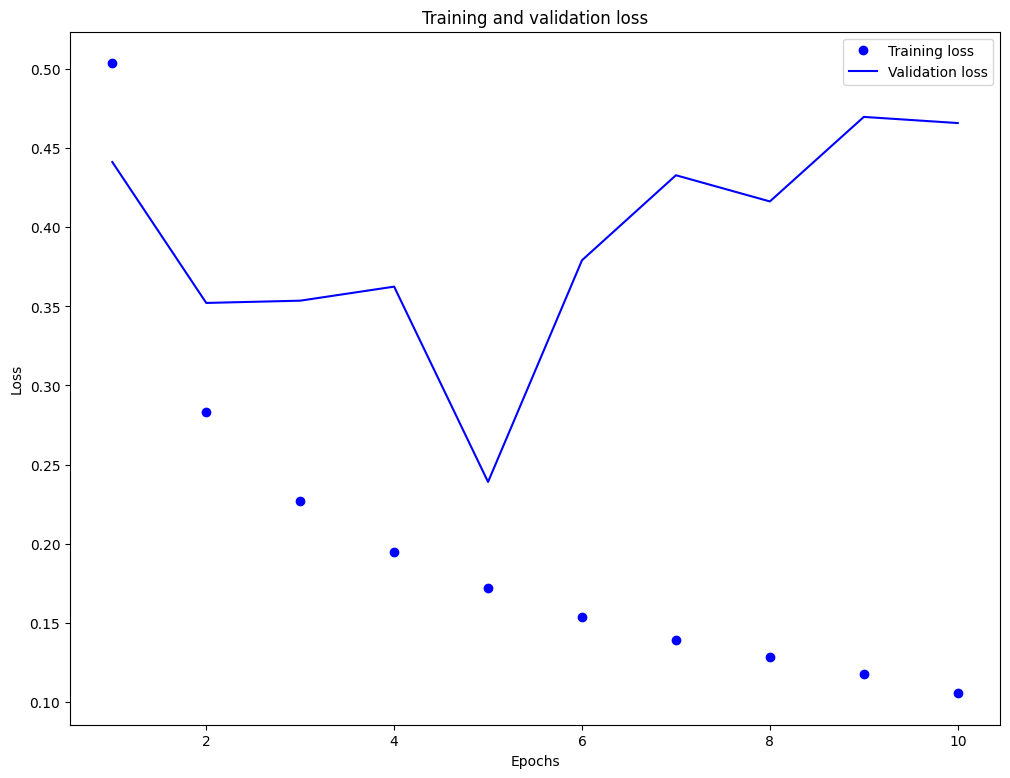

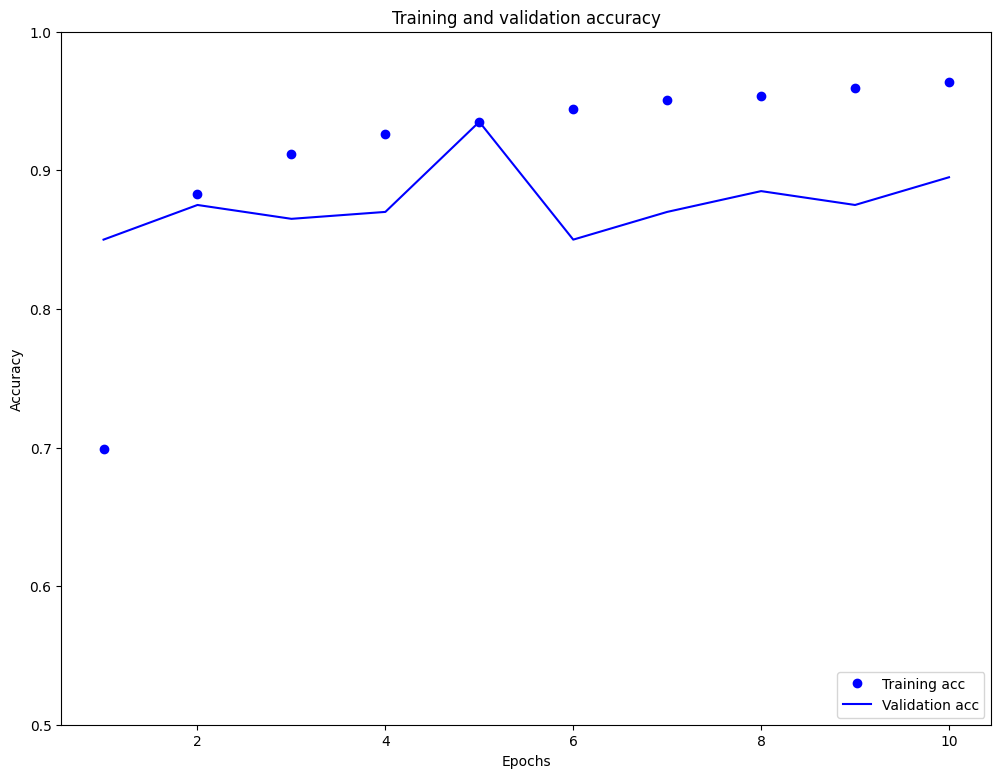

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 学習した埋め込みの取得

次に、訓練によって学習された単語埋め込みを取得してみます。これは、shape が `(vocab_size, embedding-dimension)` の行列になります。

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


この重みをディスクに出力します。[Embedding Projector](http://projector.tensorflow.org) を使うため、タブ区切り形式の2つのファイルをアップロードします。（埋め込みを含む）ベクトルのファイルと、（単語を含む）メタデータファイルです。

In [17]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # 0 はパディングのためスキップ
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

このチュートリアルを [Colaboratory](https://colab.research.google.com) で実行している場合には、下記のコードを使ってこれらのファイルをローカルマシンにダウンロードすることができます（あるいは、ファイルブラウザを使います。*表示 -> 目次 -> ファイル* ）。

In [18]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## 埋め込みを可視化する

埋め込みを可視化するため、これらのファイルを Embedding Projector にアップロードします。

[Embedding Projector](http://projector.tensorflow.org/) を開きます（あるいはローカルの TensorBoard でも実行できます）。

* "Load data" をクリックします

* 上記で作成した```vecs.tsv``` と ```meta.tsv``` の 2つのファイルをアップロードします


学習させた埋め込みが表示されます。単語を探し、最も近い単語を見つけることができます。たとえば、"beautiful" という単語を探してみてください。近くに、 "wonderful" のような単語が見つかると思います。

Note: 訓練の前に重みが乱数によってどのように初期化されたかによって、結果は少し異なるかもしれません。

Note: 実験として、もっと単純なモデルを使い、より解釈しやすい埋め込みを作ることもできます。`Dense(16)` レイヤーを削除してみてください。このモデルを再度訓練して、埋め込みの可視化をもう一度行ってみましょう。

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## 次のステップ

このチュートリアルでは、小さなデータセットを使い、単語埋め込みを最初から訓練し、可視化する方法を見てきました。

* リカレントネットワークについて学ぶには、[Keras RNN ガイド](../../guide/keras/rnn.ipynb) を参照してください。

* テキスト分類について更に学ぶには、（全体のワークフローや、どういうときに埋め込みあるいはワンホットエンコーディングを使うべきかについて興味があれば）この実践的なテキスト分類の [ガイド](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) を推奨します。